# Train models on 3 whales, validate on the 4th and test on the last, follow idea of cross validation

In [1]:
# https://jin-yang.github.io/reference/linux/monitor/check-cpu-info-linux.pdf
# !cat /proc/cpuinfo 
!lscpu 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.136
BogoMIPS:            4000.27
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [2]:
import torch
print(torch.__version__)

!nvidia-smi
!python -V

1.7.0+cu101
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Python 3.6.9


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/Colab Notebooks/'

def _range(x):
    return np.array([x.min() , x.max()])

import IPython
from IPython.display import SVG, display

def AUC_PR(y, y_t):
    # https://notmatthancock.github.io/2015/08/19/roc-curve-part-2-numerical-example.html
    thresholds = np.linspace(1,0,101)
    ROC = np.zeros((101,3))

    for i in range(101):
        t = thresholds[i]
        # Classifier / label agree and disagreements for current threshold.
        TP_t = np.logical_and( y > t, y_t == 1 ).sum()
        # FN_t = np.logical_and( y <=t, y_t == 1 ).sum()
        FP_t = np.logical_and( y > t, y_t == 0 ).sum()
        # TN_t = np.logical_and( y <=t, y_t == 0 ).sum()
        # Compute false positive rate for current threshold.
        # FPR_t = FP_t / float(FP_t+TN_t)
        ROC[i,0] = FP_t
        # Compute true  positive rate for current threshold.
        # TPR_t = TP_t / float(TP_t+FN_t)
        ROC[i,1] = TP_t
        # Precision
        ROC[i,2] = (TP_t+1e-6)/ float(TP_t+FP_t+1e-6)

    ROC[:,0] /= float(y_t.size - y_t.sum())
    ROC[:,1] /= float(y_t.sum())

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import brier_score_loss
    from sklearn.metrics import average_precision_score

    # Plot the ROC & AUC [https://stackoverflow.com/a/53719336]
    import matplotlib.pyplot as plt
    %matplotlib inline
    IPython.display.set_matplotlib_formats('svg')

    plt.style.use('default')
    # plt.style.use('ggplot')
    plt.figure(figsize=(8,4))

    # AUC = 0.
    # for i in range(100):
    #   AUC += (ROC[i+1,0]-ROC[i,0]) * (ROC[i+1,1]+ROC[i,1])
    # AUC *= 0.5

    ax = plt.subplot(121)
    # ax.set_title('Precision-Recall scatter plot, Brier score = %.4f'%brier_score_loss(y_t, y))
    ax.set_title('Precision-Recall scatter plot, AUC score = %.4f'%average_precision_score(y_t, y))
    # plt.plot(ROC[:,1], ROC[:,2], lw=2)
    plt.scatter(ROC[:,1], ROC[:,2], s=7, c='blue')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel(r'$Recall = \frac{TP}{TP+FN}$')
    plt.ylabel(r'$Precision = \frac{TP}{TP+FP}$')
    plt.grid()


    # https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used
    ax = plt.subplot(122)
    ax.set_title('ROC scatter plot, AUC = %.4f'%roc_auc_score(y_t, y))
    # plt.plot(ROC[:,0], ROC[:,1], lw=2)
    plt.scatter(ROC[:,0], ROC[:,1], s=7, c='red')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel(r'$FPR(t) = \frac{FP}{FP+TN} $')
    plt.ylabel(r'$TPR(t) = \frac{TP}{TP+FN} $')
    plt.grid()

    plt.tight_layout()
    plt.show()

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
import numpy as np

def consecutive(y, thresh=0.0, stepsize=1): # https://stackoverflow.com/a/7353335
    data = np.array(np.where(y > thresh ))[0]
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


from numba import njit
@njit
def intersect(s0,e0, s1,e1) :
  m = len(s0)
  n = len(s1)
  if n == 1 :
    return None
  d = np.zeros( (m, n), dtype=np.int64)
  ovl = np.zeros( (m, n), dtype=np.float32)
  i = j = 0
  
  for j in range(m) :
    for i in range(n) :
      # https://scicomp.stackexchange.com/a/26260
      if s0[j] > e1[i] or s1[i] > e0[j] : # (1) & (2)
        if s0[j] > e1[i] : # (1)
          # d[j][i] = s1[i] - s0[j]
          d[j][i] = e1[i] - s0[j]
        if s1[i] > e0[j] : # (2)
          # d[j][i] = s1[i] - s0[j]
          d[j][i] = s1[i] - e0[j]
      else: # overlap
        s_ovl = max(s0[j], s1[i])
        e_ovl = min(e0[j], e1[i])
        d[j][i] = 0
        ovl[j][i] = (e_ovl-s_ovl)/(e0[j]-s0[j])*100
        
  return d, ovl


y1 = np.random.randint(1, 10, size=5)
y1e = y1 + np.random.randint(2, 5, size=5)
y2 = y1 + np.random.randint(1, 10, size=5)
y2e = y2 + np.random.randint(2, 5, size=5)

intersect( y1, y1e, y2, y2e)

@njit
def nearest(x, y) :
  m = len(x)
  I = np.repeat(-1,m)
  D = np.zeros(m)
  
  for i in range(m):
    I[i] = np.argmin(np.abs(y - x[i])) 
    D[i] = y[I[i]] - x[i]
  return I, D

nearest(np.random.randint(10, size=5), np.random.randint(10, size=5) )


(array([2, 3, 0, 3, 0]), array([ 1., -2., -1.,  0.,  0.]))

In [5]:
def hit_rate(y, y_t, dist=100, ovl_ptg=50, offset_rate=0.8, accel=None) :
    C = consecutive(y, 0.5)
    C_t = consecutive(y_t)
    if len(C[0]) == 0 :
        return None, None, None, None
    s1 = np.ravel([ x[0] for x in C ])
    e1 = np.ravel([ x[-1] for x in C ]) + 1
    s0 = np.ravel([ x[0] for x in C_t ])
    e0 = np.ravel([ x[-1] for x in C_t ]) + 1

    a, ovl = intersect(s0,e0, s1,e1)
    
    # offset = round(offset_rate*accel.shape[0])
    # depth_hit = accel.iloc[offset + s0[hit], 5].to_numpy()
    # depth_missed = accel.iloc[offset + s0[missed], 5].to_numpy()

    hit = np.where( abs(a).min(axis=1) <= dist )[0]
    missed = np.sort(np.array( list(set(range(len(s0)))-set(hit)) ))
    hit_ovl = np.where( ovl.max(axis=1) > ovl_ptg )[0]
    # missed_ovl = np.array( list(set(range(len(s0)))-set(hit_ovl)) )

    return len(hit)/len(s0), len(hit_ovl)/len(s0), hit, missed


# Import data and preprocess

In [6]:
%load_ext google.colab.data_table

import pandas as pd
import glob
all_files = glob.glob("data/whale/2018/*.csv.parquet")
all_files = sorted(all_files, reverse=False)
all_files

['data/whale/2018/accel-Asgeir.csv.parquet',
 'data/whale/2018/accel-Helge18.csv.parquet',
 'data/whale/2018/accel-Kyrri.csv.parquet',
 'data/whale/2018/accel-Nemo.csv.parquet',
 'data/whale/2018/accel-Siggi.csv.parquet']

In [7]:
# import pathlib
# pathlib.Path('/data/model/whale/U-Time_5/'+whale_name).mkdir(parents=True, exist_ok=True) 
# path = '/data/model/whale/U-Time_5/' + whale_name + '/'
# path

In [8]:
import sys
# sys.path.append('/content/drive/My Drive/Colab Notebooks/packages')
# sys.path.insert(1,'/content/drive/My Drive/Colab Notebooks/packages')

import numpy as np
hdi_rate = 100
import pdb
sys.path

np.set_printoptions(precision=6)
np.set_printoptions(suppress=True) # prevent numpy exponential
np.set_printoptions(linewidth=120)

In [9]:
%%time

accel = [None] * len(all_files)
for i in range(len(all_files) ):
    accel[i] = pd.read_parquet(all_files[i])    

CPU times: user 6.42 s, sys: 6.54 s, total: 13 s
Wall time: 11.3 s


In [10]:
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
# Set up the loss criterion and the optimiser
import torch.optim as optim

class UTime(nn.Module):
  # https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
  def __init__(self, in_channels, out_channels=1, n_fillter=16, n_kernel=2):
    super(UTime, self).__init__()

    features = n_fillter
    self.encoder1 = UTime._block(in_channels, features, name="enc1", n_kernel=n_kernel)
    self.pool1 = nn.MaxPool1d(kernel_size=10)
    self.encoder2 = UTime._block(features, features * 2, name="enc2", n_kernel=n_kernel)
    self.pool2 = nn.MaxPool1d(kernel_size=8)
    self.encoder3 = UTime._block(features * 2, features * 4, name="enc3", n_kernel=n_kernel)
    self.pool3 = nn.MaxPool1d(kernel_size=6)
    self.encoder4 = UTime._block(features * 4, features * 8, name="enc4", n_kernel=n_kernel)
    self.pool4 = nn.MaxPool1d(kernel_size=4)

    self.bottleneck = UTime._block(features * 8, features * 16, name="bottleneck", n_kernel=n_kernel)

    # torch.nn.ConvTranspose2d vs torch.nn.Upsample:
    # [https://discuss.pytorch.org/t/torch-nn-convtranspose2d-vs-torch-nn-upsample]
    # self.upconv4 = nn.ConvTranspose2d(
      # features * 16, features * 8, kernel_size=2, stride=str
    # )
    self.upconv4 = nn.Upsample(scale_factor=4, mode='nearest')

    self.decoder4 = UTime._block((features * 8) * 2, features * 8, name="dec4", n_kernel=n_kernel)
    self.ConvBN4  = UTime._ConvBN((features * 8) * 2, features * 8, name="conv_BN4", n_kernel=n_kernel)
    # self.upconv3 = nn.ConvTranspose2d(
      # features * 8, features * 4, kernel_size=2, stride=str
    # )
    self.upconv3 = nn.Upsample(scale_factor=6, mode='nearest')
    
    self.decoder3 = UTime._block((features * 4) * 2, features * 4, name="dec3", n_kernel=n_kernel)
    self.ConvBN3  = UTime._ConvBN((features * 4) * 2, features * 4, name="conv_BN3", n_kernel=n_kernel)
    # self.upconv2 = nn.ConvTranspose2d(
      # features * 4, features * 2, kernel_size=2, stride=str
    # )
    self.upconv2 = nn.Upsample(scale_factor=8, mode='nearest')
    self.decoder2 = UTime._block((features * 2) * 2, features * 2, name="dec2", n_kernel=n_kernel)
    self.ConvBN2  = UTime._ConvBN((features * 2) * 2, features * 2, name="conv_BN2", n_kernel=n_kernel)
    # self.upconv1 = nn.ConvTranspose2d(
      # features * 2, features, kernel_size=2, stride=str
    # )
    self.upconv1 = nn.Upsample(scale_factor=10, mode='nearest')
    self.decoder1 = UTime._block(features * 2, features, name="dec1", n_kernel=n_kernel)
    self.ConvBN1  = UTime._ConvBN(features * 2, features, name="conv_BN1", n_kernel=n_kernel)

    self.conv = nn.Conv1d(features, out_channels, kernel_size=1 )
    
    self.Conv36 = nn.Conv1d(n_fillter, 2, kernel_size=1 )
    self.Conv39 = nn.Conv1d(2, 2, kernel_size=1 )
    # self.AvgPool = nn.AvgPool2d((1,I), stride=(1,I), padding=(0,int(I/2)-1))
    
    self.Dense = nn.Linear(2, out_channels)  
    self.relu = nn.ReLU()

  def forward(self, x):    # https://stackoverflow.com/a/50376836
    # x1 = torch.reshape(x, (x.shape[0],-1,1,x.shape[1]) )

    # x1 = torch.flatten(x, start_dim=2, end_dim=3)
    # x1 = x10.flatten(1).unsqueeze(1)
    
    # pdb.set_trace()
    
    enc1 = self.encoder1(x) # ID 3, 4
    enc2 = self.encoder2(self.pool1(enc1)) # ID 5, 6, 7
    enc3 = self.encoder3(self.pool2(enc2)) # ID 8, 9, 10
    enc4 = self.encoder4(self.pool3(enc3)) # ID 11, 12, 13

    bottleneck = self.bottleneck(self.pool4(enc4)) # ID 14, 15, 16

    dec4 = self.upconv4(bottleneck) # ID 17
    dec4 = self.ConvBN4(dec4) # ID 18
    # https://github.com/pytorch/pytorch/issues/1331#issuecomment-296387792
    enc4_crop = enc4[:,:,round((enc4.shape[2]-dec4.shape[2])/2):round((enc4.shape[2]+dec4.shape[2])/2)]
    dec4 = torch.cat((dec4, enc4_crop), dim=1) # ID 19
    dec4 = self.decoder4(dec4) # ID 20, 21
    
    dec3 = self.upconv3(dec4) # ID 22
    dec3 = self.ConvBN3(dec3) # ID 23
    enc3_crop = enc3[:,:,round((enc3.shape[2]-dec3.shape[2])/2):round((enc3.shape[2]+dec3.shape[2])/2)]
    dec3 = torch.cat((dec3, enc3_crop), dim=1) # ID 24
    dec3 = self.decoder3(dec3) # ID 25, 26

    dec2 = self.upconv2(dec3) # ID 27
    dec2 = self.ConvBN2(dec2) # ID 28
    enc2_crop = enc2[:,:,round((enc2.shape[2]-dec2.shape[2])/2):round((enc2.shape[2]+dec2.shape[2])/2)]
    dec2 = torch.cat((dec2, enc2_crop), dim=1) # ID 29
    dec2 = self.decoder2(dec2) # ID 30, 31

    dec1 = self.upconv1(dec2) # ID 32
    dec1 = self.ConvBN1(dec1) # ID 33
    enc1_crop = enc1[:,:,round((enc1.shape[2]-dec1.shape[2])/2):round((enc1.shape[2]+dec1.shape[2])/2)]
    dec1 = torch.cat((dec1, enc1_crop), dim=1) # ID 34
    dec1 = self.decoder1(dec1) # ID 35, 36
    
    # binary classfication
    dec0 = self.Conv36(dec1)

    # Zero padding
    # dec = nn.ConstantPad1d( int((x.shape[2]-dec0.shape[2])/2), 0.0)(dec0)
    # https://discuss.pytorch.org/t/how-to-pad-one-side-in-pytorch/21212/5
    padd_size = int((x.shape[2]-dec0.shape[2])/2)
    dec = F.pad(dec0, (padd_size,padd_size), "constant", 0.0)
    
    # # Step 38: reshape
    # # rs = torch.reshape(dec, (dec.shape[0], dec.shape[1], T, I ) )
    # rs = torch.reshape(dec, (dec.shape[0], dec.shape[1], int(dec.shape[2]/I), I ) )
    # pdb.set_trace()
    # # Average Pooling (step 38)
    # ap = self.AvgPool(rs)
    # ap = ap.squeeze(3)
    # # Step 39: convolution
    # outp = self.relu( self.Conv39(ap) )
    outp = self.relu( self.Conv39(dec) )
    
    # UTime/Unet doesn't have Dense layer before output??
    # quora.com/Why-are-the-often-dense-layers-at-the-end-of-convolutional-neural-networks
    op = self.Dense(outp.transpose(1,2))
    
    return torch.sigmoid( op.squeeze(2) )

  @staticmethod
  def _block(in_channels, features, name, n_kernel):
    return nn.Sequential(
      OrderedDict(
        [
          (
            name + "conv1",
            nn.Conv1d(
              in_channels = in_channels,
              out_channels = features,
              kernel_size = n_kernel,
              padding=1,
              dilation=2,
              bias=False,
            ),
          ),
          (name + "norm1", nn.BatchNorm1d(num_features=features)),
          (name + "relu1", nn.ReLU(inplace=True)),
          (
            name + "conv2",
            nn.Conv1d(
              in_channels = features,
              out_channels = features,
              kernel_size = n_kernel,
              padding=1,
              dilation=2,
              bias=False,
            ),
          ),
          (name + "norm2", nn.BatchNorm1d(num_features=features)),
          (name + "relu2", nn.ReLU(inplace=True)),
        ]
      )
    )

  @staticmethod
  def _ConvBN(in_channels, features, name, n_kernel):
    return nn.Sequential(
      OrderedDict(
        [
          (
            name + "conv1",
            nn.Conv1d(
              in_channels = in_channels,
              out_channels = features,
              kernel_size = n_kernel,
              padding=1,
              dilation=2,
              bias=False,
            ),
          ),
          (name + "norm1", nn.BatchNorm1d(num_features=features)),
          (name + "relu1", nn.ReLU(inplace=True)),
        ]
      )
    )

In [11]:
# Split with overlap
# t = 60 # 60 min
# T = int((t*60)*e)
overlap_rate = 1/10
C = 8 # X, Y, Z, Depth & 4 One hot encoding
S = hdi_rate # 100 Hz
# S = 50 # 100 Hz

T = 36000 # no. of sub-segments
# e = 1/30 #  frequency ('e' times/sec) at which we want to segment signals
# e = 1/(60*30) #  frequency ('e' times/sec) at which we want to segment signals
e = 10
I = round(S/e) # = ...
L = round(T*S/e)
print('length(x) = t =', T/(60*e), 'mins of', T, 'sub-segments' )

def pandas_fill(arr):
    df = pd.DataFrame(arr)
    df.fillna(method='ffill', inplace=True)
    return df.values[:,0]

def consecutive(y, thresh=0.0, stepsize=1): # https://stackoverflow.com/a/7353335
    data = np.array(np.where(y > thresh ))[0]
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def make_dataset(a1,b1,overlap = overlap_rate, win_shape=(L,C+1) ):
    window_shape = win_shape ; st = round((1-overlap)*L)
    x = view_as_windows(a1, window_shape, step=st).squeeze(1)
    y0 = view_as_windows(b1, (L,), step=st)
    if a1.shape[0]%st != 0:
        # if (overlap == 0) :
        #     return x, y0
        x  = np.concatenate(( x, np.expand_dims(a1[-L:,:],0) ))
        y0 = np.concatenate(( y0, np.expand_dims(b1[-L:],0) ))
    return x, y0

from skimage.util.shape import view_as_windows
# https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.view_as_windows


def split_dataset(accel, val_test=0, train_rate = 0.6, val_rate = 0.2, no_val=False, no_test = False) :
    A = accel.iloc[:,1:(1+C)].to_numpy()
    A = np.c_[A,range(accel.shape[0])]
    B = accel.iloc[:,-1].to_numpy()*1
    
    train_index = round(train_rate*A.shape[0])
    val_index = train_index + round(val_rate*A.shape[0])
    
    if no_val :
      a1 = A; b1 = B
    else :
      a1 = A[:train_index,:]; b1 = B[:train_index]
      a2 = A[train_index:val_index,:]; b2 = B[train_index:val_index]
    if not no_test :
      a3 = A[val_index:,:]
      b3 = B[val_index:]

    if val_test == 1 :
        return a1, b1
    if val_test == 2 :
        return a2, b2
    if val_test == 3 :
        return a3, b3

    X_train, Y_train = make_dataset(a1,b1)
    X_train = X_train.swapaxes(1,2)
    if no_val :
      return X_train, Y_train
    else :
      X_val, Y_val = make_dataset(a2,b2)
      X_val = X_val.swapaxes(1,2)

    if not no_test :
      X_test, Y_test = make_dataset(a3,b3,overlap = 0)
      X_test = X_test.swapaxes(1,2)
      return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_val, Y_train, Y_val


length(x) = t = 60.0 mins of 36000 sub-segments


In [12]:
seed = 1649 + 502
np.random.seed(seed) # Seed

SMOOTH = 1
# https://github.com/pytorch/pytorch/issues/1249#issuecomment-337999895
# You can set smooth to zero and add 'eps' to the denominator to prevent division by 0.
# However, having a larger smooth value
# (as Laplace smooth, or Additive smooth) can be used to avoid overfitting
def dice_loss(preds,target):
    target = target.type_as(preds)
    loss = 1 - ( 2 * ( preds * target).sum() + SMOOTH ) / ( (preds + target).sum() + SMOOTH )
    return loss

criterion = dice_loss

#%% Init model

Hidden_unit = [2**x for x in range(1,7)]
# Learning_rate = np.array([5e-3, 1e-3, 5e-4, 1e-4, 1e-5, 1e-6])
Learning_rate = np.array([1e-2, 5e-3, 1e-3, 5e-4])

stop_epoch = 150
N_EPOCH = 301

In [13]:
def extract_name(st):
    whale_name = st[(st.find('-')+1):st.find('.')]
    return whale_name

# Join all dataset

In [14]:
X_all, Y_all = map(list, zip(*[split_dataset(x, val_test=1, train_rate = 1, val_rate = 0) for x in accel ]))

X_all = np.concatenate( X_all )
Y_all = np.concatenate( Y_all )

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_all = scaler.fit_transform( X_all )

# Importing gc module
import gc ; gc.collect()

0

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

x_all = X_all[:,0:C].astype(np.float32); y_all = Y_all

x_all = x_all.swapaxes(0,1)
x_all = np.expand_dims(x_all, axis=0)

# Load training data as torch float tensors
x_all = torch.FloatTensor(x_all) # Input
y_all = torch.FloatTensor(y_all) # Target
## Move to cuda
x_all = x_all.to(device)
y_all = y_all.to(device)

cpu


# 0. Asgeir 

In [17]:
w = 0
test_whale = [ w, (w+1)%len(all_files) ]
print(test_whale)

whale_name = extract_name(all_files[test_whale[0]])
print(whale_name)

accel[w]

[0, 1]
Asgeir


DateTime       AccX       AccY  ...  Dive_no   whale  buzz
0        2018-08-24 22:31:45 -636.71875 -464.84375  ...       81  Asgeir     0
1                        NaT -632.81250 -457.03125  ...       81  Asgeir     0
2                        NaT -625.00000 -476.56250  ...       81  Asgeir     0
3                        NaT -632.81250 -480.46875  ...       81  Asgeir     0
4                        NaT -628.90625 -492.18750  ...       81  Asgeir     0
...                      ...        ...        ...  ...      ...     ...   ...
11478895                 NaT   89.84375  492.18750  ...     -193  Asgeir     0
11478896                 NaT  117.18750  515.62500  ...     -193  Asgeir     0
11478897                 NaT   74.21875  535.15625  ...     -193  Asgeir     0
11478898                 NaT   82.03125  550.78125  ...     -193  Asgeir     0
11478899 2018-08-26 06:24:53  101.56250  550.78125  ...     -193  Asgeir     0

[11478900 rows x 13 columns]

In [18]:
train_whale = list(range(len(all_files)))
train_whale.remove(w)
train_whale.remove( (w+1)%len(all_files) )
print(train_whale)

[2, 3, 4]


In [19]:
# 2: validation & test
x_whale = [None]*2
y_whale = [None]*2
x_w = [None]*2
y_w = [None]*2

for i in test_whale :
    x_whale[i] = accel[i].iloc[:,1:(1+C)].to_numpy()
    y_whale[i] = accel[i].iloc[:,-1].to_numpy()
    x_w[i], y_w[i] = make_dataset(x_whale[i], y_whale[i], overlap=0, win_shape=(L,C) )
    x_w[i] = x_w[i].swapaxes(1,2)

# x_whale = accel[w].iloc[:,1:(1+C)].to_numpy()
# y_whale = accel[w].iloc[:,-1].to_numpy()
# x_w, y_w = make_dataset(x_whale, y_whale, overlap=0, win_shape=(L,C) )
# x_w = x_w.swapaxes(1,2)

In [20]:
# https://stackoverflow.com/a/42376244
X_train, Y_train = map(list, zip(*[split_dataset(accel[i], no_val=True) for i in train_whale ]))
# n_elem_test = np.ravel([x.shape[0] for x in X_test])
# n_elem_test = np.append(0, n_elem_test).cumsum()

In [21]:
X_train = np.concatenate( X_train )
Y_train = np.concatenate( Y_train )
# X_val = np.concatenate( X_val )
# Y_val = np.concatenate( Y_val )

In [22]:
# https://datascience.stackexchange.com/a/27616
# https://datascience.stackexchange.com/a/12346
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if (X_train.shape[1] == C+1):
    for i in range(C):
        X_train[:,i,:] = scaler.fit_transform( X_train[:,i,:] )
        # X_val[:,i,:]   = scaler.transform( X_val[:,i,:] )
        for k in test_whale :
            x_w[k][:,i,:] = scaler.transform( x_w[k][:,i,:] )
    print('Normalize column 1')
if (X_train.shape[2] == C+1):
    for i in range(C):
        X_train[:,:,i] = scaler.fit_transform( X_train[:,:,i] )
        # X_val[:,:,i]   = scaler.transform( X_val[:,:,i] )
        for k in test_whale :
            x_w[k][:,:,i] = scaler.transform( x_w[k][:,:,i] )
    print('Normalize column 2')

Normalize column 1


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for i in test_whale :
    x_w[i] = torch.FloatTensor(x_w[i].astype(np.float32))
    y_w[i] = torch.FloatTensor(y_w[i].astype(np.float32))
    x_w[i] = x_w[i].to(device)
    y_w[i] = y_w[i].to(device)


# Importing gc module
import gc ; gc.collect()

nTrain = len(X_train)
# nVal = len(X_val)

cpu


In [24]:
print(test_whale[0])
print(test_whale[1])

print(len(x_w[test_whale[0]]))
print(len(x_w[test_whale[1]]))

0
1
32
33


In [25]:
x_train = X_train[:,0:C,:].astype(np.float32); y_train = Y_train
# x_val = X_val[:,0:C,:].astype(np.float32); y_val = Y_val
# x_test = X_test[:,0:C,:].astype(np.float32); y_test = Y_test

# Load training data as torch float tensors
x_train = torch.FloatTensor(x_train) # Input
y_train = torch.FloatTensor(y_train) # Target
x_train = x_train.to(device)
y_train = y_train.to(device)

# x_val = torch.FloatTensor(x_val) # Input
# y_val = torch.FloatTensor(y_val) # Target
# x_test = torch.FloatTensor(x_w) # Input
# y_test = torch.FloatTensor(y_w) # Target

# x_val = x_val.to(device)
# y_val = y_val.to(device)
# x_test = x_test.to(device)
# y_test = y_test.to(device)

### Train model

In [ ]:
import os
epochs = N_EPOCH

print(nTrain) # print(nVal)
print(x_train.shape) # print(x_val.shape)

65
torch.Size([65, 8, 360000])


In [ ]:
hidden_unit = 4 # Hidden units
n_kernel = 4

Batch_size = [2**x for x in range(1,11)] # https://datascience.stackexchange.com/a/20193
Batch_size = [x for x in Batch_size \
              if x <= min(nTrain, len(x_w[test_whale[0]]), len(x_w[test_whale[1]])) ]

Batch_size

[2, 4, 8, 16, 32]

batch_size = 2 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.981543 -- Val. Loss 0: 0.959167 -- Val. Loss 1: 0.952781
Epoch 0025 -- Train Loss : 0.927404 -- Val. Loss 0: 0.886376 -- Val. Loss 1: 0.880101
Epoch 0050 -- Train Loss : 0.727255 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823428
Epoch 0075 -- Train Loss : 0.727157 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823368
Epoch 0100 -- Train Loss : 0.727130 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823351
Epoch 0125 -- Train Loss : 0.727118 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823343
Epoch 0150 -- Train Loss : 0.727112 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823340
Epoch 0175 -- Train Loss : 0.727109 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.823337
Model isn't probably improved anymore, skip to next learning rate...



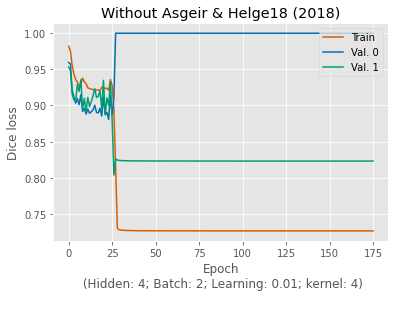

batch_size = 2 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.981364 -- Val. Loss 0: 0.971612 -- Val. Loss 1: 0.966337
Epoch 0025 -- Train Loss : 0.924011 -- Val. Loss 0: 0.907693 -- Val. Loss 1: 0.904460
Epoch 0050 -- Train Loss : 0.903009 -- Val. Loss 0: 0.890485 -- Val. Loss 1: 0.884534
Epoch 0075 -- Train Loss : 0.888508 -- Val. Loss 0: 0.907162 -- Val. Loss 1: 0.883727
Epoch 0100 -- Train Loss : 0.888952 -- Val. Loss 0: 0.884906 -- Val. Loss 1: 0.863583
Epoch 0125 -- Train Loss : 0.865873 -- Val. Loss 0: 0.879803 -- Val. Loss 1: 0.874870
Epoch 0150 -- Train Loss : 0.837128 -- Val. Loss 0: 0.874361 -- Val. Loss 1: 0.856515
Epoch 0175 -- Train Loss : 0.798116 -- Val. Loss 0: 0.769432 -- Val. Loss 1: 0.823000
Epoch 0200 -- Train Loss : 0.723289 -- Val. Loss 0: 0.701947 -- Val. Loss 1: 0.778860
Epoch 0225 -- Train Loss : 0.751380 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.838442
Epoch 0250 -- Train Loss : 0.736027 -- Val. Loss 0: 0.999388 -- Val. Loss 1: 0.828982
Epoch 0275 -- T

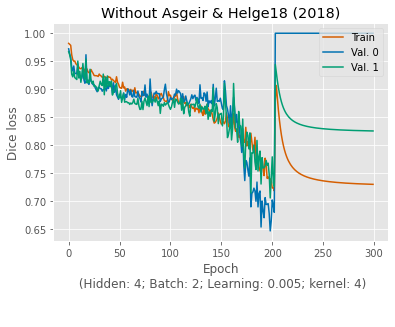

batch_size = 2 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.982063 -- Val. Loss 0: 0.975530 -- Val. Loss 1: 0.970198
Epoch 0025 -- Train Loss : 0.932448 -- Val. Loss 0: 0.921235 -- Val. Loss 1: 0.914014
Epoch 0050 -- Train Loss : 0.876697 -- Val. Loss 0: 0.880381 -- Val. Loss 1: 0.876256
Epoch 0075 -- Train Loss : 0.795883 -- Val. Loss 0: 0.837204 -- Val. Loss 1: 0.849723
Epoch 0100 -- Train Loss : 0.694414 -- Val. Loss 0: 0.803982 -- Val. Loss 1: 0.841250
Epoch 0125 -- Train Loss : 0.609971 -- Val. Loss 0: 0.785377 -- Val. Loss 1: 0.820217
Epoch 0150 -- Train Loss : 0.535135 -- Val. Loss 0: 0.737684 -- Val. Loss 1: 0.779566
Epoch 0175 -- Train Loss : 0.489273 -- Val. Loss 0: 0.724258 -- Val. Loss 1: 0.776089
Epoch 0200 -- Train Loss : 0.458324 -- Val. Loss 0: 0.750774 -- Val. Loss 1: 0.817551
Epoch 0225 -- Train Loss : 0.434036 -- Val. Loss 0: 0.751542 -- Val. Loss 1: 0.825447
Epoch 0250 -- Train Loss : 0.413522 -- Val. Loss 0: 0.751168 -- Val. Loss 1: 0.813128
Epoch 0275 -- T

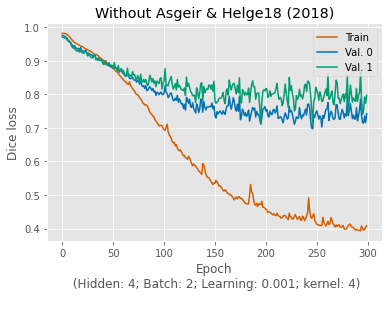

batch_size = 2 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.982034 -- Val. Loss 0: 0.975470 -- Val. Loss 1: 0.970000
Epoch 0025 -- Train Loss : 0.954319 -- Val. Loss 0: 0.945028 -- Val. Loss 1: 0.944314
Epoch 0050 -- Train Loss : 0.936953 -- Val. Loss 0: 0.937475 -- Val. Loss 1: 0.942019
Epoch 0075 -- Train Loss : 0.916155 -- Val. Loss 0: 0.924668 -- Val. Loss 1: 0.934083
Epoch 0100 -- Train Loss : 0.890542 -- Val. Loss 0: 0.908914 -- Val. Loss 1: 0.926032
Epoch 0125 -- Train Loss : 0.858965 -- Val. Loss 0: 0.893782 -- Val. Loss 1: 0.917100
Epoch 0150 -- Train Loss : 0.819468 -- Val. Loss 0: 0.869766 -- Val. Loss 1: 0.898414
Epoch 0175 -- Train Loss : 0.774328 -- Val. Loss 0: 0.851045 -- Val. Loss 1: 0.892805
Epoch 0200 -- Train Loss : 0.725531 -- Val. Loss 0: 0.838261 -- Val. Loss 1: 0.879528
Epoch 0225 -- Train Loss : 0.679189 -- Val. Loss 0: 0.817433 -- Val. Loss 1: 0.866417
Epoch 0250 -- Train Loss : 0.637860 -- Val. Loss 0: 0.808760 -- Val. Loss 1: 0.871428
Epoch 0275 -- 

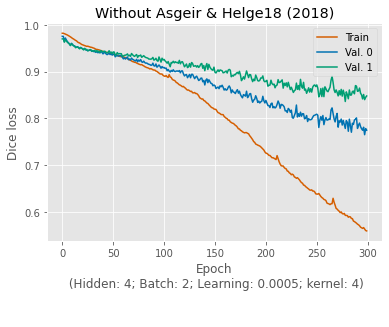

batch_size = 4 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.977604 -- Val. Loss 0: 0.965473 -- Val. Loss 1: 0.957648
Epoch 0025 -- Train Loss : 0.899278 -- Val. Loss 0: 0.920501 -- Val. Loss 1: 0.912696
Epoch 0050 -- Train Loss : 0.817045 -- Val. Loss 0: 0.760053 -- Val. Loss 1: 0.757485
Epoch 0075 -- Train Loss : 0.596446 -- Val. Loss 0: 0.664978 -- Val. Loss 1: 0.652364
Epoch 0100 -- Train Loss : 0.561989 -- Val. Loss 0: 0.652577 -- Val. Loss 1: 0.663993
Epoch 0125 -- Train Loss : 0.541668 -- Val. Loss 0: 0.642949 -- Val. Loss 1: 0.687877
Epoch 0150 -- Train Loss : 0.535243 -- Val. Loss 0: 0.651463 -- Val. Loss 1: 0.595610
Epoch 0175 -- Train Loss : 0.508999 -- Val. Loss 0: 0.693390 -- Val. Loss 1: 0.720121
Epoch 0200 -- Train Loss : 0.499525 -- Val. Loss 0: 0.637614 -- Val. Loss 1: 0.672345
Epoch 0225 -- Train Loss : 0.505503 -- Val. Loss 0: 0.658911 -- Val. Loss 1: 0.620729
Epoch 0250 -- Train Loss : 0.454871 -- Val. Loss 0: 0.652192 -- Val. Loss 1: 0.669847
Epoch 0275 -- Tr

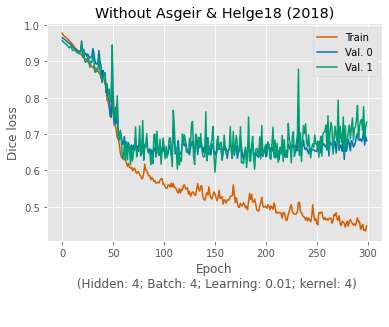

batch_size = 4 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.977640 -- Val. Loss 0: 0.971401 -- Val. Loss 1: 0.965275
Epoch 0025 -- Train Loss : 0.848387 -- Val. Loss 0: 0.844075 -- Val. Loss 1: 0.831297
Epoch 0050 -- Train Loss : 0.639449 -- Val. Loss 0: 0.709343 -- Val. Loss 1: 0.659659
Epoch 0075 -- Train Loss : 0.536325 -- Val. Loss 0: 0.681523 -- Val. Loss 1: 0.675567
Epoch 0100 -- Train Loss : 0.501929 -- Val. Loss 0: 0.672803 -- Val. Loss 1: 0.637356
Epoch 0125 -- Train Loss : 0.488056 -- Val. Loss 0: 0.665441 -- Val. Loss 1: 0.651979
Epoch 0150 -- Train Loss : 0.439677 -- Val. Loss 0: 0.703492 -- Val. Loss 1: 0.713847
Epoch 0175 -- Train Loss : 0.442328 -- Val. Loss 0: 0.672645 -- Val. Loss 1: 0.684152
Epoch 0200 -- Train Loss : 0.400788 -- Val. Loss 0: 0.709922 -- Val. Loss 1: 0.779550
Epoch 0225 -- Train Loss : 0.391545 -- Val. Loss 0: 0.703450 -- Val. Loss 1: 0.753965
Epoch 0250 -- Train Loss : 0.429423 -- Val. Loss 0: 0.744543 -- Val. Loss 1: 0.792755
Epoch 0275 -- T

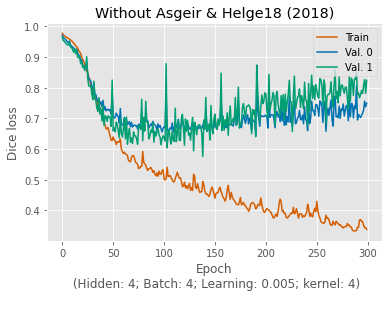

batch_size = 4 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.981564 -- Val. Loss 0: 0.976048 -- Val. Loss 1: 0.969785
Epoch 0025 -- Train Loss : 0.884495 -- Val. Loss 0: 0.886441 -- Val. Loss 1: 0.886669
Epoch 0050 -- Train Loss : 0.440868 -- Val. Loss 0: 0.707130 -- Val. Loss 1: 0.771177
Epoch 0075 -- Train Loss : 0.346633 -- Val. Loss 0: 0.703776 -- Val. Loss 1: 0.733230
Epoch 0100 -- Train Loss : 0.305793 -- Val. Loss 0: 0.680873 -- Val. Loss 1: 0.722317
Epoch 0125 -- Train Loss : 0.271057 -- Val. Loss 0: 0.691520 -- Val. Loss 1: 0.745920
Epoch 0150 -- Train Loss : 0.254576 -- Val. Loss 0: 0.691104 -- Val. Loss 1: 0.704943
Epoch 0175 -- Train Loss : 0.241497 -- Val. Loss 0: 0.734121 -- Val. Loss 1: 0.788803
Epoch 0200 -- Train Loss : 0.246968 -- Val. Loss 0: 0.712149 -- Val. Loss 1: 0.788011
Epoch 0225 -- Train Loss : 0.241148 -- Val. Loss 0: 0.732529 -- Val. Loss 1: 0.766956
Epoch 0250 -- Train Loss : 0.238106 -- Val. Loss 0: 0.702554 -- Val. Loss 1: 0.739045
Epoch 0275 -- T

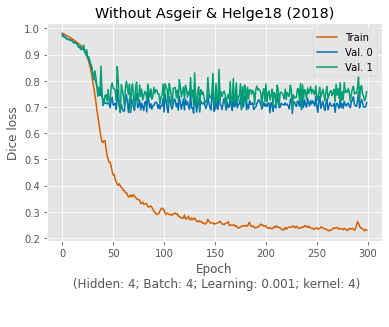

batch_size = 4 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.982156 -- Val. Loss 0: 0.975884 -- Val. Loss 1: 0.969470
Epoch 0025 -- Train Loss : 0.938753 -- Val. Loss 0: 0.937462 -- Val. Loss 1: 0.924982
Epoch 0050 -- Train Loss : 0.739162 -- Val. Loss 0: 0.849831 -- Val. Loss 1: 0.855891
Epoch 0075 -- Train Loss : 0.634363 -- Val. Loss 0: 0.791290 -- Val. Loss 1: 0.773081
Epoch 0100 -- Train Loss : 0.528740 -- Val. Loss 0: 0.790147 -- Val. Loss 1: 0.761136
Epoch 0125 -- Train Loss : 0.475676 -- Val. Loss 0: 0.779397 -- Val. Loss 1: 0.765436
Epoch 0150 -- Train Loss : 0.439162 -- Val. Loss 0: 0.784189 -- Val. Loss 1: 0.784076
Epoch 0175 -- Train Loss : 0.395333 -- Val. Loss 0: 0.755253 -- Val. Loss 1: 0.735799
Epoch 0200 -- Train Loss : 0.388381 -- Val. Loss 0: 0.743434 -- Val. Loss 1: 0.716688
Epoch 0225 -- Train Loss : 0.361465 -- Val. Loss 0: 0.743607 -- Val. Loss 1: 0.712885
Epoch 0250 -- Train Loss : 0.345318 -- Val. Loss 0: 0.743500 -- Val. Loss 1: 0.723832
Epoch 0275 -- 

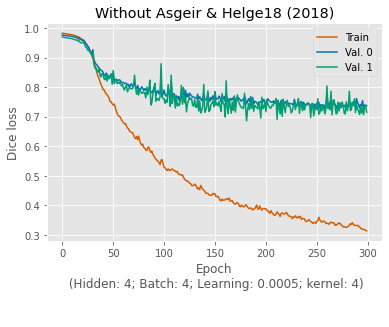

batch_size = 8 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.980323 -- Val. Loss 0: 0.977027 -- Val. Loss 1: 0.969549
Epoch 0025 -- Train Loss : 0.924796 -- Val. Loss 0: 0.926610 -- Val. Loss 1: 0.900140
Epoch 0050 -- Train Loss : 0.776167 -- Val. Loss 0: 0.881638 -- Val. Loss 1: 0.836436
Epoch 0075 -- Train Loss : 0.612372 -- Val. Loss 0: 0.680961 -- Val. Loss 1: 0.657200
Epoch 0100 -- Train Loss : 0.528397 -- Val. Loss 0: 0.656421 -- Val. Loss 1: 0.644366
Epoch 0125 -- Train Loss : 0.467011 -- Val. Loss 0: 0.785298 -- Val. Loss 1: 0.814269
Epoch 0150 -- Train Loss : 0.436238 -- Val. Loss 0: 0.737075 -- Val. Loss 1: 0.773626
Epoch 0175 -- Train Loss : 0.389752 -- Val. Loss 0: 0.694148 -- Val. Loss 1: 0.693767
Epoch 0200 -- Train Loss : 0.392129 -- Val. Loss 0: 0.691759 -- Val. Loss 1: 0.710805
Epoch 0225 -- Train Loss : 0.369639 -- Val. Loss 0: 0.822128 -- Val. Loss 1: 0.850469
Epoch 0250 -- Train Loss : 0.303319 -- Val. Loss 0: 0.794885 -- Val. Loss 1: 0.808732
Epoch 0275 -- Tr

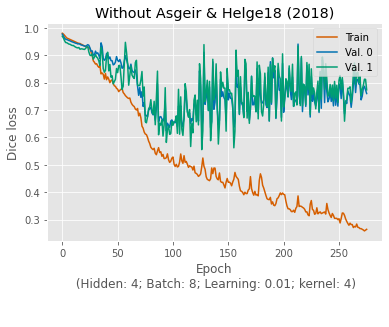

batch_size = 8 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.980294 -- Val. Loss 0: 0.977344 -- Val. Loss 1: 0.969747
Epoch 0025 -- Train Loss : 0.880148 -- Val. Loss 0: 0.908755 -- Val. Loss 1: 0.898090
Epoch 0050 -- Train Loss : 0.628088 -- Val. Loss 0: 0.715755 -- Val. Loss 1: 0.734724
Epoch 0075 -- Train Loss : 0.521966 -- Val. Loss 0: 0.665711 -- Val. Loss 1: 0.620867
Epoch 0100 -- Train Loss : 0.485004 -- Val. Loss 0: 0.726697 -- Val. Loss 1: 0.731475
Epoch 0125 -- Train Loss : 0.394290 -- Val. Loss 0: 0.676924 -- Val. Loss 1: 0.649936
Epoch 0150 -- Train Loss : 0.358415 -- Val. Loss 0: 0.673189 -- Val. Loss 1: 0.630535
Epoch 0175 -- Train Loss : 0.320080 -- Val. Loss 0: 0.683502 -- Val. Loss 1: 0.666293
Epoch 0200 -- Train Loss : 0.286675 -- Val. Loss 0: 0.693650 -- Val. Loss 1: 0.697538
Epoch 0225 -- Train Loss : 0.295285 -- Val. Loss 0: 0.717858 -- Val. Loss 1: 0.725379
Epoch 0250 -- Train Loss : 0.264728 -- Val. Loss 0: 0.691880 -- Val. Loss 1: 0.653603
Epoch 0275 -- T

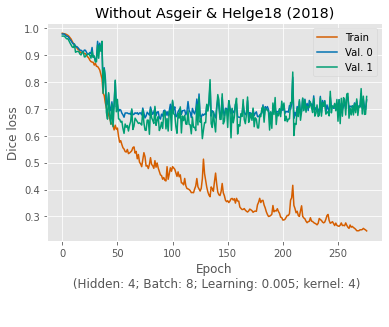

batch_size = 8 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.979254 -- Val. Loss 0: 0.977242 -- Val. Loss 1: 0.969615
Epoch 0025 -- Train Loss : 0.951470 -- Val. Loss 0: 0.963455 -- Val. Loss 1: 0.955096
Epoch 0050 -- Train Loss : 0.941626 -- Val. Loss 0: 0.955890 -- Val. Loss 1: 0.948166
Epoch 0075 -- Train Loss : 0.927561 -- Val. Loss 0: 0.963510 -- Val. Loss 1: 0.959575
Epoch 0100 -- Train Loss : 0.914820 -- Val. Loss 0: 0.948438 -- Val. Loss 1: 0.945014
Epoch 0125 -- Train Loss : 0.887986 -- Val. Loss 0: 0.954491 -- Val. Loss 1: 0.953542
Epoch 0150 -- Train Loss : 0.865269 -- Val. Loss 0: 0.942056 -- Val. Loss 1: 0.935340
Epoch 0175 -- Train Loss : 0.828755 -- Val. Loss 0: 0.944858 -- Val. Loss 1: 0.946507
Epoch 0200 -- Train Loss : 0.784896 -- Val. Loss 0: 0.931811 -- Val. Loss 1: 0.933326
Epoch 0225 -- Train Loss : 0.734862 -- Val. Loss 0: 0.928529 -- Val. Loss 1: 0.939189
Epoch 0250 -- Train Loss : 0.682823 -- Val. Loss 0: 0.918495 -- Val. Loss 1: 0.932620
Epoch 0275 -- T

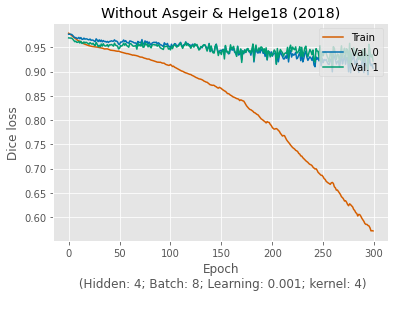

batch_size = 8 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.980806 -- Val. Loss 0: 0.977166 -- Val. Loss 1: 0.969404
Epoch 0025 -- Train Loss : 0.979003 -- Val. Loss 0: 0.975680 -- Val. Loss 1: 0.967624
Epoch 0050 -- Train Loss : 0.966724 -- Val. Loss 0: 0.966533 -- Val. Loss 1: 0.956454
Epoch 0075 -- Train Loss : 0.908101 -- Val. Loss 0: 0.959253 -- Val. Loss 1: 0.951529
Epoch 0100 -- Train Loss : 0.623015 -- Val. Loss 0: 0.949932 -- Val. Loss 1: 0.945673
Epoch 0125 -- Train Loss : 0.487381 -- Val. Loss 0: 0.944089 -- Val. Loss 1: 0.943857
Epoch 0150 -- Train Loss : 0.387231 -- Val. Loss 0: 0.952594 -- Val. Loss 1: 0.960856
Epoch 0175 -- Train Loss : 0.327269 -- Val. Loss 0: 0.934004 -- Val. Loss 1: 0.938594
Epoch 0200 -- Train Loss : 0.251776 -- Val. Loss 0: 0.939694 -- Val. Loss 1: 0.959663
Epoch 0225 -- Train Loss : 0.220195 -- Val. Loss 0: 0.946168 -- Val. Loss 1: 0.958212
Epoch 0250 -- Train Loss : 0.184513 -- Val. Loss 0: 0.927075 -- Val. Loss 1: 0.950325
Epoch 0275 -- 

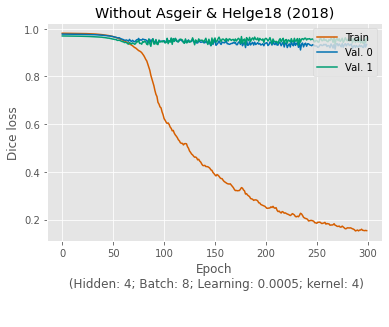

batch_size = 16 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.981430 -- Val. Loss 0: 0.977978 -- Val. Loss 1: 0.959708
Epoch 0025 -- Train Loss : 0.945082 -- Val. Loss 0: 0.946791 -- Val. Loss 1: 0.923607
Epoch 0050 -- Train Loss : 0.906400 -- Val. Loss 0: 0.920291 -- Val. Loss 1: 0.888786
Epoch 0075 -- Train Loss : 0.772993 -- Val. Loss 0: 0.881379 -- Val. Loss 1: 0.835947
Epoch 0100 -- Train Loss : 0.697961 -- Val. Loss 0: 0.836306 -- Val. Loss 1: 0.798258
Epoch 0125 -- Train Loss : 0.644145 -- Val. Loss 0: 0.834225 -- Val. Loss 1: 0.831151
Epoch 0150 -- Train Loss : 0.618824 -- Val. Loss 0: 0.813742 -- Val. Loss 1: 0.812795
Epoch 0175 -- Train Loss : 0.597398 -- Val. Loss 0: 0.883372 -- Val. Loss 1: 0.914322
Epoch 0200 -- Train Loss : 0.569873 -- Val. Loss 0: 0.845123 -- Val. Loss 1: 0.869851
Epoch 0225 -- Train Loss : 0.532691 -- Val. Loss 0: 0.880185 -- Val. Loss 1: 0.892879
Epoch 0250 -- Train Loss : 0.536276 -- Val. Loss 0: 0.848792 -- Val. Loss 1: 0.864076
Epoch 0275 -- T

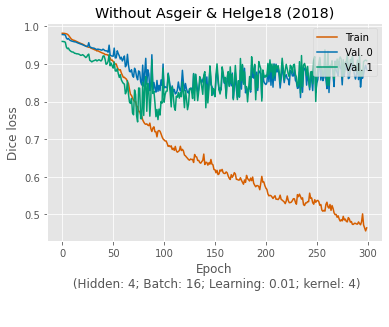

batch_size = 16 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.979142 -- Val. Loss 0: 0.977914 -- Val. Loss 1: 0.959482
Epoch 0025 -- Train Loss : 0.945449 -- Val. Loss 0: 0.943749 -- Val. Loss 1: 0.909958
Epoch 0050 -- Train Loss : 0.892719 -- Val. Loss 0: 0.909843 -- Val. Loss 1: 0.857263
Epoch 0075 -- Train Loss : 0.774042 -- Val. Loss 0: 0.872257 -- Val. Loss 1: 0.848768
Epoch 0100 -- Train Loss : 0.590894 -- Val. Loss 0: 0.781968 -- Val. Loss 1: 0.742564
Epoch 0125 -- Train Loss : 0.405313 -- Val. Loss 0: 0.731042 -- Val. Loss 1: 0.736229
Epoch 0150 -- Train Loss : 0.305577 -- Val. Loss 0: 0.730497 -- Val. Loss 1: 0.796146
Epoch 0175 -- Train Loss : 0.232930 -- Val. Loss 0: 0.677740 -- Val. Loss 1: 0.687583
Epoch 0200 -- Train Loss : 0.200247 -- Val. Loss 0: 0.729399 -- Val. Loss 1: 0.814313
Epoch 0225 -- Train Loss : 0.166024 -- Val. Loss 0: 0.732431 -- Val. Loss 1: 0.761526
Epoch 0250 -- Train Loss : 0.149510 -- Val. Loss 0: 0.676200 -- Val. Loss 1: 0.736145
Epoch 0275 -- 

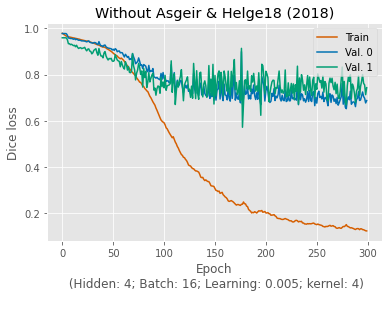

batch_size = 16 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.981436 -- Val. Loss 0: 0.978255 -- Val. Loss 1: 0.960739
Epoch 0025 -- Train Loss : 0.968654 -- Val. Loss 0: 0.967254 -- Val. Loss 1: 0.945157
Epoch 0050 -- Train Loss : 0.910116 -- Val. Loss 0: 0.931452 -- Val. Loss 1: 0.897715
Epoch 0075 -- Train Loss : 0.776259 -- Val. Loss 0: 0.888667 -- Val. Loss 1: 0.867648
Epoch 0100 -- Train Loss : 0.674924 -- Val. Loss 0: 0.876109 -- Val. Loss 1: 0.877006
Epoch 0125 -- Train Loss : 0.568777 -- Val. Loss 0: 0.847624 -- Val. Loss 1: 0.871576
Epoch 0150 -- Train Loss : 0.489974 -- Val. Loss 0: 0.838927 -- Val. Loss 1: 0.868854
Epoch 0175 -- Train Loss : 0.425999 -- Val. Loss 0: 0.840431 -- Val. Loss 1: 0.875213
Epoch 0200 -- Train Loss : 0.379478 -- Val. Loss 0: 0.837512 -- Val. Loss 1: 0.882634
Epoch 0225 -- Train Loss : 0.344664 -- Val. Loss 0: 0.816817 -- Val. Loss 1: 0.856371
Epoch 0250 -- Train Loss : 0.314493 -- Val. Loss 0: 0.814342 -- Val. Loss 1: 0.861759
Epoch 0275 -- 

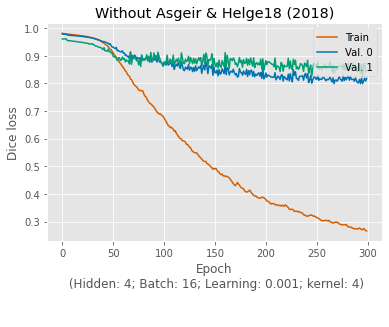

batch_size = 16 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.981908 -- Val. Loss 0: 0.977794 -- Val. Loss 1: 0.959163
Epoch 0025 -- Train Loss : 0.977743 -- Val. Loss 0: 0.974487 -- Val. Loss 1: 0.952741
Epoch 0050 -- Train Loss : 0.971252 -- Val. Loss 0: 0.969176 -- Val. Loss 1: 0.943571
Epoch 0075 -- Train Loss : 0.954839 -- Val. Loss 0: 0.956761 -- Val. Loss 1: 0.921759
Epoch 0100 -- Train Loss : 0.911440 -- Val. Loss 0: 0.945848 -- Val. Loss 1: 0.922088
Epoch 0125 -- Train Loss : 0.854179 -- Val. Loss 0: 0.948687 -- Val. Loss 1: 0.925575
Epoch 0150 -- Train Loss : 0.816708 -- Val. Loss 0: 0.952475 -- Val. Loss 1: 0.931126
Epoch 0175 -- Train Loss : 0.800320 -- Val. Loss 0: 0.944513 -- Val. Loss 1: 0.927258
Epoch 0200 -- Train Loss : 0.786834 -- Val. Loss 0: 0.950155 -- Val. Loss 1: 0.934246
Epoch 0225 -- Train Loss : 0.774586 -- Val. Loss 0: 0.943515 -- Val. Loss 1: 0.928548
Epoch 0250 -- Train Loss : 0.757226 -- Val. Loss 0: 0.945508 -- Val. Loss 1: 0.931256
Epoch 0275 --

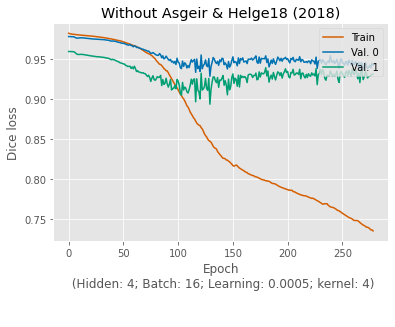

batch_size = 32 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.981429 -- Val. Loss 0: 0.973379 -- Val. Loss 1: 0.965531
Epoch 0025 -- Train Loss : 0.926772 -- Val. Loss 0: 0.918191 -- Val. Loss 1: 0.902758
Epoch 0050 -- Train Loss : 0.735505 -- Val. Loss 0: 0.742861 -- Val. Loss 1: 0.766992
Epoch 0075 -- Train Loss : 0.587314 -- Val. Loss 0: 0.765643 -- Val. Loss 1: 0.863805
Epoch 0100 -- Train Loss : 0.515588 -- Val. Loss 0: 0.691852 -- Val. Loss 1: 0.752353
Epoch 0125 -- Train Loss : 0.449097 -- Val. Loss 0: 0.658953 -- Val. Loss 1: 0.783866
Epoch 0150 -- Train Loss : 0.413544 -- Val. Loss 0: 0.666203 -- Val. Loss 1: 0.764304
Epoch 0175 -- Train Loss : 0.376464 -- Val. Loss 0: 0.683393 -- Val. Loss 1: 0.791529
Epoch 0200 -- Train Loss : 0.347300 -- Val. Loss 0: 0.692184 -- Val. Loss 1: 0.817786
Epoch 0225 -- Train Loss : 0.339599 -- Val. Loss 0: 0.699301 -- Val. Loss 1: 0.784799
Model isn't probably improved anymore, skip to next learning rate...



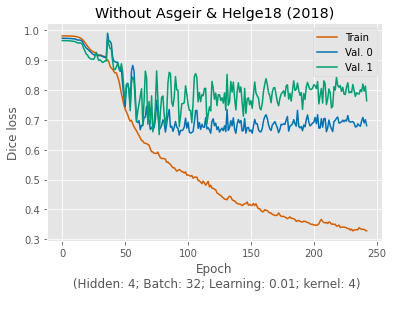

batch_size = 32 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.981529 -- Val. Loss 0: 0.973550 -- Val. Loss 1: 0.965838
Epoch 0025 -- Train Loss : 0.945589 -- Val. Loss 0: 0.938258 -- Val. Loss 1: 0.944843
Epoch 0050 -- Train Loss : 0.918437 -- Val. Loss 0: 0.909387 -- Val. Loss 1: 0.906588
Epoch 0075 -- Train Loss : 0.875389 -- Val. Loss 0: 0.885495 -- Val. Loss 1: 0.914013
Epoch 0100 -- Train Loss : 0.806748 -- Val. Loss 0: 0.860696 -- Val. Loss 1: 0.896448
Epoch 0125 -- Train Loss : 0.704820 -- Val. Loss 0: 0.783963 -- Val. Loss 1: 0.828209
Epoch 0150 -- Train Loss : 0.568703 -- Val. Loss 0: 0.747874 -- Val. Loss 1: 0.797346
Epoch 0175 -- Train Loss : 0.445912 -- Val. Loss 0: 0.736755 -- Val. Loss 1: 0.811005
Epoch 0200 -- Train Loss : 0.355931 -- Val. Loss 0: 0.687523 -- Val. Loss 1: 0.755426
Epoch 0225 -- Train Loss : 0.285609 -- Val. Loss 0: 0.678239 -- Val. Loss 1: 0.727127
Epoch 0250 -- Train Loss : 0.241775 -- Val. Loss 0: 0.677168 -- Val. Loss 1: 0.756170
Epoch 0275 -- 

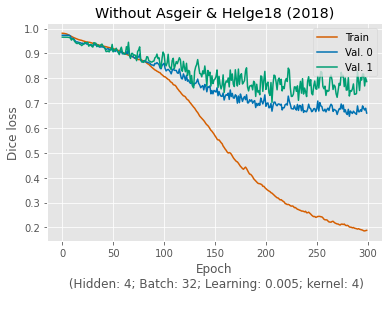

batch_size = 32 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.981160 -- Val. Loss 0: 0.973413 -- Val. Loss 1: 0.965619
Epoch 0025 -- Train Loss : 0.968398 -- Val. Loss 0: 0.968774 -- Val. Loss 1: 0.961481
Epoch 0050 -- Train Loss : 0.937434 -- Val. Loss 0: 0.959121 -- Val. Loss 1: 0.954362
Epoch 0075 -- Train Loss : 0.866411 -- Val. Loss 0: 0.934595 -- Val. Loss 1: 0.938152
Epoch 0100 -- Train Loss : 0.603285 -- Val. Loss 0: 0.861326 -- Val. Loss 1: 0.885294
Epoch 0125 -- Train Loss : 0.399073 -- Val. Loss 0: 0.861523 -- Val. Loss 1: 0.908779
Epoch 0150 -- Train Loss : 0.319862 -- Val. Loss 0: 0.836940 -- Val. Loss 1: 0.891204
Epoch 0175 -- Train Loss : 0.266685 -- Val. Loss 0: 0.826972 -- Val. Loss 1: 0.893425
Epoch 0200 -- Train Loss : 0.229953 -- Val. Loss 0: 0.805889 -- Val. Loss 1: 0.882503
Epoch 0225 -- Train Loss : 0.195948 -- Val. Loss 0: 0.789842 -- Val. Loss 1: 0.867860
Epoch 0250 -- Train Loss : 0.175387 -- Val. Loss 0: 0.804044 -- Val. Loss 1: 0.880483
Epoch 0275 -- 

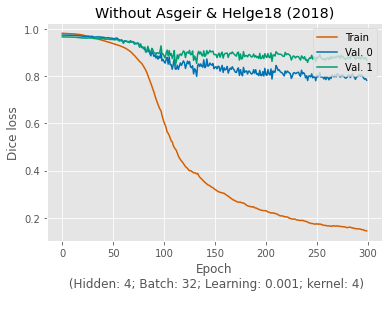

batch_size = 32 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.981139 -- Val. Loss 0: 0.973260 -- Val. Loss 1: 0.965409
Epoch 0025 -- Train Loss : 0.979427 -- Val. Loss 0: 0.970460 -- Val. Loss 1: 0.961501
Epoch 0050 -- Train Loss : 0.972974 -- Val. Loss 0: 0.967198 -- Val. Loss 1: 0.959221
Epoch 0075 -- Train Loss : 0.965969 -- Val. Loss 0: 0.967137 -- Val. Loss 1: 0.961198
Epoch 0100 -- Train Loss : 0.960758 -- Val. Loss 0: 0.967431 -- Val. Loss 1: 0.961615
Epoch 0125 -- Train Loss : 0.958053 -- Val. Loss 0: 0.967550 -- Val. Loss 1: 0.961812
Epoch 0150 -- Train Loss : 0.956182 -- Val. Loss 0: 0.967033 -- Val. Loss 1: 0.961608
Epoch 0175 -- Train Loss : 0.954678 -- Val. Loss 0: 0.966314 -- Val. Loss 1: 0.961191
Epoch 0200 -- Train Loss : 0.953188 -- Val. Loss 0: 0.965435 -- Val. Loss 1: 0.960422
Epoch 0225 -- Train Loss : 0.952583 -- Val. Loss 0: 0.962443 -- Val. Loss 1: 0.958104
Epoch 0250 -- Train Loss : 0.950170 -- Val. Loss 0: 0.963160 -- Val. Loss 1: 0.958689
Epoch 0275 --

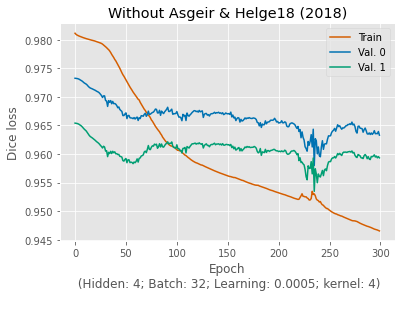

In [ ]:
import glob, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# saved_model = False
saved_model = True

no_improve_epoch = 150
# epochs = 7; epoch_print = 2
epoch_print = 25

trLoss = np.zeros(epochs)
vlLoss_0 = np.zeros(epochs)
vlLoss_1 = np.zeros(epochs)

# https://stackoverflow.com/a/31675177
res = ['hidden_unit', 'batch_size', 'learning_rate', 'min_val_0', 'min_val_1', 
        'min_index_0', 'min_index_1', 'n_part', 'epochs', 'e', 'n_kernel']

bs = 0
while bs < len(Batch_size) :

  batch_size = Batch_size[bs]
  lr = 0
  while lr < len(Learning_rate):

    min_val_0 = sys.float_info.max; min_index_0 = -1
    min_val_1 = sys.float_info.max; min_index_1 = -1

    learning_rate = Learning_rate[lr]
    print('batch_size = ' + str(batch_size) + ' ; learning_rate = ' + str(learning_rate))

    net = UTime(in_channels = C, out_channels = 1, n_fillter = hidden_unit, n_kernel=n_kernel)
    net.cuda()
    net.zero_grad() # Zero the network gradients

    # https://pytorch.org/docs/stable/optim.html#constructing-it
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Run model
    for epoch in range(epochs):
      
      batchLoss = 0
      nBatch = int(nTrain/batch_size)
      
      net.train()
      for i in range(nBatch+1): 
        if i == nBatch:
          X = x_train[-batch_size:]; Y = y_train[-batch_size:]
        else:
          X = x_train[i*batch_size:(i+1)*batch_size]
          Y = y_train[i*batch_size:(i+1)*batch_size]
            
        optimizer.zero_grad() # 1) clear previous gradient computation
        # https://stackoverflow.com/q/57237352
        Y_pred = net(X) # 2) forward propagation
        output = criterion(Y_pred, Y) # 3) calculate the loss
        output.backward() # 4) backpropagate to compute gradients
        batchLoss += output
        
        optimizer.step() # 5) update model weights
      # end for loop
      
      trLoss[epoch] = batchLoss/(nBatch+1)
      
      # Compute validation loss/Enter eval mode
      net.eval()
      
      # Validtion as 0th element
      x_val = x_w[ test_whale[0] ]; y_val = y_w[ test_whale[0] ]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_0[epoch] = batchLoss/(nBatch+1)

      # Validtion as 1st element
      x_val = x_w[ test_whale[1] ]; y_val = y_w[ test_whale[1] ]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_1[epoch] = batchLoss/(nBatch+1)


      if (epoch % epoch_print == 0.0):
        print( "Epoch {e:04d} -- Train Loss : {l:2.6f} -- Val. Loss 0: {v0:2.6f} -- Val. Loss 1: {v1:2.6f}".format
              (e=epoch,l=trLoss[epoch], v0=vlLoss_0[epoch], v1=vlLoss_1[epoch]) )
      
      # Validtion as 0th element
      if (min_val_0 > vlLoss_0[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_0 = vlLoss_0[epoch]
        min_index_0 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_0, 'min_index':min_index_0 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      
      # Validtion as 1st element
      if (min_val_1 > vlLoss_1[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_1 = vlLoss_1[epoch]
        min_index_1 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_1, 'min_index':min_index_1 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      else:
        if epoch >= ( max(min_index_0,min_index_1) + no_improve_epoch ) :
          print("Model isn't probably improved anymore, skip to next learning rate...\n")
          break

    torch.cuda.empty_cache() # https://stackoverflow.com/a/55340037

    # # Prediction
    del net, optimizer  # https://stackoverflow.com/a/53353203
    torch.cuda.empty_cache()

    plt.plot(trLoss[:epoch], color='#D55E00' )
    plt.plot(vlLoss_0[:epoch], color='#0072B2' )
    plt.plot(vlLoss_1[:epoch], color='#009E73' )
    plt.title('Without ' + extract_name(all_files[test_whale[0]]) + ' & ' + 
              extract_name(all_files[test_whale[1]]) +' (2018)')

    plt.ylabel('Dice loss')
    plt.xlabel('Epoch\n (Hidden: ' + str(hidden_unit) + '; Batch: ' + str(batch_size) + '; Learning: ' + 
               str(learning_rate) + '; kernel: ' + str(n_kernel) + ')\n\n' )
    plt.legend(['Train', 'Val. 0', 'Val. 1'], loc='upper right')
    if saved_model :
      plt.savefig('data/model/whale/U-Time_7/' + whale_name + '/plot/' + model_name + '_diceloss.svg', 
                  format="svg", figsize=(12, 8), bbox_inches='tight')
    plt.show()
    res = np.c_[res, np.r_[hidden_unit, batch_size, learning_rate, 
                           min_val_0,  min_val_1, min_index_0,min_index_1,
                           round(T/(60*e),2), epochs, e, n_kernel]]

    lr += 1

  bs += 1


In [ ]:
import pandas as pd
dt = pd.DataFrame(res.transpose()[1:,], columns=res.transpose()[0,:])
dt.sort_values(['min_val_0','min_val_1'])

hidden_unit batch_size learning_rate  ... epochs     e n_kernel
8          4.0        8.0          0.01  ...  301.0  10.0      4.0
4          4.0        4.0          0.01  ...  301.0  10.0      4.0
1          4.0        2.0         0.005  ...  301.0  10.0      4.0
17         4.0       32.0         0.005  ...  301.0  10.0      4.0
16         4.0       32.0          0.01  ...  301.0  10.0      4.0
13         4.0       16.0         0.005  ...  301.0  10.0      4.0
5          4.0        4.0         0.005  ...  301.0  10.0      4.0
9          4.0        8.0         0.005  ...  301.0  10.0      4.0
6          4.0        4.0         0.001  ...  301.0  10.0      4.0
2          4.0        2.0         0.001  ...  301.0  10.0      4.0
7          4.0        4.0        0.0005  ...  301.0  10.0      4.0
3          4.0        2.0        0.0005  ...  301.0  10.0      4.0
18         4.0       32.0         0.001  ...  301.0  10.0      4.0
14         4.0       16.0         0.001  ...  301.0  10.0      4.0
12         4.0       16.0          0.01  ...  301.0  10.0      4.0
0          4.0        2.0          0.01  ...  301.0  10.0      4.0
10         4.0        8.0         0.001  ...  301.0  10.0      4.0
11         4.0        8.0        0.0005  ...  301.0  10.0      4.0
15         4.0       16.0        0.0005  ...  301.0  10.0      4.0
19         4.0       32.0        0.0005  ...  301.0  10.0      4.0

[20 rows x 11 columns]

### Plot and prediction

In [26]:
# Load saved model using GPU/CPU
envr = 'cuda'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 8
learning_rate = 0.01
epoch = 94

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel) + \
                    '_' + str(test_whale[0]) + str(test_whale[1])

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))

x_test = x_w[1]; y_test = y_w[1]

with torch.no_grad():
  y = model(x_test)

y = concat_overlap(y, accel[test_whale[1]].shape[0]%L).numpy()
y_t = concat_overlap(y_test, accel[test_whale[1]].shape[0]%L).numpy()

In [28]:
# Test on all whales combined

Ind = X_all[ :,-1].copy().astype(np.int64)

with torch.no_grad():
  y_a = model(x_all)
# y_a = concat_overlap(y_a, Ind-Ind.min())
y_a = y_a[0,:].numpy()

y_t_all = y_all
y_t_all = concat_overlap(y_t_all, Ind-Ind.min())
y_t_all = y_t_all.numpy()

In [35]:
from collections import Counter
C_t = consecutive(y_t_all)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,14) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y_a, y_t_all, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y_a, y_t_all, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t_all, y_a),2) )
L0.append( round(roc_auc_score(y_t_all, y_a),2) )
L0.append(sum([ accel[i].shape[0] for i in train_whale ]))
Res[0,:] = np.ravel(L0)

Res

array([[       0.18,        0.51,        0.58,        0.62,        0.63,        0.63,        0.64,        0.66,
               0.67,        0.7 ,        0.71,        0.28,        0.92, 20642200.  ]])

In [43]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + ''.join( str(v) for v in train_whale) + '.txt', 
                index=False )
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
from collections import Counter

print(y_t.sum()/y_t.shape[0]*100)
print(extract_name(all_files[test_whale[1]]))
print(Counter(y_t))

1.7676621160409558
Helge18
Counter({0.0: 11512830, 1.0: 207170})


In [ ]:
from collections import Counter
C_t = consecutive(y_t)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,13) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y, y_t, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y, y_t, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t, y),2) )
L0.append( round(roc_auc_score(y_t, y),2) )
Res[0,:] = np.ravel(L0)

In [36]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + whale_test + '.txt', 
                index=False )

#### Etc.

In [ ]:
def miss_ratio(x, y0, overlap ) :
  with torch.no_grad():
    Y = model(x)
  # pdb.set_trace()
  y = concat_overlap(Y, overlap)
  # del Y
  y_t = concat_overlap( y0, overlap )
  return missed_rate( y, y_t, 100 )

def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))


In [ ]:
for i in test_whale :
  r = miss_ratio(x_w[i], y_w[i], accel[i].shape[0]%L )
  w_name = extract_name(all_files[i])
  print( w_name , r )

Asgeir 0.7894736842105263
Helge18 0.7886363636363637
Nemo 0.6903553299492385
Siggi 0.8269230769230769


In [ ]:
with torch.no_grad():
  y = model(x_val)

criterion(y_val,y)

tensor(0.6814)

In [ ]:
with torch.no_grad():
  y = model(x_test)

criterion(y_test,y)

tensor(0.3695)

In [ ]:
def concat_overlap(y, ovl):
  if y.shape[0] <= 1:
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))


y = concat_overlap(y, a3.shape[0] % L)
# y = y.detach().cpu().numpy().T
y_t = concat_overlap(y_test, a3.shape[0] % L)

missed_rate( y, y_t, 100 )

In [ ]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))


for i in test_whale :
  with torch.no_grad():
    y = model(x_w[i])
  overlap = accel[i].shape[0]%L
  y = concat_overlap(y, overlap)
  y_t = concat_overlap( y_w[i], overlap )
  
  print( extract_name(all_files[i]) , missed_rate( y, y_t, 100 ))


# 1. Helge18

In [44]:
w = 1
test_whale = [ w, (w+1)%len(all_files) ]
print(test_whale)

whale_name = extract_name(all_files[test_whale[0]])
print(whale_name)

accel[w]

[1, 2]
Helge18


DateTime      AccX       AccY  ...  Dive_no    whale  buzz
0        2018-08-24 21:35:49  70.31250  152.34375  ...     -100  Helge18     0
1                        NaT  78.12500  144.53125  ...     -100  Helge18     0
2                        NaT  78.12500  144.53125  ...     -100  Helge18     0
3                        NaT  78.12500  140.62500  ...     -100  Helge18     0
4                        NaT  85.93750  144.53125  ...     -100  Helge18     0
...                      ...       ...        ...  ...      ...      ...   ...
11719995                 NaT   0.00000 -507.81250  ...     -211  Helge18     0
11719996                 NaT   0.00000 -500.00000  ...     -211  Helge18     0
11719997                 NaT -15.62500 -503.90625  ...     -211  Helge18     0
11719998                 NaT -42.96875 -507.81250  ...     -211  Helge18     0
11719999 2018-08-26 06:09:08 -54.68750 -492.18750  ...     -211  Helge18     0

[11720000 rows x 13 columns]

In [45]:
train_whale = list(range(len(all_files)))
train_whale.remove(w)
train_whale.remove( (w+1)%len(all_files) )
print(train_whale)

[0, 3, 4]


In [46]:
# 2: validation & test
x_whale = [None]*2
y_whale = [None]*2
x_w = [None]*2
y_w = [None]*2

for i in range(2) :
    x_whale[i] = accel[test_whale[i]].iloc[:,1:(1+C)].to_numpy()
    y_whale[i] = accel[test_whale[i]].iloc[:,-1].to_numpy()
    x_w[i], y_w[i] = make_dataset(x_whale[i], y_whale[i], overlap=0, win_shape=(L,C) )
    x_w[i] = x_w[i].swapaxes(1,2)

# x_whale = accel[w].iloc[:,1:(1+C)].to_numpy()
# y_whale = accel[w].iloc[:,-1].to_numpy()
# x_w, y_w = make_dataset(x_whale, y_whale, overlap=0, win_shape=(L,C) )
# x_w = x_w.swapaxes(1,2)

In [47]:
# https://stackoverflow.com/a/42376244
X_train, Y_train = map(list, zip(*[split_dataset(accel[i], no_val=True) for i in train_whale ]))
# n_elem_test = np.ravel([x.shape[0] for x in X_test])
# n_elem_test = np.append(0, n_elem_test).cumsum()

In [48]:
X_train = np.concatenate( X_train )
Y_train = np.concatenate( Y_train )
# X_val = np.concatenate( X_val )
# Y_val = np.concatenate( Y_val )

In [49]:
# https://datascience.stackexchange.com/a/27616
# https://datascience.stackexchange.com/a/12346
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if (X_train.shape[1] == C+1):
    for i in range(C):
        X_train[:,i,:] = scaler.fit_transform( X_train[:,i,:] )
        # X_val[:,i,:]   = scaler.transform( X_val[:,i,:] )
        for k in range(2) :
            x_w[k][:,i,:] = scaler.transform( x_w[k][:,i,:] )
    print('Normalize column 1')
if (X_train.shape[2] == C+1):
    for i in range(C):
        X_train[:,:,i] = scaler.fit_transform( X_train[:,:,i] )
        # X_val[:,:,i]   = scaler.transform( X_val[:,:,i] )
        for k in range(2) :
            x_w[k][:,:,i] = scaler.transform( x_w[k][:,:,i] )
    print('Normalize column 2')

Normalize column 1


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for i in range(2) :
    x_w[i] = torch.FloatTensor(x_w[i].astype(np.float32))
    y_w[i] = torch.FloatTensor(y_w[i].astype(np.float32))
    x_w[i] = x_w[i].to(device)
    y_w[i] = y_w[i].to(device)


# Importing gc module
import gc ; gc.collect()

nTrain = len(X_train)
# nVal = len(X_val)

cpu


In [51]:
print(test_whale[0])
print(test_whale[1])

print(len(x_w[0]))
print(len(x_w[1]))

1
2
33
39


In [52]:
x_train = X_train[:,0:C,:].astype(np.float32); y_train = Y_train
# x_val = X_val[:,0:C,:].astype(np.float32); y_val = Y_val
# x_test = X_test[:,0:C,:].astype(np.float32); y_test = Y_test

# Load training data as torch float tensors
x_train = torch.FloatTensor(x_train) # Input
y_train = torch.FloatTensor(y_train) # Target
x_train = x_train.to(device)
y_train = y_train.to(device)

# x_val = torch.FloatTensor(x_val) # Input
# y_val = torch.FloatTensor(y_val) # Target
# x_test = torch.FloatTensor(x_w) # Input
# y_test = torch.FloatTensor(y_w) # Target

# x_val = x_val.to(device)
# y_val = y_val.to(device)
# x_test = x_test.to(device)
# y_test = y_test.to(device)

### Train model

In [ ]:
import os
epochs = N_EPOCH

print(nTrain) # print(nVal)
print(x_train.shape) # print(x_val.shape)

58
torch.Size([58, 8, 360000])


In [ ]:
hidden_unit = 4 # Hidden units
n_kernel = 4

Batch_size = [2**x for x in range(1,11)] # https://datascience.stackexchange.com/a/20193
Batch_size = [x for x in Batch_size \
              if x <= min(nTrain, len(x_w[0]), len(x_w[1])) ]

Batch_size

[2, 4, 8, 16, 32]

batch_size = 2 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.971880 -- Val. Loss 0: 0.959375 -- Val. Loss 1: 0.979637
Epoch 0025 -- Train Loss : 0.899702 -- Val. Loss 0: 0.887447 -- Val. Loss 1: 0.916072
Epoch 0050 -- Train Loss : 0.875871 -- Val. Loss 0: 0.869525 -- Val. Loss 1: 0.844176
Epoch 0075 -- Train Loss : 0.836086 -- Val. Loss 0: 0.843546 -- Val. Loss 1: 0.835382
Epoch 0100 -- Train Loss : 0.760154 -- Val. Loss 0: 0.739901 -- Val. Loss 1: 0.782790
Epoch 0125 -- Train Loss : 0.701738 -- Val. Loss 0: 0.650653 -- Val. Loss 1: 0.628790
Epoch 0150 -- Train Loss : 0.712566 -- Val. Loss 0: 0.568025 -- Val. Loss 1: 0.570034
Epoch 0175 -- Train Loss : 0.670475 -- Val. Loss 0: 0.591082 -- Val. Loss 1: 0.538811
Epoch 0200 -- Train Loss : 0.675241 -- Val. Loss 0: 0.651433 -- Val. Loss 1: 0.570357
Epoch 0225 -- Train Loss : 0.660862 -- Val. Loss 0: 0.579869 -- Val. Loss 1: 0.466614
Epoch 0250 -- Train Loss : 0.681324 -- Val. Loss 0: 0.673340 -- Val. Loss 1: 0.776899
Epoch 0275 -- Tr

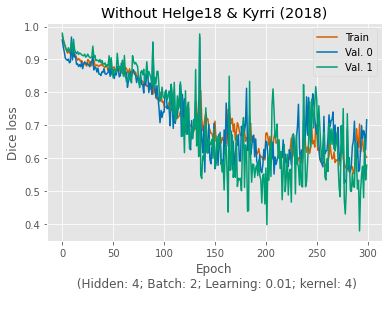

batch_size = 2 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.973180 -- Val. Loss 0: 0.968062 -- Val. Loss 1: 0.984865
Epoch 0025 -- Train Loss : 0.787978 -- Val. Loss 0: 0.814829 -- Val. Loss 1: 0.841358
Epoch 0050 -- Train Loss : 0.696648 -- Val. Loss 0: 0.728508 -- Val. Loss 1: 0.823022
Epoch 0075 -- Train Loss : 0.672765 -- Val. Loss 0: 0.739763 -- Val. Loss 1: 0.784867
Epoch 0100 -- Train Loss : 0.629875 -- Val. Loss 0: 0.785713 -- Val. Loss 1: 0.702127
Epoch 0125 -- Train Loss : 0.586500 -- Val. Loss 0: 0.691000 -- Val. Loss 1: 0.789398
Epoch 0150 -- Train Loss : 0.637356 -- Val. Loss 0: 0.718630 -- Val. Loss 1: 0.586194
Epoch 0175 -- Train Loss : 0.553501 -- Val. Loss 0: 0.618097 -- Val. Loss 1: 0.612137
Epoch 0200 -- Train Loss : 0.534227 -- Val. Loss 0: 0.620537 -- Val. Loss 1: 0.681058
Epoch 0225 -- Train Loss : 0.512490 -- Val. Loss 0: 0.696111 -- Val. Loss 1: 0.796633
Epoch 0250 -- Train Loss : 0.492681 -- Val. Loss 0: 0.705968 -- Val. Loss 1: 0.531552
Epoch 0275 -- T

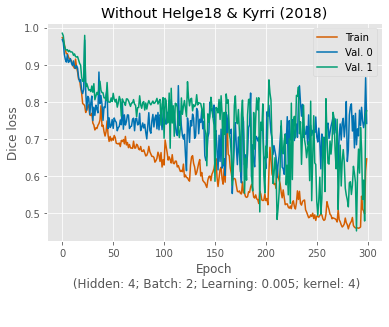

batch_size = 2 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.973200 -- Val. Loss 0: 0.968524 -- Val. Loss 1: 0.986256
Epoch 0025 -- Train Loss : 0.944526 -- Val. Loss 0: 0.945887 -- Val. Loss 1: 0.973256
Epoch 0050 -- Train Loss : 0.908737 -- Val. Loss 0: 0.925178 -- Val. Loss 1: 0.960573
Epoch 0075 -- Train Loss : 0.848927 -- Val. Loss 0: 0.898592 -- Val. Loss 1: 0.941042
Epoch 0100 -- Train Loss : 0.752182 -- Val. Loss 0: 0.897371 -- Val. Loss 1: 0.935766
Epoch 0125 -- Train Loss : 0.635958 -- Val. Loss 0: 0.886284 -- Val. Loss 1: 0.924763
Epoch 0150 -- Train Loss : 0.543381 -- Val. Loss 0: 0.912678 -- Val. Loss 1: 0.937572
Epoch 0175 -- Train Loss : 0.437525 -- Val. Loss 0: 0.880543 -- Val. Loss 1: 0.923469
Epoch 0200 -- Train Loss : 0.348136 -- Val. Loss 0: 0.912464 -- Val. Loss 1: 0.939109
Epoch 0225 -- Train Loss : 0.270638 -- Val. Loss 0: 0.895361 -- Val. Loss 1: 0.932700
Epoch 0250 -- Train Loss : 0.249057 -- Val. Loss 0: 0.930850 -- Val. Loss 1: 0.942673
Epoch 0275 -- T

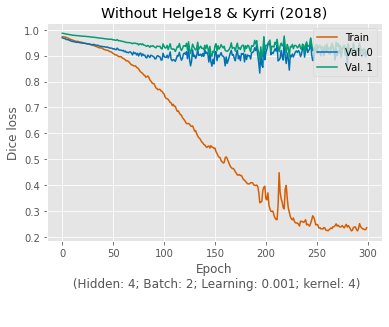

batch_size = 2 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.973366 -- Val. Loss 0: 0.968568 -- Val. Loss 1: 0.986244
Epoch 0025 -- Train Loss : 0.957834 -- Val. Loss 0: 0.960252 -- Val. Loss 1: 0.980637
Epoch 0050 -- Train Loss : 0.949966 -- Val. Loss 0: 0.958947 -- Val. Loss 1: 0.978770
Epoch 0075 -- Train Loss : 0.937752 -- Val. Loss 0: 0.956482 -- Val. Loss 1: 0.977108
Epoch 0100 -- Train Loss : 0.921906 -- Val. Loss 0: 0.956822 -- Val. Loss 1: 0.976838
Epoch 0125 -- Train Loss : 0.902876 -- Val. Loss 0: 0.950712 -- Val. Loss 1: 0.971411
Epoch 0150 -- Train Loss : 0.872276 -- Val. Loss 0: 0.948236 -- Val. Loss 1: 0.968999
Epoch 0175 -- Train Loss : 0.837214 -- Val. Loss 0: 0.946402 -- Val. Loss 1: 0.962494
Epoch 0200 -- Train Loss : 0.795807 -- Val. Loss 0: 0.955359 -- Val. Loss 1: 0.966840
Epoch 0225 -- Train Loss : 0.745513 -- Val. Loss 0: 0.949307 -- Val. Loss 1: 0.956659
Epoch 0250 -- Train Loss : 0.694021 -- Val. Loss 0: 0.944926 -- Val. Loss 1: 0.953612
Epoch 0275 -- 

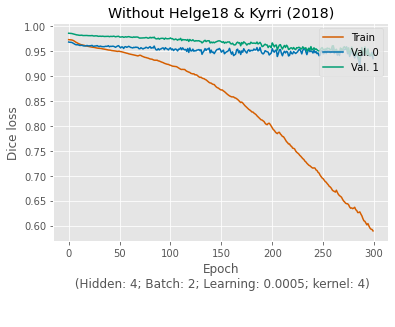

batch_size = 4 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.972296 -- Val. Loss 0: 0.961798 -- Val. Loss 1: 0.981477
Epoch 0025 -- Train Loss : 0.646502 -- Val. Loss 0: 0.629224 -- Val. Loss 1: 0.716324
Epoch 0050 -- Train Loss : 0.610628 -- Val. Loss 0: 0.587051 -- Val. Loss 1: 0.684552
Epoch 0075 -- Train Loss : 0.583256 -- Val. Loss 0: 0.565127 -- Val. Loss 1: 0.680264
Epoch 0100 -- Train Loss : 0.594934 -- Val. Loss 0: 0.685311 -- Val. Loss 1: 0.713123
Epoch 0125 -- Train Loss : 0.574762 -- Val. Loss 0: 0.600478 -- Val. Loss 1: 0.700072
Epoch 0150 -- Train Loss : 0.559343 -- Val. Loss 0: 0.636053 -- Val. Loss 1: 0.544697
Epoch 0175 -- Train Loss : 0.497596 -- Val. Loss 0: 0.606687 -- Val. Loss 1: 0.576257
Epoch 0200 -- Train Loss : 0.483854 -- Val. Loss 0: 0.632437 -- Val. Loss 1: 0.619171
Epoch 0225 -- Train Loss : 0.488653 -- Val. Loss 0: 0.582176 -- Val. Loss 1: 0.690212
Epoch 0250 -- Train Loss : 0.492375 -- Val. Loss 0: 0.599480 -- Val. Loss 1: 0.595172
Epoch 0275 -- Tr

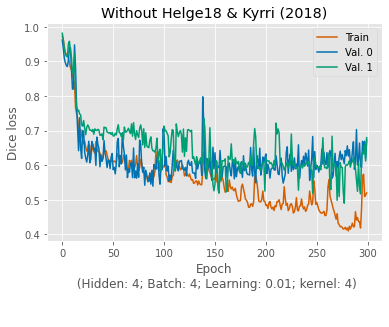

batch_size = 4 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.974944 -- Val. Loss 0: 0.969790 -- Val. Loss 1: 0.985839
Epoch 0025 -- Train Loss : 0.886799 -- Val. Loss 0: 0.888276 -- Val. Loss 1: 0.905586
Epoch 0050 -- Train Loss : 0.705765 -- Val. Loss 0: 0.756402 -- Val. Loss 1: 0.774772
Epoch 0075 -- Train Loss : 0.636509 -- Val. Loss 0: 0.686904 -- Val. Loss 1: 0.743521
Epoch 0100 -- Train Loss : 0.595772 -- Val. Loss 0: 0.693854 -- Val. Loss 1: 0.727051
Epoch 0125 -- Train Loss : 0.553055 -- Val. Loss 0: 0.664970 -- Val. Loss 1: 0.691189
Epoch 0150 -- Train Loss : 0.559953 -- Val. Loss 0: 0.685851 -- Val. Loss 1: 0.681125
Epoch 0175 -- Train Loss : 0.531976 -- Val. Loss 0: 0.663134 -- Val. Loss 1: 0.665504
Epoch 0200 -- Train Loss : 0.482618 -- Val. Loss 0: 0.666204 -- Val. Loss 1: 0.670291
Epoch 0225 -- Train Loss : 0.456778 -- Val. Loss 0: 0.684043 -- Val. Loss 1: 0.675141
Epoch 0250 -- Train Loss : 0.436026 -- Val. Loss 0: 0.738922 -- Val. Loss 1: 0.715991
Epoch 0275 -- T

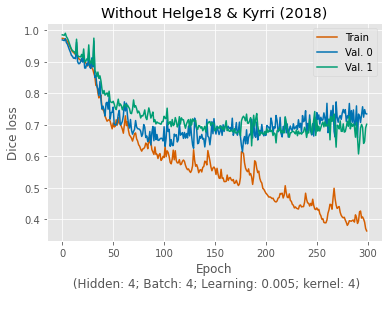

batch_size = 4 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.974922 -- Val. Loss 0: 0.969640 -- Val. Loss 1: 0.986208
Epoch 0025 -- Train Loss : 0.943327 -- Val. Loss 0: 0.951440 -- Val. Loss 1: 0.972761
Epoch 0050 -- Train Loss : 0.919557 -- Val. Loss 0: 0.941815 -- Val. Loss 1: 0.965019
Epoch 0075 -- Train Loss : 0.890608 -- Val. Loss 0: 0.942243 -- Val. Loss 1: 0.962283
Epoch 0100 -- Train Loss : 0.844107 -- Val. Loss 0: 0.938360 -- Val. Loss 1: 0.952259
Epoch 0125 -- Train Loss : 0.785882 -- Val. Loss 0: 0.924045 -- Val. Loss 1: 0.937013
Epoch 0150 -- Train Loss : 0.704511 -- Val. Loss 0: 0.911151 -- Val. Loss 1: 0.925378
Epoch 0175 -- Train Loss : 0.627184 -- Val. Loss 0: 0.924259 -- Val. Loss 1: 0.929949
Epoch 0200 -- Train Loss : 0.540761 -- Val. Loss 0: 0.902416 -- Val. Loss 1: 0.904170
Epoch 0225 -- Train Loss : 0.475288 -- Val. Loss 0: 0.912884 -- Val. Loss 1: 0.908675
Epoch 0250 -- Train Loss : 0.404959 -- Val. Loss 0: 0.890056 -- Val. Loss 1: 0.887825
Epoch 0275 -- T

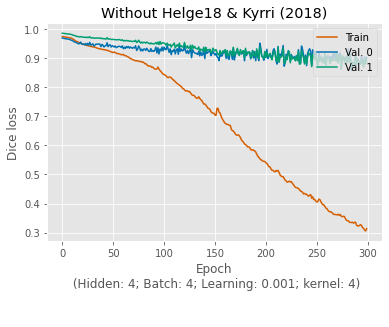

batch_size = 4 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.975658 -- Val. Loss 0: 0.971125 -- Val. Loss 1: 0.986456
Epoch 0025 -- Train Loss : 0.951219 -- Val. Loss 0: 0.949759 -- Val. Loss 1: 0.973157
Epoch 0050 -- Train Loss : 0.816329 -- Val. Loss 0: 0.919927 -- Val. Loss 1: 0.933731
Epoch 0075 -- Train Loss : 0.670932 -- Val. Loss 0: 0.928938 -- Val. Loss 1: 0.926858
Epoch 0100 -- Train Loss : 0.583470 -- Val. Loss 0: 0.919914 -- Val. Loss 1: 0.910872
Epoch 0125 -- Train Loss : 0.484053 -- Val. Loss 0: 0.921577 -- Val. Loss 1: 0.911406
Epoch 0150 -- Train Loss : 0.406044 -- Val. Loss 0: 0.922347 -- Val. Loss 1: 0.911826
Epoch 0175 -- Train Loss : 0.379691 -- Val. Loss 0: 0.942810 -- Val. Loss 1: 0.922340
Epoch 0200 -- Train Loss : 0.327367 -- Val. Loss 0: 0.905084 -- Val. Loss 1: 0.892303
Epoch 0225 -- Train Loss : 0.291463 -- Val. Loss 0: 0.904094 -- Val. Loss 1: 0.883647
Epoch 0250 -- Train Loss : 0.273680 -- Val. Loss 0: 0.907738 -- Val. Loss 1: 0.898066
Epoch 0275 -- 

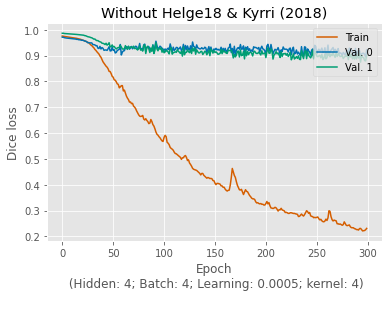

batch_size = 8 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.972176 -- Val. Loss 0: 0.968496 -- Val. Loss 1: 0.985545
Epoch 0025 -- Train Loss : 0.803743 -- Val. Loss 0: 0.805441 -- Val. Loss 1: 0.865993
Epoch 0050 -- Train Loss : 0.621871 -- Val. Loss 0: 0.644923 -- Val. Loss 1: 0.674152
Epoch 0075 -- Train Loss : 0.544315 -- Val. Loss 0: 0.598354 -- Val. Loss 1: 0.617118
Epoch 0100 -- Train Loss : 0.499153 -- Val. Loss 0: 0.551005 -- Val. Loss 1: 0.580239
Epoch 0125 -- Train Loss : 0.466234 -- Val. Loss 0: 0.575109 -- Val. Loss 1: 0.596853
Epoch 0150 -- Train Loss : 0.421391 -- Val. Loss 0: 0.642077 -- Val. Loss 1: 0.611886
Epoch 0175 -- Train Loss : 0.398229 -- Val. Loss 0: 0.657954 -- Val. Loss 1: 0.665943
Epoch 0200 -- Train Loss : 0.378785 -- Val. Loss 0: 0.604102 -- Val. Loss 1: 0.643826
Epoch 0225 -- Train Loss : 0.337347 -- Val. Loss 0: 0.689433 -- Val. Loss 1: 0.688579
Epoch 0250 -- Train Loss : 0.290123 -- Val. Loss 0: 0.651578 -- Val. Loss 1: 0.644967
Epoch 0275 -- Tr

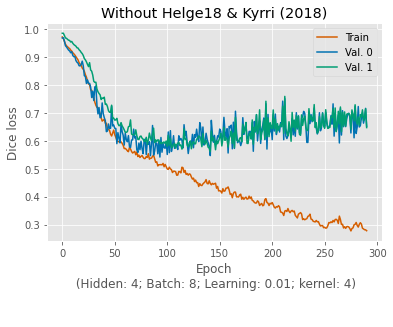

batch_size = 8 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.973864 -- Val. Loss 0: 0.970082 -- Val. Loss 1: 0.986329
Epoch 0025 -- Train Loss : 0.919430 -- Val. Loss 0: 0.891775 -- Val. Loss 1: 0.918067
Epoch 0050 -- Train Loss : 0.678315 -- Val. Loss 0: 0.804559 -- Val. Loss 1: 0.747701
Epoch 0075 -- Train Loss : 0.615101 -- Val. Loss 0: 0.668961 -- Val. Loss 1: 0.686886
Epoch 0100 -- Train Loss : 0.549753 -- Val. Loss 0: 0.634572 -- Val. Loss 1: 0.650211
Epoch 0125 -- Train Loss : 0.518098 -- Val. Loss 0: 0.653389 -- Val. Loss 1: 0.611357
Epoch 0150 -- Train Loss : 0.479314 -- Val. Loss 0: 0.705062 -- Val. Loss 1: 0.625597
Epoch 0175 -- Train Loss : 0.436366 -- Val. Loss 0: 0.700714 -- Val. Loss 1: 0.630096
Epoch 0200 -- Train Loss : 0.399271 -- Val. Loss 0: 0.743950 -- Val. Loss 1: 0.674752
Epoch 0225 -- Train Loss : 0.364985 -- Val. Loss 0: 0.802239 -- Val. Loss 1: 0.724576
Epoch 0250 -- Train Loss : 0.325648 -- Val. Loss 0: 0.800310 -- Val. Loss 1: 0.730066
Epoch 0275 -- T

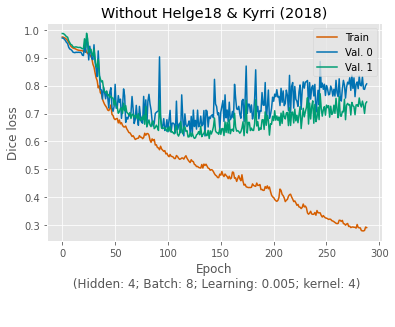

batch_size = 8 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.973807 -- Val. Loss 0: 0.969070 -- Val. Loss 1: 0.986127
Epoch 0025 -- Train Loss : 0.956206 -- Val. Loss 0: 0.963588 -- Val. Loss 1: 0.983073
Epoch 0050 -- Train Loss : 0.948487 -- Val. Loss 0: 0.960885 -- Val. Loss 1: 0.979990
Epoch 0075 -- Train Loss : 0.928117 -- Val. Loss 0: 0.943652 -- Val. Loss 1: 0.970395
Epoch 0100 -- Train Loss : 0.495346 -- Val. Loss 0: 0.841927 -- Val. Loss 1: 0.850549
Epoch 0125 -- Train Loss : 0.307911 -- Val. Loss 0: 0.866073 -- Val. Loss 1: 0.863362
Epoch 0150 -- Train Loss : 0.218457 -- Val. Loss 0: 0.890356 -- Val. Loss 1: 0.833910
Epoch 0175 -- Train Loss : 0.169350 -- Val. Loss 0: 0.849742 -- Val. Loss 1: 0.816982
Epoch 0200 -- Train Loss : 0.168814 -- Val. Loss 0: 0.817807 -- Val. Loss 1: 0.781832
Epoch 0225 -- Train Loss : 0.160064 -- Val. Loss 0: 0.869977 -- Val. Loss 1: 0.848948
Epoch 0250 -- Train Loss : 0.147582 -- Val. Loss 0: 0.843193 -- Val. Loss 1: 0.820173
Epoch 0275 -- T

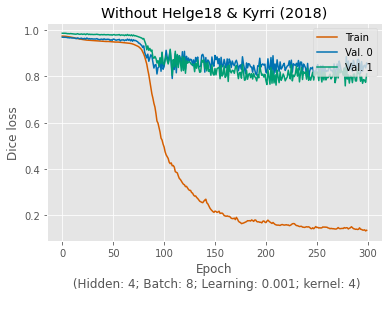

batch_size = 8 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.973907 -- Val. Loss 0: 0.969306 -- Val. Loss 1: 0.986180
Epoch 0025 -- Train Loss : 0.970169 -- Val. Loss 0: 0.966586 -- Val. Loss 1: 0.984564
Epoch 0050 -- Train Loss : 0.946672 -- Val. Loss 0: 0.953515 -- Val. Loss 1: 0.975847
Epoch 0075 -- Train Loss : 0.775063 -- Val. Loss 0: 0.937554 -- Val. Loss 1: 0.946174
Epoch 0100 -- Train Loss : 0.650028 -- Val. Loss 0: 0.938636 -- Val. Loss 1: 0.942591
Epoch 0125 -- Train Loss : 0.576680 -- Val. Loss 0: 0.944333 -- Val. Loss 1: 0.950878
Epoch 0150 -- Train Loss : 0.511976 -- Val. Loss 0: 0.929495 -- Val. Loss 1: 0.943563
Epoch 0175 -- Train Loss : 0.441845 -- Val. Loss 0: 0.930722 -- Val. Loss 1: 0.922390
Epoch 0200 -- Train Loss : 0.389196 -- Val. Loss 0: 0.902739 -- Val. Loss 1: 0.897625
Epoch 0225 -- Train Loss : 0.348650 -- Val. Loss 0: 0.907777 -- Val. Loss 1: 0.893964
Epoch 0250 -- Train Loss : 0.324564 -- Val. Loss 0: 0.904275 -- Val. Loss 1: 0.871702
Epoch 0275 -- 

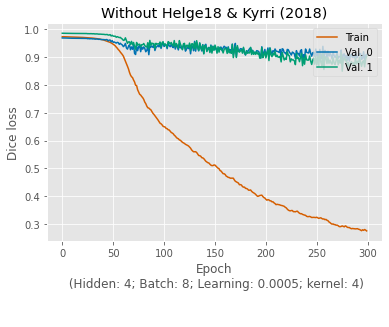

batch_size = 16 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.973497 -- Val. Loss 0: 0.958268 -- Val. Loss 1: 0.981357
Epoch 0025 -- Train Loss : 0.651362 -- Val. Loss 0: 0.691738 -- Val. Loss 1: 0.671706
Epoch 0050 -- Train Loss : 0.523028 -- Val. Loss 0: 0.595336 -- Val. Loss 1: 0.617808
Epoch 0075 -- Train Loss : 0.433745 -- Val. Loss 0: 0.559883 -- Val. Loss 1: 0.568069
Epoch 0100 -- Train Loss : 0.371592 -- Val. Loss 0: 0.577883 -- Val. Loss 1: 0.579018
Epoch 0125 -- Train Loss : 0.320717 -- Val. Loss 0: 0.673283 -- Val. Loss 1: 0.607051
Epoch 0150 -- Train Loss : 0.271129 -- Val. Loss 0: 0.765792 -- Val. Loss 1: 0.755971
Epoch 0175 -- Train Loss : 0.256822 -- Val. Loss 0: 0.709538 -- Val. Loss 1: 0.688509
Epoch 0200 -- Train Loss : 0.225147 -- Val. Loss 0: 0.671437 -- Val. Loss 1: 0.660120
Epoch 0225 -- Train Loss : 0.218310 -- Val. Loss 0: 0.697564 -- Val. Loss 1: 0.704235
Model isn't probably improved anymore, skip to next learning rate...



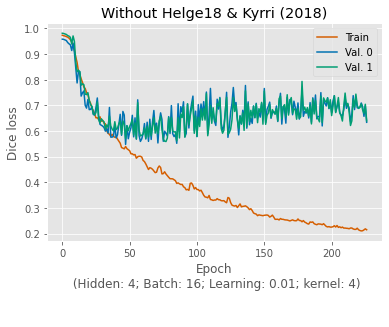

batch_size = 16 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.974535 -- Val. Loss 0: 0.959282 -- Val. Loss 1: 0.982025
Epoch 0025 -- Train Loss : 0.847786 -- Val. Loss 0: 0.839616 -- Val. Loss 1: 0.886946
Epoch 0050 -- Train Loss : 0.707030 -- Val. Loss 0: 0.668853 -- Val. Loss 1: 0.706084
Epoch 0075 -- Train Loss : 0.656801 -- Val. Loss 0: 0.634703 -- Val. Loss 1: 0.621156
Epoch 0100 -- Train Loss : 0.582394 -- Val. Loss 0: 0.571720 -- Val. Loss 1: 0.591890
Epoch 0125 -- Train Loss : 0.558733 -- Val. Loss 0: 0.568478 -- Val. Loss 1: 0.586093
Epoch 0150 -- Train Loss : 0.521286 -- Val. Loss 0: 0.548740 -- Val. Loss 1: 0.567744
Epoch 0175 -- Train Loss : 0.483084 -- Val. Loss 0: 0.612757 -- Val. Loss 1: 0.585079
Epoch 0200 -- Train Loss : 0.484890 -- Val. Loss 0: 0.577559 -- Val. Loss 1: 0.573823
Epoch 0225 -- Train Loss : 0.461746 -- Val. Loss 0: 0.593518 -- Val. Loss 1: 0.573779
Epoch 0250 -- Train Loss : 0.439520 -- Val. Loss 0: 0.576263 -- Val. Loss 1: 0.586186
Epoch 0275 -- 

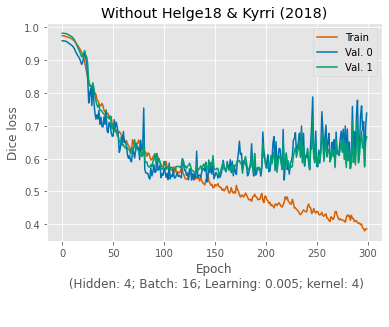

batch_size = 16 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.974720 -- Val. Loss 0: 0.958852 -- Val. Loss 1: 0.981998
Epoch 0025 -- Train Loss : 0.967592 -- Val. Loss 0: 0.954051 -- Val. Loss 1: 0.978422
Epoch 0050 -- Train Loss : 0.926647 -- Val. Loss 0: 0.935748 -- Val. Loss 1: 0.963504
Epoch 0075 -- Train Loss : 0.681347 -- Val. Loss 0: 0.909819 -- Val. Loss 1: 0.935586
Epoch 0100 -- Train Loss : 0.497841 -- Val. Loss 0: 0.912003 -- Val. Loss 1: 0.933455
Epoch 0125 -- Train Loss : 0.411928 -- Val. Loss 0: 0.903195 -- Val. Loss 1: 0.921435
Epoch 0150 -- Train Loss : 0.344534 -- Val. Loss 0: 0.909396 -- Val. Loss 1: 0.914439
Epoch 0175 -- Train Loss : 0.286786 -- Val. Loss 0: 0.892862 -- Val. Loss 1: 0.902612
Epoch 0200 -- Train Loss : 0.245000 -- Val. Loss 0: 0.901134 -- Val. Loss 1: 0.889209
Epoch 0225 -- Train Loss : 0.227989 -- Val. Loss 0: 0.912484 -- Val. Loss 1: 0.883098
Epoch 0250 -- Train Loss : 0.208798 -- Val. Loss 0: 0.874252 -- Val. Loss 1: 0.882964
Epoch 0275 -- 

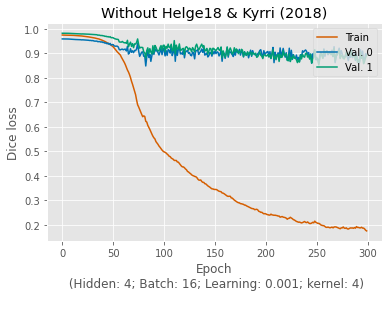

batch_size = 16 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.975035 -- Val. Loss 0: 0.959333 -- Val. Loss 1: 0.982099
Epoch 0025 -- Train Loss : 0.968074 -- Val. Loss 0: 0.952305 -- Val. Loss 1: 0.978768
Epoch 0050 -- Train Loss : 0.952891 -- Val. Loss 0: 0.947168 -- Val. Loss 1: 0.974960
Epoch 0075 -- Train Loss : 0.914334 -- Val. Loss 0: 0.935874 -- Val. Loss 1: 0.965967
Epoch 0100 -- Train Loss : 0.833131 -- Val. Loss 0: 0.920528 -- Val. Loss 1: 0.947913
Epoch 0125 -- Train Loss : 0.755177 -- Val. Loss 0: 0.936827 -- Val. Loss 1: 0.956106
Epoch 0150 -- Train Loss : 0.704593 -- Val. Loss 0: 0.918327 -- Val. Loss 1: 0.950469
Epoch 0175 -- Train Loss : 0.670455 -- Val. Loss 0: 0.928467 -- Val. Loss 1: 0.945695
Epoch 0200 -- Train Loss : 0.626561 -- Val. Loss 0: 0.926384 -- Val. Loss 1: 0.947130
Epoch 0225 -- Train Loss : 0.590795 -- Val. Loss 0: 0.933037 -- Val. Loss 1: 0.942044
Epoch 0250 -- Train Loss : 0.556364 -- Val. Loss 0: 0.927806 -- Val. Loss 1: 0.939336
Epoch 0275 --

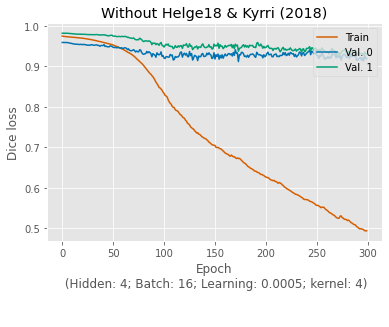

batch_size = 32 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.975109 -- Val. Loss 0: 0.965157 -- Val. Loss 1: 0.985061
Epoch 0025 -- Train Loss : 0.937569 -- Val. Loss 0: 0.902816 -- Val. Loss 1: 0.927260
Epoch 0050 -- Train Loss : 0.868016 -- Val. Loss 0: 0.924746 -- Val. Loss 1: 0.940260
Epoch 0075 -- Train Loss : 0.691077 -- Val. Loss 0: 0.660944 -- Val. Loss 1: 0.614264
Epoch 0100 -- Train Loss : 0.584941 -- Val. Loss 0: 0.707128 -- Val. Loss 1: 0.570325
Epoch 0125 -- Train Loss : 0.534037 -- Val. Loss 0: 0.687829 -- Val. Loss 1: 0.540206
Epoch 0150 -- Train Loss : 0.486772 -- Val. Loss 0: 0.601876 -- Val. Loss 1: 0.513457
Epoch 0175 -- Train Loss : 0.454378 -- Val. Loss 0: 0.605755 -- Val. Loss 1: 0.534644
Epoch 0200 -- Train Loss : 0.415929 -- Val. Loss 0: 0.743006 -- Val. Loss 1: 0.596464
Epoch 0225 -- Train Loss : 0.371910 -- Val. Loss 0: 0.683186 -- Val. Loss 1: 0.576630
Epoch 0250 -- Train Loss : 0.347868 -- Val. Loss 0: 0.740488 -- Val. Loss 1: 0.619189
Epoch 0275 -- T

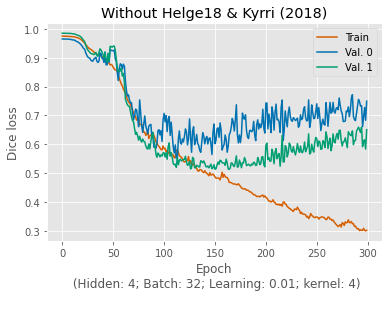

batch_size = 32 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.975038 -- Val. Loss 0: 0.965991 -- Val. Loss 1: 0.985217
Epoch 0025 -- Train Loss : 0.953274 -- Val. Loss 0: 0.930438 -- Val. Loss 1: 0.961499
Epoch 0050 -- Train Loss : 0.874322 -- Val. Loss 0: 0.843989 -- Val. Loss 1: 0.908068
Epoch 0075 -- Train Loss : 0.808639 -- Val. Loss 0: 0.796161 -- Val. Loss 1: 0.868083
Epoch 0100 -- Train Loss : 0.711403 -- Val. Loss 0: 0.728823 -- Val. Loss 1: 0.796525
Epoch 0125 -- Train Loss : 0.591195 -- Val. Loss 0: 0.695355 -- Val. Loss 1: 0.736575
Epoch 0150 -- Train Loss : 0.455617 -- Val. Loss 0: 0.725197 -- Val. Loss 1: 0.738751
Epoch 0175 -- Train Loss : 0.345763 -- Val. Loss 0: 0.722958 -- Val. Loss 1: 0.718697
Epoch 0200 -- Train Loss : 0.283927 -- Val. Loss 0: 0.764093 -- Val. Loss 1: 0.763316
Epoch 0225 -- Train Loss : 0.237025 -- Val. Loss 0: 0.745381 -- Val. Loss 1: 0.732309
Epoch 0250 -- Train Loss : 0.214860 -- Val. Loss 0: 0.748638 -- Val. Loss 1: 0.740289
Epoch 0275 -- 

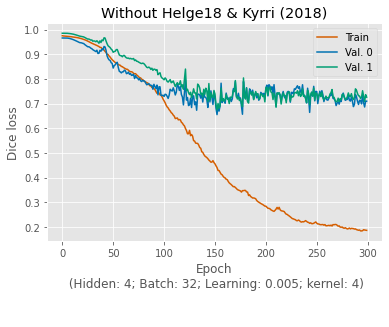

batch_size = 32 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.975255 -- Val. Loss 0: 0.965374 -- Val. Loss 1: 0.985102
Epoch 0025 -- Train Loss : 0.968601 -- Val. Loss 0: 0.965087 -- Val. Loss 1: 0.984871
Epoch 0050 -- Train Loss : 0.961219 -- Val. Loss 0: 0.960672 -- Val. Loss 1: 0.982166
Epoch 0075 -- Train Loss : 0.945142 -- Val. Loss 0: 0.963145 -- Val. Loss 1: 0.983498
Epoch 0100 -- Train Loss : 0.931364 -- Val. Loss 0: 0.961112 -- Val. Loss 1: 0.981591
Epoch 0125 -- Train Loss : 0.881083 -- Val. Loss 0: 0.959727 -- Val. Loss 1: 0.980827
Epoch 0150 -- Train Loss : 0.757202 -- Val. Loss 0: 0.951685 -- Val. Loss 1: 0.972329
Epoch 0175 -- Train Loss : 0.567282 -- Val. Loss 0: 0.950391 -- Val. Loss 1: 0.960056
Epoch 0200 -- Train Loss : 0.464486 -- Val. Loss 0: 0.952179 -- Val. Loss 1: 0.952929
Epoch 0225 -- Train Loss : 0.408779 -- Val. Loss 0: 0.968910 -- Val. Loss 1: 0.951526
Epoch 0250 -- Train Loss : 0.366916 -- Val. Loss 0: 0.962159 -- Val. Loss 1: 0.942571
Epoch 0275 -- 

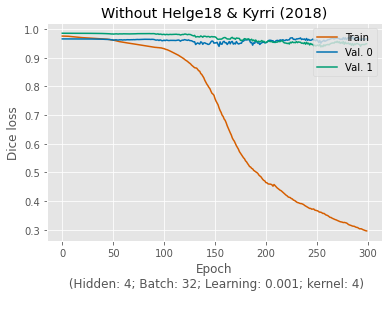

batch_size = 32 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.975469 -- Val. Loss 0: 0.966070 -- Val. Loss 1: 0.985233
Epoch 0025 -- Train Loss : 0.970880 -- Val. Loss 0: 0.961066 -- Val. Loss 1: 0.983099
Epoch 0050 -- Train Loss : 0.964566 -- Val. Loss 0: 0.961937 -- Val. Loss 1: 0.983165
Epoch 0075 -- Train Loss : 0.959964 -- Val. Loss 0: 0.962119 -- Val. Loss 1: 0.983511
Epoch 0100 -- Train Loss : 0.954091 -- Val. Loss 0: 0.961506 -- Val. Loss 1: 0.983066
Epoch 0125 -- Train Loss : 0.943280 -- Val. Loss 0: 0.961625 -- Val. Loss 1: 0.982558
Epoch 0150 -- Train Loss : 0.928403 -- Val. Loss 0: 0.958483 -- Val. Loss 1: 0.981701
Epoch 0175 -- Train Loss : 0.902193 -- Val. Loss 0: 0.956804 -- Val. Loss 1: 0.979876
Epoch 0200 -- Train Loss : 0.865624 -- Val. Loss 0: 0.956204 -- Val. Loss 1: 0.976955
Epoch 0225 -- Train Loss : 0.824789 -- Val. Loss 0: 0.957205 -- Val. Loss 1: 0.977138
Epoch 0250 -- Train Loss : 0.777605 -- Val. Loss 0: 0.963987 -- Val. Loss 1: 0.978355
Epoch 0275 --

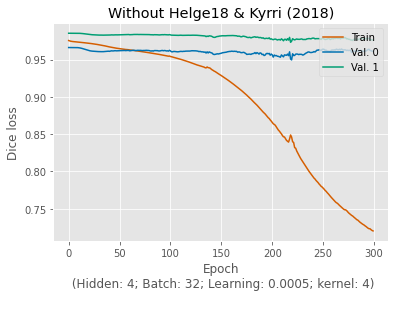

In [ ]:
import glob, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# saved_model = False
saved_model = True

no_improve_epoch = 150
# epochs = 7; epoch_print = 2
epoch_print = 25

trLoss = np.zeros(epochs)
vlLoss_0 = np.zeros(epochs)
vlLoss_1 = np.zeros(epochs)

# https://stackoverflow.com/a/31675177
res = ['hidden_unit', 'batch_size', 'learning_rate', 'min_val_0', 'min_val_1', 
        'min_index_0', 'min_index_1', 'n_part', 'epochs', 'e', 'n_kernel']

bs = 0
while bs < len(Batch_size) :

  batch_size = Batch_size[bs]
  lr = 0
  while lr < len(Learning_rate):

    min_val_0 = sys.float_info.max; min_index_0 = -1
    min_val_1 = sys.float_info.max; min_index_1 = -1

    learning_rate = Learning_rate[lr]
    print('batch_size = ' + str(batch_size) + ' ; learning_rate = ' + str(learning_rate))

    net = UTime(in_channels = C, out_channels = 1, n_fillter = hidden_unit, n_kernel=n_kernel)
    net.cuda()
    net.zero_grad() # Zero the network gradients

    # https://pytorch.org/docs/stable/optim.html#constructing-it
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Run model
    for epoch in range(epochs):
      
      batchLoss = 0
      nBatch = int(nTrain/batch_size)
      
      net.train()
      for i in range(nBatch+1): 
        if i == nBatch:
          X = x_train[-batch_size:]; Y = y_train[-batch_size:]
        else:
          X = x_train[i*batch_size:(i+1)*batch_size]
          Y = y_train[i*batch_size:(i+1)*batch_size]
            
        optimizer.zero_grad() # 1) clear previous gradient computation
        # https://stackoverflow.com/q/57237352
        Y_pred = net(X) # 2) forward propagation
        output = criterion(Y_pred, Y) # 3) calculate the loss
        output.backward() # 4) backpropagate to compute gradients
        batchLoss += output
        
        optimizer.step() # 5) update model weights
      # end for loop
      
      trLoss[epoch] = batchLoss/(nBatch+1)
      
      # Compute validation loss/Enter eval mode
      net.eval()
      
      # Validtion as 0th element
      x_val = x_w[0]; y_val = y_w[0]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_0[epoch] = batchLoss/(nBatch+1)

      # Validtion as 1st element
      x_val = x_w[1]; y_val = y_w[1]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_1[epoch] = batchLoss/(nBatch+1)


      if (epoch % epoch_print == 0.0):
        print( "Epoch {e:04d} -- Train Loss : {l:2.6f} -- Val. Loss 0: {v0:2.6f} -- Val. Loss 1: {v1:2.6f}".format
              (e=epoch,l=trLoss[epoch], v0=vlLoss_0[epoch], v1=vlLoss_1[epoch]) )
      
      # Validtion as 0th element
      if (min_val_0 > vlLoss_0[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_0 = vlLoss_0[epoch]
        min_index_0 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_0, 'min_index':min_index_0 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      
      # Validtion as 1st element
      if (min_val_1 > vlLoss_1[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_1 = vlLoss_1[epoch]
        min_index_1 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_1, 'min_index':min_index_1 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      else:
        if epoch >= ( max(min_index_0,min_index_1) + no_improve_epoch ) :
          print("Model isn't probably improved anymore, skip to next learning rate...\n")
          break

    torch.cuda.empty_cache() # https://stackoverflow.com/a/55340037

    # # Prediction
    del net, optimizer  # https://stackoverflow.com/a/53353203
    torch.cuda.empty_cache()

    plt.plot(trLoss[:epoch], color='#D55E00' )
    plt.plot(vlLoss_0[:epoch], color='#0072B2' )
    plt.plot(vlLoss_1[:epoch], color='#009E73' )
    plt.title('Without ' + extract_name(all_files[test_whale[0]]) + ' & ' + 
              extract_name(all_files[test_whale[1]]) +' (2018)')

    plt.ylabel('Dice loss')
    plt.xlabel('Epoch\n (Hidden: ' + str(hidden_unit) + '; Batch: ' + str(batch_size) + '; Learning: ' + 
               str(learning_rate) + '; kernel: ' + str(n_kernel) + ')\n\n' )
    plt.legend(['Train', 'Val. 0', 'Val. 1'], loc='upper right')
    if saved_model :
      plt.savefig('data/model/whale/U-Time_7/' + whale_name + '/plot/' + model_name + '_diceloss.svg', 
                  format="svg", figsize=(12, 8), bbox_inches='tight')
    plt.show()
    res = np.c_[res, np.r_[hidden_unit, batch_size, learning_rate, 
                           min_val_0,  min_val_1, min_index_0,min_index_1,
                           round(T/(60*e),2), epochs, e, n_kernel]]

    lr += 1

  bs += 1


In [ ]:
import pandas as pd
dt = pd.DataFrame(res.transpose()[1:,], columns=res.transpose()[0,:])
dt.sort_values(['min_val_0','min_val_1'])

hidden_unit batch_size learning_rate  ... epochs     e n_kernel
0          4.0        2.0          0.01  ...  301.0  10.0      4.0
13         4.0       16.0         0.005  ...  301.0  10.0      4.0
4          4.0        4.0          0.01  ...  301.0  10.0      4.0
8          4.0        8.0          0.01  ...  301.0  10.0      4.0
12         4.0       16.0          0.01  ...  301.0  10.0      4.0
16         4.0       32.0          0.01  ...  301.0  10.0      4.0
1          4.0        2.0         0.005  ...  301.0  10.0      4.0
5          4.0        4.0         0.005  ...  301.0  10.0      4.0
9          4.0        8.0         0.005  ...  301.0  10.0      4.0
17         4.0       32.0         0.005  ...  301.0  10.0      4.0
10         4.0        8.0         0.001  ...  301.0  10.0      4.0
2          4.0        2.0         0.001  ...  301.0  10.0      4.0
14         4.0       16.0         0.001  ...  301.0  10.0      4.0
6          4.0        4.0         0.001  ...  301.0  10.0      4.0
11         4.0        8.0        0.0005  ...  301.0  10.0      4.0
7          4.0        4.0        0.0005  ...  301.0  10.0      4.0
15         4.0       16.0        0.0005  ...  301.0  10.0      4.0
3          4.0        2.0        0.0005  ...  301.0  10.0      4.0
18         4.0       32.0         0.001  ...  301.0  10.0      4.0
19         4.0       32.0        0.0005  ...  301.0  10.0      4.0

[20 rows x 11 columns]

### Plot and prediction

In [53]:
# Load saved model using GPU/CPU
envr = 'cuda'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 2
learning_rate = 0.01
epoch = 277

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel) + \
                    '_' + str(test_whale[0]) + str(test_whale[1])

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [54]:
# Test on all whales combined

Ind = X_all[ :,-1].copy().astype(np.int64)

with torch.no_grad():
  y_a = model(x_all)
# y_a = concat_overlap(y_a, Ind-Ind.min())
y_a = y_a[0,:].numpy()

y_t_all = y_all
y_t_all = concat_overlap(y_t_all, Ind-Ind.min())
y_t_all = y_t_all.numpy()

In [55]:
from collections import Counter
C_t = consecutive(y_t_all)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,14) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y_a, y_t_all, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y_a, y_t_all, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t_all, y_a),2) )
L0.append( round(roc_auc_score(y_t_all, y_a),2) )
L0.append(sum([ accel[i].shape[0] for i in train_whale ]))
Res[0,:] = np.ravel(L0)

Res

array([[       0.08,        0.28,        0.34,        0.4 ,        0.4 ,        0.4 ,        0.41,        0.42,
               0.43,        0.45,        0.47,        0.16,        0.64, 18202800.  ]])

In [56]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + ''.join( str(v) for v in train_whale) + '.txt', 
                index=False )
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))

x_test = x_w[1]; y_test = y_w[1]

with torch.no_grad():
  y = model(x_test)

y = concat_overlap(y, accel[test_whale[1]].shape[0]%L).numpy()
y_t = concat_overlap(y_test, accel[test_whale[1]].shape[0]%L).numpy()

In [ ]:
from collections import Counter

print(y_t.sum()/y_t.shape[0]*100)
print(extract_name(all_files[test_whale[1]]))
print(Counter(y_t))

0.7324888815444415
Kyrri
Counter({0.0: 13816350, 1.0: 101950})


In [ ]:
from collections import Counter
C_t = consecutive(y_t)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,13) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y, y_t, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y, y_t, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t, y),2) )
L0.append( round(roc_auc_score(y_t, y),2) )
Res[0,:] = np.ravel(L0)

In [ ]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + whale_test + '.txt', 
                index=False )

# 2. Kyrri

In [57]:
w = 2
test_whale = [ w, (w+1)%len(all_files) ]
print(test_whale)

whale_name = extract_name(all_files[test_whale[0]])
print(whale_name)

accel[w]

[2, 3]
Kyrri


DateTime      AccX       AccY  ...  Dive_no  whale  buzz
0        2018-08-24 22:48:21  -3.90625 -679.68750  ...     -120  Kyrri     0
1                        NaT  -7.81250 -695.31250  ...     -120  Kyrri     0
2                        NaT  -3.90625 -699.21875  ...     -120  Kyrri     0
3                        NaT   0.00000 -722.65625  ...     -120  Kyrri     0
4                        NaT  -7.81250 -734.37500  ...     -120  Kyrri     0
...                      ...       ...        ...  ...      ...    ...   ...
13918295                 NaT  42.96875 -324.21875  ...     -286  Kyrri     0
13918296                 NaT  42.96875 -320.31250  ...     -286  Kyrri     0
13918297                 NaT  31.25000 -324.21875  ...     -286  Kyrri     0
13918298                 NaT  27.34375 -312.50000  ...     -286  Kyrri     0
13918299 2018-08-26 13:28:03  19.53125 -312.50000  ...     -286  Kyrri     0

[13918300 rows x 13 columns]

In [58]:
train_whale = list(range(len(all_files)))
train_whale.remove(w)
train_whale.remove( (w+1)%len(all_files) )
print(train_whale)

[0, 1, 4]


In [59]:
# 2: validation & test
x_whale = [None]*2
y_whale = [None]*2
x_w = [None]*2
y_w = [None]*2

for i in range(2) :
    x_whale[i] = accel[test_whale[i]].iloc[:,1:(1+C)].to_numpy()
    y_whale[i] = accel[test_whale[i]].iloc[:,-1].to_numpy()
    x_w[i], y_w[i] = make_dataset(x_whale[i], y_whale[i], overlap=0, win_shape=(L,C) )
    x_w[i] = x_w[i].swapaxes(1,2)

# x_whale = accel[w].iloc[:,1:(1+C)].to_numpy()
# y_whale = accel[w].iloc[:,-1].to_numpy()
# x_w, y_w = make_dataset(x_whale, y_whale, overlap=0, win_shape=(L,C) )
# x_w = x_w.swapaxes(1,2)

In [60]:
# https://stackoverflow.com/a/42376244
X_train, Y_train = map(list, zip(*[split_dataset(accel[i], no_val=True) for i in train_whale ]))
# n_elem_test = np.ravel([x.shape[0] for x in X_test])
# n_elem_test = np.append(0, n_elem_test).cumsum()

In [61]:
X_train = np.concatenate( X_train )
Y_train = np.concatenate( Y_train )
# X_val = np.concatenate( X_val )
# Y_val = np.concatenate( Y_val )

In [62]:
# https://datascience.stackexchange.com/a/27616
# https://datascience.stackexchange.com/a/12346
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if (X_train.shape[1] == C+1):
    for i in range(C):
        X_train[:,i,:] = scaler.fit_transform( X_train[:,i,:] )
        # X_val[:,i,:]   = scaler.transform( X_val[:,i,:] )
        for k in range(2) :
            x_w[k][:,i,:] = scaler.transform( x_w[k][:,i,:] )
    print('Normalize column 1')
if (X_train.shape[2] == C+1):
    for i in range(C):
        X_train[:,:,i] = scaler.fit_transform( X_train[:,:,i] )
        # X_val[:,:,i]   = scaler.transform( X_val[:,:,i] )
        for k in range(2) :
            x_w[k][:,:,i] = scaler.transform( x_w[k][:,:,i] )
    print('Normalize column 2')

Normalize column 1


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for i in range(2) :
    x_w[i] = torch.FloatTensor(x_w[i].astype(np.float32))
    y_w[i] = torch.FloatTensor(y_w[i].astype(np.float32))
    x_w[i] = x_w[i].to(device)
    y_w[i] = y_w[i].to(device)


# Importing gc module
import gc ; gc.collect()

nTrain = len(X_train)
# nVal = len(X_val)

cpu


In [64]:
print(test_whale[0])
print(test_whale[1])

print(len(x_w[0]))
print(len(x_w[1]))

2
3
39
10


In [65]:
x_train = X_train[:,0:C,:].astype(np.float32); y_train = Y_train
# x_val = X_val[:,0:C,:].astype(np.float32); y_val = Y_val
# x_test = X_test[:,0:C,:].astype(np.float32); y_test = Y_test

# Load training data as torch float tensors
x_train = torch.FloatTensor(x_train) # Input
y_train = torch.FloatTensor(y_train) # Target
x_train = x_train.to(device)
y_train = y_train.to(device)

# x_val = torch.FloatTensor(x_val) # Input
# y_val = torch.FloatTensor(y_val) # Target
# x_test = torch.FloatTensor(x_w) # Input
# y_test = torch.FloatTensor(y_w) # Target

# x_val = x_val.to(device)
# y_val = y_val.to(device)
# x_test = x_test.to(device)
# y_test = y_test.to(device)

### Train model

In [ ]:
import os
epochs = N_EPOCH

print(nTrain) # print(nVal)
print(x_train.shape) # print(x_val.shape)

84
torch.Size([84, 8, 360000])


In [ ]:
hidden_unit = 4 # Hidden units
n_kernel = 4

Batch_size = [2**x for x in range(1,11)] # https://datascience.stackexchange.com/a/20193
Batch_size = [x for x in Batch_size \
              if x <= min(nTrain, len(x_w[0]), len(x_w[1])) ]

Batch_size

[2, 4, 8]

batch_size = 2 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.963135 -- Val. Loss 0: 0.977981 -- Val. Loss 1: 0.971740
Epoch 0025 -- Train Loss : 0.691280 -- Val. Loss 0: 0.790179 -- Val. Loss 1: 0.674823
Epoch 0050 -- Train Loss : 0.703393 -- Val. Loss 0: 0.790859 -- Val. Loss 1: 0.682028
Epoch 0075 -- Train Loss : 0.622244 -- Val. Loss 0: 0.765817 -- Val. Loss 1: 0.719846
Epoch 0100 -- Train Loss : 0.585699 -- Val. Loss 0: 0.786465 -- Val. Loss 1: 0.669233
Epoch 0125 -- Train Loss : 0.612596 -- Val. Loss 0: 0.765439 -- Val. Loss 1: 0.642345
Epoch 0150 -- Train Loss : 0.577623 -- Val. Loss 0: 0.672823 -- Val. Loss 1: 0.653938
Epoch 0175 -- Train Loss : 0.603580 -- Val. Loss 0: 0.755031 -- Val. Loss 1: 0.635163
Epoch 0200 -- Train Loss : 0.569183 -- Val. Loss 0: 0.662026 -- Val. Loss 1: 0.634451
Epoch 0225 -- Train Loss : 0.564090 -- Val. Loss 0: 0.581631 -- Val. Loss 1: 0.636514
Epoch 0250 -- Train Loss : 0.582397 -- Val. Loss 0: 0.637729 -- Val. Loss 1: 0.667498
Epoch 0275 -- Tr

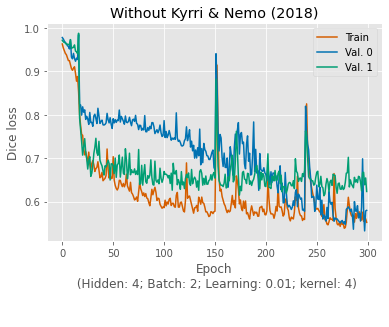

batch_size = 2 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.967577 -- Val. Loss 0: 0.980004 -- Val. Loss 1: 0.975113
Epoch 0025 -- Train Loss : 0.738503 -- Val. Loss 0: 0.880087 -- Val. Loss 1: 0.894662
Epoch 0050 -- Train Loss : 0.629382 -- Val. Loss 0: 0.752230 -- Val. Loss 1: 0.709241
Epoch 0075 -- Train Loss : 0.598415 -- Val. Loss 0: 0.671371 -- Val. Loss 1: 0.679498
Epoch 0100 -- Train Loss : 0.574564 -- Val. Loss 0: 0.648305 -- Val. Loss 1: 0.841243
Epoch 0125 -- Train Loss : 0.585964 -- Val. Loss 0: 0.594330 -- Val. Loss 1: 0.729934
Epoch 0150 -- Train Loss : 0.518030 -- Val. Loss 0: 0.524501 -- Val. Loss 1: 0.869999
Epoch 0175 -- Train Loss : 0.553731 -- Val. Loss 0: 0.612731 -- Val. Loss 1: 0.737391
Epoch 0200 -- Train Loss : 0.516225 -- Val. Loss 0: 0.501798 -- Val. Loss 1: 0.839137
Epoch 0225 -- Train Loss : 0.488535 -- Val. Loss 0: 0.581326 -- Val. Loss 1: 0.807512
Epoch 0250 -- Train Loss : 0.497089 -- Val. Loss 0: 0.582746 -- Val. Loss 1: 0.895630
Epoch 0275 -- T

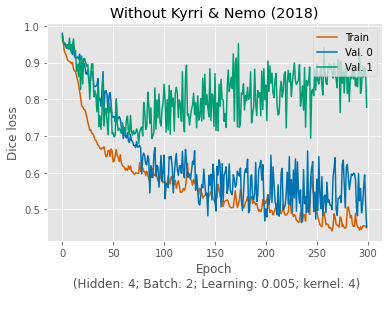

batch_size = 2 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.969722 -- Val. Loss 0: 0.986062 -- Val. Loss 1: 0.979836
Epoch 0025 -- Train Loss : 0.633702 -- Val. Loss 0: 0.793829 -- Val. Loss 1: 0.732980
Epoch 0050 -- Train Loss : 0.576452 -- Val. Loss 0: 0.786197 -- Val. Loss 1: 0.676515
Epoch 0075 -- Train Loss : 0.499390 -- Val. Loss 0: 0.766952 -- Val. Loss 1: 0.645784
Epoch 0100 -- Train Loss : 0.464556 -- Val. Loss 0: 0.762294 -- Val. Loss 1: 0.659320
Epoch 0125 -- Train Loss : 0.423170 -- Val. Loss 0: 0.760525 -- Val. Loss 1: 0.658150
Epoch 0150 -- Train Loss : 0.454846 -- Val. Loss 0: 0.735654 -- Val. Loss 1: 0.692507
Epoch 0175 -- Train Loss : 0.378347 -- Val. Loss 0: 0.703492 -- Val. Loss 1: 0.674946
Epoch 0200 -- Train Loss : 0.468406 -- Val. Loss 0: 0.661666 -- Val. Loss 1: 0.638993
Epoch 0225 -- Train Loss : 0.370124 -- Val. Loss 0: 0.652610 -- Val. Loss 1: 0.680875
Epoch 0250 -- Train Loss : 0.352557 -- Val. Loss 0: 0.564991 -- Val. Loss 1: 0.703475
Epoch 0275 -- T

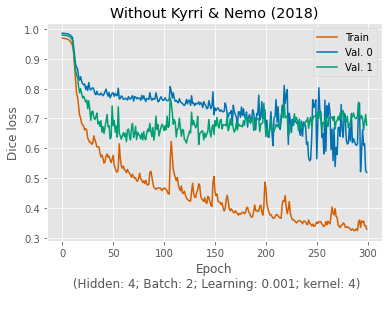

batch_size = 2 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.969424 -- Val. Loss 0: 0.985792 -- Val. Loss 1: 0.979448
Epoch 0025 -- Train Loss : 0.813193 -- Val. Loss 0: 0.915983 -- Val. Loss 1: 0.900519
Epoch 0050 -- Train Loss : 0.642570 -- Val. Loss 0: 0.879935 -- Val. Loss 1: 0.852967
Epoch 0075 -- Train Loss : 0.493387 -- Val. Loss 0: 0.874090 -- Val. Loss 1: 0.774075
Epoch 0100 -- Train Loss : 0.427048 -- Val. Loss 0: 0.861666 -- Val. Loss 1: 0.744487
Epoch 0125 -- Train Loss : 0.362830 -- Val. Loss 0: 0.860900 -- Val. Loss 1: 0.747322
Epoch 0150 -- Train Loss : 0.362653 -- Val. Loss 0: 0.857474 -- Val. Loss 1: 0.775862
Epoch 0175 -- Train Loss : 0.291879 -- Val. Loss 0: 0.860559 -- Val. Loss 1: 0.758214
Epoch 0200 -- Train Loss : 0.276517 -- Val. Loss 0: 0.816090 -- Val. Loss 1: 0.745123
Epoch 0225 -- Train Loss : 0.291082 -- Val. Loss 0: 0.775031 -- Val. Loss 1: 0.776701
Epoch 0250 -- Train Loss : 0.469180 -- Val. Loss 0: 0.751059 -- Val. Loss 1: 0.833139
Epoch 0275 -- 

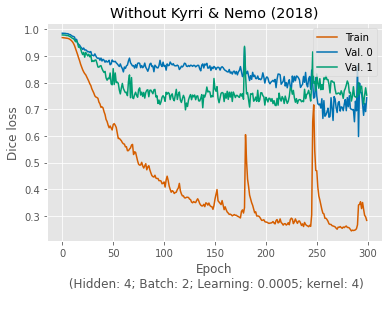

batch_size = 4 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.968115 -- Val. Loss 0: 0.976367 -- Val. Loss 1: 0.974905
Epoch 0025 -- Train Loss : 0.688955 -- Val. Loss 0: 0.717633 -- Val. Loss 1: 0.725716
Epoch 0050 -- Train Loss : 0.560744 -- Val. Loss 0: 0.675601 -- Val. Loss 1: 0.650594
Epoch 0075 -- Train Loss : 0.576121 -- Val. Loss 0: 0.595207 -- Val. Loss 1: 0.611735
Epoch 0100 -- Train Loss : 0.507808 -- Val. Loss 0: 0.609976 -- Val. Loss 1: 0.602016
Epoch 0125 -- Train Loss : 0.527457 -- Val. Loss 0: 0.655828 -- Val. Loss 1: 0.628811
Epoch 0150 -- Train Loss : 0.512570 -- Val. Loss 0: 0.755477 -- Val. Loss 1: 0.720022
Epoch 0175 -- Train Loss : 0.492830 -- Val. Loss 0: 0.401625 -- Val. Loss 1: 0.579649
Epoch 0200 -- Train Loss : 0.488626 -- Val. Loss 0: 0.486590 -- Val. Loss 1: 0.599612
Epoch 0225 -- Train Loss : 0.498571 -- Val. Loss 0: 0.480264 -- Val. Loss 1: 0.575616
Epoch 0250 -- Train Loss : 0.493370 -- Val. Loss 0: 0.674596 -- Val. Loss 1: 0.638622
Epoch 0275 -- Tr

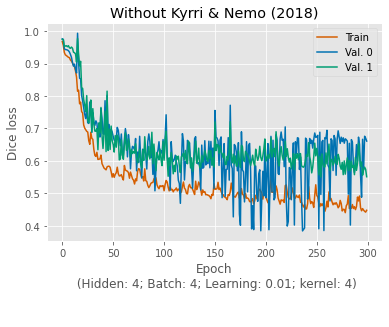

batch_size = 4 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.968505 -- Val. Loss 0: 0.986084 -- Val. Loss 1: 0.982228
Epoch 0025 -- Train Loss : 0.597071 -- Val. Loss 0: 0.688910 -- Val. Loss 1: 0.660182
Epoch 0050 -- Train Loss : 0.518594 -- Val. Loss 0: 0.698316 -- Val. Loss 1: 0.700785
Epoch 0075 -- Train Loss : 0.494178 -- Val. Loss 0: 0.677417 -- Val. Loss 1: 0.657764
Epoch 0100 -- Train Loss : 0.479406 -- Val. Loss 0: 0.700728 -- Val. Loss 1: 0.695457
Epoch 0125 -- Train Loss : 0.466645 -- Val. Loss 0: 0.661943 -- Val. Loss 1: 0.674107
Epoch 0150 -- Train Loss : 0.386346 -- Val. Loss 0: 0.610901 -- Val. Loss 1: 0.685861
Epoch 0175 -- Train Loss : 0.385259 -- Val. Loss 0: 0.615650 -- Val. Loss 1: 0.695454
Epoch 0200 -- Train Loss : 0.347908 -- Val. Loss 0: 0.710009 -- Val. Loss 1: 0.774949
Epoch 0225 -- Train Loss : 0.355930 -- Val. Loss 0: 0.684119 -- Val. Loss 1: 0.828013
Epoch 0250 -- Train Loss : 0.377786 -- Val. Loss 0: 0.604301 -- Val. Loss 1: 0.781041
Epoch 0275 -- T

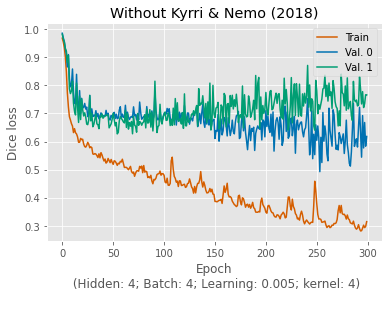

batch_size = 4 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.969554 -- Val. Loss 0: 0.986208 -- Val. Loss 1: 0.982306
Epoch 0025 -- Train Loss : 0.807105 -- Val. Loss 0: 0.896989 -- Val. Loss 1: 0.903596
Epoch 0050 -- Train Loss : 0.645973 -- Val. Loss 0: 0.819311 -- Val. Loss 1: 0.827575
Epoch 0075 -- Train Loss : 0.438809 -- Val. Loss 0: 0.848515 -- Val. Loss 1: 0.867052
Epoch 0100 -- Train Loss : 0.311441 -- Val. Loss 0: 0.817723 -- Val. Loss 1: 0.844913
Epoch 0125 -- Train Loss : 0.272186 -- Val. Loss 0: 0.828903 -- Val. Loss 1: 0.844791
Epoch 0150 -- Train Loss : 0.224886 -- Val. Loss 0: 0.836427 -- Val. Loss 1: 0.868850
Epoch 0175 -- Train Loss : 0.249029 -- Val. Loss 0: 0.787716 -- Val. Loss 1: 0.845010
Epoch 0200 -- Train Loss : 0.205269 -- Val. Loss 0: 0.841586 -- Val. Loss 1: 0.856093
Epoch 0225 -- Train Loss : 0.239342 -- Val. Loss 0: 0.831216 -- Val. Loss 1: 0.852896
Epoch 0250 -- Train Loss : 0.168172 -- Val. Loss 0: 0.789027 -- Val. Loss 1: 0.798040
Epoch 0275 -- T

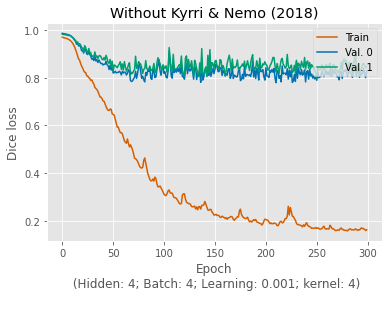

batch_size = 4 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.970711 -- Val. Loss 0: 0.986229 -- Val. Loss 1: 0.982331
Epoch 0025 -- Train Loss : 0.895057 -- Val. Loss 0: 0.957901 -- Val. Loss 1: 0.959133
Epoch 0050 -- Train Loss : 0.640345 -- Val. Loss 0: 0.888462 -- Val. Loss 1: 0.892434
Epoch 0075 -- Train Loss : 0.454883 -- Val. Loss 0: 0.890358 -- Val. Loss 1: 0.871386
Epoch 0100 -- Train Loss : 0.390660 -- Val. Loss 0: 0.884930 -- Val. Loss 1: 0.871335
Epoch 0125 -- Train Loss : 0.292236 -- Val. Loss 0: 0.878844 -- Val. Loss 1: 0.861751
Epoch 0150 -- Train Loss : 0.300903 -- Val. Loss 0: 0.885543 -- Val. Loss 1: 0.876337
Epoch 0175 -- Train Loss : 0.243841 -- Val. Loss 0: 0.869348 -- Val. Loss 1: 0.870140
Epoch 0200 -- Train Loss : 0.243677 -- Val. Loss 0: 0.852910 -- Val. Loss 1: 0.836533
Epoch 0225 -- Train Loss : 0.244586 -- Val. Loss 0: 0.878330 -- Val. Loss 1: 0.871816
Epoch 0250 -- Train Loss : 0.216881 -- Val. Loss 0: 0.850985 -- Val. Loss 1: 0.864602
Epoch 0275 -- 

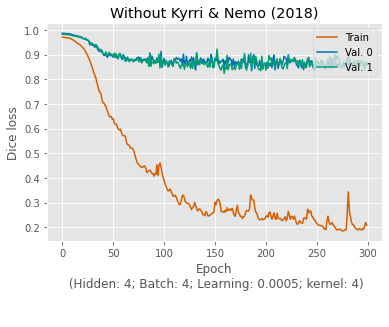

batch_size = 8 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.968778 -- Val. Loss 0: 0.985596 -- Val. Loss 1: 0.983090
Epoch 0025 -- Train Loss : 0.577790 -- Val. Loss 0: 0.573221 -- Val. Loss 1: 0.684252
Epoch 0050 -- Train Loss : 0.533600 -- Val. Loss 0: 0.564148 -- Val. Loss 1: 0.668064
Epoch 0075 -- Train Loss : 0.523637 -- Val. Loss 0: 0.530854 -- Val. Loss 1: 0.663516
Epoch 0100 -- Train Loss : 0.483576 -- Val. Loss 0: 0.542288 -- Val. Loss 1: 0.674355
Epoch 0125 -- Train Loss : 0.443874 -- Val. Loss 0: 0.563802 -- Val. Loss 1: 0.666437
Epoch 0150 -- Train Loss : 0.401404 -- Val. Loss 0: 0.559243 -- Val. Loss 1: 0.676132
Epoch 0175 -- Train Loss : 0.446340 -- Val. Loss 0: 0.660245 -- Val. Loss 1: 0.675747
Epoch 0200 -- Train Loss : 0.372927 -- Val. Loss 0: 0.652736 -- Val. Loss 1: 0.677923
Epoch 0225 -- Train Loss : 0.335961 -- Val. Loss 0: 0.705334 -- Val. Loss 1: 0.685179
Epoch 0250 -- Train Loss : 0.354227 -- Val. Loss 0: 0.762125 -- Val. Loss 1: 0.748686
Model isn't prob

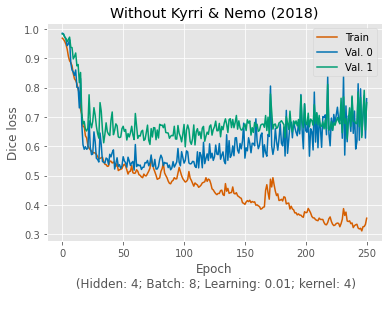

batch_size = 8 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.968141 -- Val. Loss 0: 0.986031 -- Val. Loss 1: 0.983438
Epoch 0025 -- Train Loss : 0.619374 -- Val. Loss 0: 0.639326 -- Val. Loss 1: 0.739452
Epoch 0050 -- Train Loss : 0.539328 -- Val. Loss 0: 0.564109 -- Val. Loss 1: 0.669705
Epoch 0075 -- Train Loss : 0.488737 -- Val. Loss 0: 0.547290 -- Val. Loss 1: 0.679525
Epoch 0100 -- Train Loss : 0.468941 -- Val. Loss 0: 0.540720 -- Val. Loss 1: 0.658219
Epoch 0125 -- Train Loss : 0.476950 -- Val. Loss 0: 0.553477 -- Val. Loss 1: 0.647217
Epoch 0150 -- Train Loss : 0.404880 -- Val. Loss 0: 0.623671 -- Val. Loss 1: 0.689048
Epoch 0175 -- Train Loss : 0.386122 -- Val. Loss 0: 0.606425 -- Val. Loss 1: 0.668146
Epoch 0200 -- Train Loss : 0.354183 -- Val. Loss 0: 0.581310 -- Val. Loss 1: 0.685952
Epoch 0225 -- Train Loss : 0.401811 -- Val. Loss 0: 0.584162 -- Val. Loss 1: 0.652959
Model isn't probably improved anymore, skip to next learning rate...



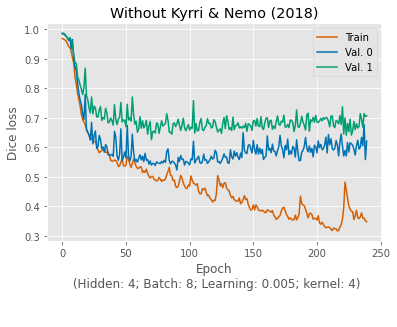

batch_size = 8 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.969998 -- Val. Loss 0: 0.986249 -- Val. Loss 1: 0.983637
Epoch 0025 -- Train Loss : 0.969863 -- Val. Loss 0: 0.986219 -- Val. Loss 1: 0.983607
Epoch 0050 -- Train Loss : 0.969761 -- Val. Loss 0: 0.986196 -- Val. Loss 1: 0.983586
Epoch 0075 -- Train Loss : 0.969417 -- Val. Loss 0: 0.985290 -- Val. Loss 1: 0.982202
Epoch 0100 -- Train Loss : 0.913115 -- Val. Loss 0: 0.939291 -- Val. Loss 1: 0.959138
Epoch 0125 -- Train Loss : 0.868663 -- Val. Loss 0: 0.927894 -- Val. Loss 1: 0.933475
Epoch 0150 -- Train Loss : 0.837631 -- Val. Loss 0: 0.919307 -- Val. Loss 1: 0.930504
Epoch 0175 -- Train Loss : 0.826065 -- Val. Loss 0: 0.922214 -- Val. Loss 1: 0.926982
Epoch 0200 -- Train Loss : 0.818241 -- Val. Loss 0: 0.918633 -- Val. Loss 1: 0.923515
Epoch 0225 -- Train Loss : 0.809359 -- Val. Loss 0: 0.922319 -- Val. Loss 1: 0.926436
Epoch 0250 -- Train Loss : 0.802255 -- Val. Loss 0: 0.914164 -- Val. Loss 1: 0.921913
Epoch 0275 -- T

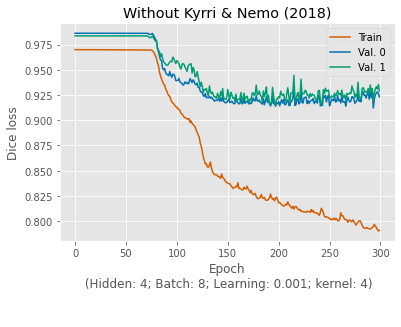

batch_size = 8 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.967692 -- Val. Loss 0: 0.986168 -- Val. Loss 1: 0.983581
Epoch 0025 -- Train Loss : 0.939751 -- Val. Loss 0: 0.980868 -- Val. Loss 1: 0.979849
Epoch 0050 -- Train Loss : 0.931091 -- Val. Loss 0: 0.980288 -- Val. Loss 1: 0.979685
Epoch 0075 -- Train Loss : 0.923704 -- Val. Loss 0: 0.980323 -- Val. Loss 1: 0.979847
Epoch 0100 -- Train Loss : 0.918002 -- Val. Loss 0: 0.979856 -- Val. Loss 1: 0.980176
Epoch 0125 -- Train Loss : 0.910186 -- Val. Loss 0: 0.977792 -- Val. Loss 1: 0.978051
Epoch 0150 -- Train Loss : 0.902575 -- Val. Loss 0: 0.974181 -- Val. Loss 1: 0.976099
Epoch 0175 -- Train Loss : 0.890323 -- Val. Loss 0: 0.976864 -- Val. Loss 1: 0.977601
Epoch 0200 -- Train Loss : 0.881477 -- Val. Loss 0: 0.974108 -- Val. Loss 1: 0.976635
Epoch 0225 -- Train Loss : 0.866244 -- Val. Loss 0: 0.975078 -- Val. Loss 1: 0.976068
Epoch 0250 -- Train Loss : 0.849805 -- Val. Loss 0: 0.976434 -- Val. Loss 1: 0.978359
Epoch 0275 -- 

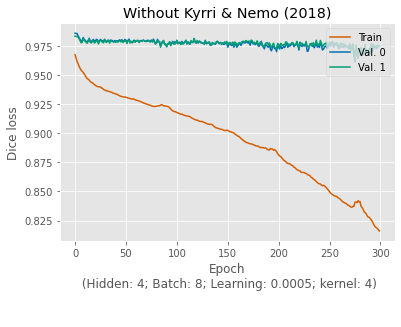

In [ ]:
import glob, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# saved_model = False
saved_model = True

no_improve_epoch = 150
# epochs = 7; epoch_print = 2
epoch_print = 25

trLoss = np.zeros(epochs)
vlLoss_0 = np.zeros(epochs)
vlLoss_1 = np.zeros(epochs)

# https://stackoverflow.com/a/31675177
res = ['hidden_unit', 'batch_size', 'learning_rate', 'min_val_0', 'min_val_1', 
        'min_index_0', 'min_index_1', 'n_part', 'epochs', 'e', 'n_kernel']

bs = 0
while bs < len(Batch_size) :

  batch_size = Batch_size[bs]
  lr = 0
  while lr < len(Learning_rate):

    min_val_0 = sys.float_info.max; min_index_0 = -1
    min_val_1 = sys.float_info.max; min_index_1 = -1

    learning_rate = Learning_rate[lr]
    print('batch_size = ' + str(batch_size) + ' ; learning_rate = ' + str(learning_rate))

    net = UTime(in_channels = C, out_channels = 1, n_fillter = hidden_unit, n_kernel=n_kernel)
    net.cuda()
    net.zero_grad() # Zero the network gradients

    # https://pytorch.org/docs/stable/optim.html#constructing-it
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Run model
    for epoch in range(epochs):
      
      batchLoss = 0
      nBatch = int(nTrain/batch_size)
      
      net.train()
      for i in range(nBatch+1): 
        if i == nBatch:
          X = x_train[-batch_size:]; Y = y_train[-batch_size:]
        else:
          X = x_train[i*batch_size:(i+1)*batch_size]
          Y = y_train[i*batch_size:(i+1)*batch_size]
            
        optimizer.zero_grad() # 1) clear previous gradient computation
        # https://stackoverflow.com/q/57237352
        Y_pred = net(X) # 2) forward propagation
        output = criterion(Y_pred, Y) # 3) calculate the loss
        output.backward() # 4) backpropagate to compute gradients
        batchLoss += output
        
        optimizer.step() # 5) update model weights
      # end for loop
      
      trLoss[epoch] = batchLoss/(nBatch+1)
      
      # Compute validation loss/Enter eval mode
      net.eval()
      
      # Validtion as 0th element
      x_val = x_w[0]; y_val = y_w[0]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_0[epoch] = batchLoss/(nBatch+1)

      # Validtion as 1st element
      x_val = x_w[1]; y_val = y_w[1]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_1[epoch] = batchLoss/(nBatch+1)


      if (epoch % epoch_print == 0.0):
        print( "Epoch {e:04d} -- Train Loss : {l:2.6f} -- Val. Loss 0: {v0:2.6f} -- Val. Loss 1: {v1:2.6f}".format
              (e=epoch,l=trLoss[epoch], v0=vlLoss_0[epoch], v1=vlLoss_1[epoch]) )
      
      # Validtion as 0th element
      if (min_val_0 > vlLoss_0[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_0 = vlLoss_0[epoch]
        min_index_0 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_0, 'min_index':min_index_0 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      
      # Validtion as 1st element
      if (min_val_1 > vlLoss_1[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_1 = vlLoss_1[epoch]
        min_index_1 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_1, 'min_index':min_index_1 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      else:
        if epoch >= ( max(min_index_0,min_index_1) + no_improve_epoch ) :
          print("Model isn't probably improved anymore, skip to next learning rate...\n")
          break

    torch.cuda.empty_cache() # https://stackoverflow.com/a/55340037

    # # Prediction
    del net, optimizer  # https://stackoverflow.com/a/53353203
    torch.cuda.empty_cache()

    plt.plot(trLoss[:epoch], color='#D55E00' )
    plt.plot(vlLoss_0[:epoch], color='#0072B2' )
    plt.plot(vlLoss_1[:epoch], color='#009E73' )
    plt.title('Without ' + extract_name(all_files[test_whale[0]]) + ' & ' + 
              extract_name(all_files[test_whale[1]]) +' (2018)')

    plt.ylabel('Dice loss')
    plt.xlabel('Epoch\n (Hidden: ' + str(hidden_unit) + '; Batch: ' + str(batch_size) + '; Learning: ' + 
               str(learning_rate) + '; kernel: ' + str(n_kernel) + ')\n\n' )
    plt.legend(['Train', 'Val. 0', 'Val. 1'], loc='upper right')
    if saved_model :
      plt.savefig('data/model/whale/U-Time_7/' + whale_name + '/plot/' + model_name + '_diceloss.svg', 
                  format="svg", figsize=(12, 8), bbox_inches='tight')
    plt.show()
    res = np.c_[res, np.r_[hidden_unit, batch_size, learning_rate, 
                           min_val_0,  min_val_1, min_index_0,min_index_1,
                           round(T/(60*e),2), epochs, e, n_kernel]]

    lr += 1

  bs += 1


In [ ]:
import pandas as pd
dt = pd.DataFrame(res.transpose()[1:,], columns=res.transpose()[0,:])
dt.sort_values(['min_val_0','min_val_1'])

hidden_unit batch_size learning_rate  ... epochs     e n_kernel
4          4.0        4.0          0.01  ...  301.0  10.0      4.0
1          4.0        2.0         0.005  ...  301.0  10.0      4.0
5          4.0        4.0         0.005  ...  301.0  10.0      4.0
8          4.0        8.0          0.01  ...  301.0  10.0      4.0
2          4.0        2.0         0.001  ...  301.0  10.0      4.0
9          4.0        8.0         0.005  ...  301.0  10.0      4.0
0          4.0        2.0          0.01  ...  301.0  10.0      4.0
3          4.0        2.0        0.0005  ...  301.0  10.0      4.0
6          4.0        4.0         0.001  ...  301.0  10.0      4.0
7          4.0        4.0        0.0005  ...  301.0  10.0      4.0
10         4.0        8.0         0.001  ...  301.0  10.0      4.0
11         4.0        8.0        0.0005  ...  301.0  10.0      4.0

[12 rows x 11 columns]

### Plot and prediction

In [66]:
# Load saved model using GPU/CPU
envr = 'cuda'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 4
learning_rate = 0.01
epoch = 236

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel) + \
                    '_' + str(test_whale[0]) + str(test_whale[1])

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [67]:
# Test on all whales combined

Ind = X_all[ :,-1].copy().astype(np.int64)

with torch.no_grad():
  y_a = model(x_all)
# y_a = concat_overlap(y_a, Ind-Ind.min())
y_a = y_a[0,:].numpy()

y_t_all = y_all
y_t_all = concat_overlap(y_t_all, Ind-Ind.min())
y_t_all = y_t_all.numpy()

In [68]:
from collections import Counter
C_t = consecutive(y_t_all)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,14) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y_a, y_t_all, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y_a, y_t_all, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t_all, y_a),2) )
L0.append( round(roc_auc_score(y_t_all, y_a),2) )
L0.append(sum([ accel[i].shape[0] for i in train_whale ]))
Res[0,:] = np.ravel(L0)

Res

array([[       0.15,        0.62,        0.68,        0.72,        0.72,        0.72,        0.73,        0.74,
               0.75,        0.77,        0.77,        0.29,        0.78, 26493300.  ]])

In [69]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + ''.join( str(v) for v in train_whale) + '.txt', 
                index=False )
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))

x_test = x_w[1]; y_test = y_w[1]

with torch.no_grad():
  y = model(x_test)

y = concat_overlap(y, accel[test_whale[1]].shape[0]%L).numpy()
y_t = concat_overlap(y_test, accel[test_whale[1]].shape[0]%L).numpy()

In [ ]:
from collections import Counter

print(y_t.sum()/y_t.shape[0]*100)
print(extract_name(all_files[test_whale[1]]))
print(Counter(y_t))

1.12407056422219
Nemo
Counter({0.0: 3390950, 1.0: 38550})


In [ ]:
from collections import Counter
C_t = consecutive(y_t)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,13) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y, y_t, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y, y_t, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t, y),2) )
L0.append( round(roc_auc_score(y_t, y),2) )
Res[0,:] = np.ravel(L0)

In [ ]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + whale_test + '.txt', 
                index=False )

### Plot and prediction

In [ ]:
# Load saved model using GPU/CPU
envr = 'gpu'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 8
learning_rate = 0.005
epoch = 121

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel)

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_5/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def miss_ratio(x, y0, overlap ) :
  with torch.no_grad():
    Y = model(x)
  # pdb.set_trace()
  y = concat_overlap(Y, overlap)
  # del Y
  y_t = concat_overlap( y0, overlap )
  return missed_rate( y, y_t, 100 )

def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))


In [ ]:
for i in test_whale :
  r = miss_ratio(x_w[i], y_w[i], accel[i].shape[0]%L )
  w_name = extract_name(all_files[i])
  print( w_name , r )

Asgeir 0.786923076923077
Siggi 0.8663282571912013
Nemo 0.7764842840512224
Kyrri 0.6072874493927125
Frederik 0.6065573770491803


In [ ]:
with torch.no_grad():
  y = model(x_val)

criterion(y_val,y)

tensor(0.7963)

In [ ]:
with torch.no_grad():
  y = model(x_test)

criterion(y_test,y)

tensor(0.8159)

In [ ]:
def concat_overlap(y, ovl):
  if y.shape[0] <= 1:
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))


y = concat_overlap(y, a3.shape[0] % L)
# y = y.detach().cpu().numpy().T
y_t = concat_overlap(y_test, a3.shape[0] % L)

missed_rate( y, y_t, 100 )

0.8454545454545455

# 3. Nemo

In [70]:
w = 3
test_whale = [ w, (w+1)%len(all_files) ]
print(test_whale)

whale_name = extract_name(all_files[test_whale[0]])
print(whale_name)

accel[w]

[3, 4]
Nemo


DateTime       AccX       AccY  ...  Dive_no  whale  buzz
0       2018-08-25 21:00:45 -621.09375  203.12500  ...      130   Nemo     0
1                       NaT -648.43750  207.03125  ...      130   Nemo     0
2                       NaT -671.87500  207.03125  ...      130   Nemo     0
3                       NaT -664.06250  218.75000  ...      130   Nemo     0
4                       NaT -675.78125  214.84375  ...      130   Nemo     0
...                     ...        ...        ...  ...      ...    ...   ...
3429495                 NaT -410.15625  125.00000  ...     -166   Nemo     0
3429496                 NaT -417.96875  148.43750  ...     -166   Nemo     0
3429497                 NaT -417.96875  171.87500  ...     -166   Nemo     0
3429498                 NaT -417.96875  183.59375  ...     -166   Nemo     0
3429499 2018-08-26 06:32:19 -417.96875  199.21875  ...     -166   Nemo     0

[3429500 rows x 13 columns]

In [71]:
train_whale = list(range(len(all_files)))
train_whale.remove(w)
train_whale.remove( (w+1)%len(all_files) )
print(train_whale)

[0, 1, 2]


In [72]:
# 2: validation & test
x_whale = [None]*2
y_whale = [None]*2
x_w = [None]*2
y_w = [None]*2

for i in range(2) :
    x_whale[i] = accel[test_whale[i]].iloc[:,1:(1+C)].to_numpy()
    y_whale[i] = accel[test_whale[i]].iloc[:,-1].to_numpy()
    x_w[i], y_w[i] = make_dataset(x_whale[i], y_whale[i], overlap=0, win_shape=(L,C) )
    x_w[i] = x_w[i].swapaxes(1,2)

# x_whale = accel[w].iloc[:,1:(1+C)].to_numpy()
# y_whale = accel[w].iloc[:,-1].to_numpy()
# x_w, y_w = make_dataset(x_whale, y_whale, overlap=0, win_shape=(L,C) )
# x_w = x_w.swapaxes(1,2)

In [73]:
# https://stackoverflow.com/a/42376244
X_train, Y_train = map(list, zip(*[split_dataset(accel[i], no_val=True) for i in train_whale ]))
# n_elem_test = np.ravel([x.shape[0] for x in X_test])
# n_elem_test = np.append(0, n_elem_test).cumsum()

In [74]:
X_train = np.concatenate( X_train )
Y_train = np.concatenate( Y_train )
# X_val = np.concatenate( X_val )
# Y_val = np.concatenate( Y_val )

In [75]:
# https://datascience.stackexchange.com/a/27616
# https://datascience.stackexchange.com/a/12346
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if (X_train.shape[1] == C+1):
    for i in range(C):
        X_train[:,i,:] = scaler.fit_transform( X_train[:,i,:] )
        # X_val[:,i,:]   = scaler.transform( X_val[:,i,:] )
        for k in range(2) :
            x_w[k][:,i,:] = scaler.transform( x_w[k][:,i,:] )
    print('Normalize column 1')
if (X_train.shape[2] == C+1):
    for i in range(C):
        X_train[:,:,i] = scaler.fit_transform( X_train[:,:,i] )
        # X_val[:,:,i]   = scaler.transform( X_val[:,:,i] )
        for k in range(2) :
            x_w[k][:,:,i] = scaler.transform( x_w[k][:,:,i] )
    print('Normalize column 2')

Normalize column 1


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for i in range(2) :
    x_w[i] = torch.FloatTensor(x_w[i].astype(np.float32))
    y_w[i] = torch.FloatTensor(y_w[i].astype(np.float32))
    x_w[i] = x_w[i].to(device)
    y_w[i] = y_w[i].to(device)


# Importing gc module
import gc ; gc.collect()

nTrain = len(X_train)
# nVal = len(X_val)

cpu


In [77]:
print(test_whale[0])
print(test_whale[1])

print(len(x_w[0]))
print(len(x_w[1]))

3
4
10
10


In [78]:
x_train = X_train[:,0:C,:].astype(np.float32); y_train = Y_train
# x_val = X_val[:,0:C,:].astype(np.float32); y_val = Y_val
# x_test = X_test[:,0:C,:].astype(np.float32); y_test = Y_test

# Load training data as torch float tensors
x_train = torch.FloatTensor(x_train) # Input
y_train = torch.FloatTensor(y_train) # Target
x_train = x_train.to(device)
y_train = y_train.to(device)

# x_val = torch.FloatTensor(x_val) # Input
# y_val = torch.FloatTensor(y_val) # Target
# x_test = torch.FloatTensor(x_w) # Input
# y_test = torch.FloatTensor(y_w) # Target

# x_val = x_val.to(device)
# y_val = y_val.to(device)
# x_test = x_test.to(device)
# y_test = y_test.to(device)

### Train model

In [ ]:
import os
epochs = N_EPOCH

print(nTrain) # print(nVal)
print(x_train.shape) # print(x_val.shape)

116
torch.Size([116, 8, 360000])


In [ ]:
hidden_unit = 4 # Hidden units
n_kernel = 4

Batch_size = [2**x for x in range(1,11)] # https://datascience.stackexchange.com/a/20193
Batch_size = [x for x in Batch_size \
              if x <= min(nTrain, len(x_w[0]), len(x_w[1])) ]

Batch_size

[2, 4, 8]

batch_size = 2 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.970956 -- Val. Loss 0: 0.960827 -- Val. Loss 1: 0.940981
Epoch 0025 -- Train Loss : 0.771522 -- Val. Loss 0: 0.759663 -- Val. Loss 1: 0.883782
Epoch 0050 -- Train Loss : 0.694081 -- Val. Loss 0: 0.781124 -- Val. Loss 1: 0.896088
Epoch 0075 -- Train Loss : 0.666074 -- Val. Loss 0: 0.787277 -- Val. Loss 1: 0.874713
Epoch 0100 -- Train Loss : 0.655672 -- Val. Loss 0: 0.714809 -- Val. Loss 1: 0.839433
Epoch 0125 -- Train Loss : 0.652053 -- Val. Loss 0: 0.724943 -- Val. Loss 1: 0.726205
Epoch 0150 -- Train Loss : 0.648292 -- Val. Loss 0: 0.759783 -- Val. Loss 1: 0.867349
Epoch 0175 -- Train Loss : 0.642796 -- Val. Loss 0: 0.718014 -- Val. Loss 1: 0.803843
Epoch 0200 -- Train Loss : 0.686416 -- Val. Loss 0: 0.774104 -- Val. Loss 1: 0.804227
Epoch 0225 -- Train Loss : 0.644405 -- Val. Loss 0: 0.736027 -- Val. Loss 1: 0.844267
Epoch 0250 -- Train Loss : 0.655075 -- Val. Loss 0: 0.761336 -- Val. Loss 1: 0.869853
Epoch 0275 -- Tr

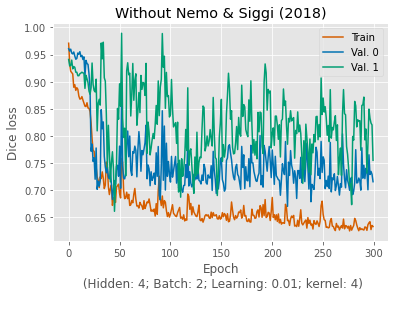

batch_size = 2 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.974271 -- Val. Loss 0: 0.976229 -- Val. Loss 1: 0.962855
Epoch 0025 -- Train Loss : 0.897446 -- Val. Loss 0: 0.948272 -- Val. Loss 1: 0.900232
Epoch 0050 -- Train Loss : 0.721043 -- Val. Loss 0: 0.693423 -- Val. Loss 1: 0.802076
Epoch 0075 -- Train Loss : 0.690013 -- Val. Loss 0: 0.658586 -- Val. Loss 1: 0.673634
Epoch 0100 -- Train Loss : 0.682400 -- Val. Loss 0: 0.647153 -- Val. Loss 1: 0.746147
Epoch 0125 -- Train Loss : 0.667751 -- Val. Loss 0: 0.687938 -- Val. Loss 1: 0.793404
Epoch 0150 -- Train Loss : 0.636961 -- Val. Loss 0: 0.695136 -- Val. Loss 1: 0.796388
Epoch 0175 -- Train Loss : 0.790336 -- Val. Loss 0: 0.999551 -- Val. Loss 1: 0.999797
Epoch 0200 -- Train Loss : 0.782416 -- Val. Loss 0: 0.999551 -- Val. Loss 1: 0.999797
Epoch 0225 -- Train Loss : 0.780591 -- Val. Loss 0: 0.999551 -- Val. Loss 1: 0.999797
Epoch 0250 -- Train Loss : 0.779905 -- Val. Loss 0: 0.999551 -- Val. Loss 1: 0.999797
Model isn't pro

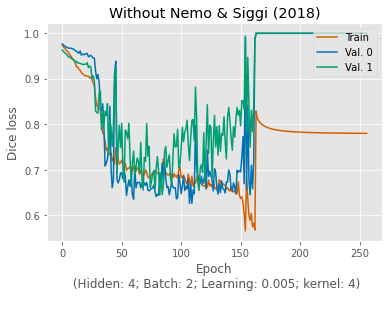

batch_size = 2 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.976328 -- Val. Loss 0: 0.978652 -- Val. Loss 1: 0.967889
Epoch 0025 -- Train Loss : 0.841643 -- Val. Loss 0: 0.879292 -- Val. Loss 1: 0.872324
Epoch 0050 -- Train Loss : 0.695658 -- Val. Loss 0: 0.701303 -- Val. Loss 1: 0.746928
Epoch 0075 -- Train Loss : 0.635164 -- Val. Loss 0: 0.694110 -- Val. Loss 1: 0.802003
Epoch 0100 -- Train Loss : 0.605316 -- Val. Loss 0: 0.676986 -- Val. Loss 1: 0.769093
Epoch 0125 -- Train Loss : 0.591692 -- Val. Loss 0: 0.709195 -- Val. Loss 1: 0.815902
Epoch 0150 -- Train Loss : 0.577572 -- Val. Loss 0: 0.653900 -- Val. Loss 1: 0.721996
Epoch 0175 -- Train Loss : 0.568958 -- Val. Loss 0: 0.707045 -- Val. Loss 1: 0.832891
Epoch 0200 -- Train Loss : 0.571651 -- Val. Loss 0: 0.683345 -- Val. Loss 1: 0.850969
Epoch 0225 -- Train Loss : 0.522060 -- Val. Loss 0: 0.721382 -- Val. Loss 1: 0.843375
Epoch 0250 -- Train Loss : 0.577489 -- Val. Loss 0: 0.674649 -- Val. Loss 1: 0.661635
Epoch 0275 -- T

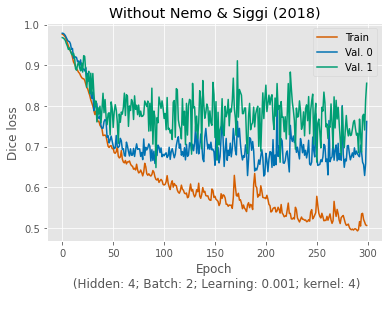

batch_size = 2 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.975602 -- Val. Loss 0: 0.978870 -- Val. Loss 1: 0.966709
Epoch 0025 -- Train Loss : 0.792803 -- Val. Loss 0: 0.822449 -- Val. Loss 1: 0.825578
Epoch 0050 -- Train Loss : 0.656020 -- Val. Loss 0: 0.738245 -- Val. Loss 1: 0.776140
Epoch 0075 -- Train Loss : 0.567104 -- Val. Loss 0: 0.722034 -- Val. Loss 1: 0.739645
Epoch 0100 -- Train Loss : 0.528545 -- Val. Loss 0: 0.718600 -- Val. Loss 1: 0.762782
Epoch 0125 -- Train Loss : 0.486566 -- Val. Loss 0: 0.726385 -- Val. Loss 1: 0.751361
Epoch 0150 -- Train Loss : 0.461391 -- Val. Loss 0: 0.717369 -- Val. Loss 1: 0.750197
Epoch 0175 -- Train Loss : 0.434934 -- Val. Loss 0: 0.743530 -- Val. Loss 1: 0.801475
Epoch 0200 -- Train Loss : 0.437708 -- Val. Loss 0: 0.728791 -- Val. Loss 1: 0.738120
Epoch 0225 -- Train Loss : 0.399405 -- Val. Loss 0: 0.716879 -- Val. Loss 1: 0.751742
Epoch 0250 -- Train Loss : 0.399351 -- Val. Loss 0: 0.721142 -- Val. Loss 1: 0.785580
Epoch 0275 -- 

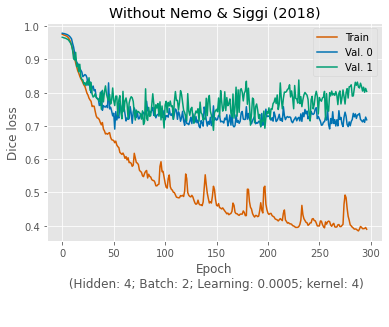

batch_size = 4 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.975376 -- Val. Loss 0: 0.977469 -- Val. Loss 1: 0.967935
Epoch 0025 -- Train Loss : 0.879429 -- Val. Loss 0: 0.917682 -- Val. Loss 1: 0.925284
Epoch 0050 -- Train Loss : 0.861885 -- Val. Loss 0: 0.891442 -- Val. Loss 1: 0.902953
Epoch 0075 -- Train Loss : 0.855880 -- Val. Loss 0: 0.895761 -- Val. Loss 1: 0.895232
Epoch 0100 -- Train Loss : 0.853551 -- Val. Loss 0: 0.901771 -- Val. Loss 1: 0.915061
Epoch 0125 -- Train Loss : 0.849715 -- Val. Loss 0: 0.904299 -- Val. Loss 1: 0.911984
Epoch 0150 -- Train Loss : 0.846459 -- Val. Loss 0: 0.894835 -- Val. Loss 1: 0.898792
Epoch 0175 -- Train Loss : 0.847794 -- Val. Loss 0: 0.891634 -- Val. Loss 1: 0.904297
Epoch 0200 -- Train Loss : 0.843328 -- Val. Loss 0: 0.905982 -- Val. Loss 1: 0.913010
Epoch 0225 -- Train Loss : 0.840057 -- Val. Loss 0: 0.895720 -- Val. Loss 1: 0.902027
Epoch 0250 -- Train Loss : 0.842235 -- Val. Loss 0: 0.894695 -- Val. Loss 1: 0.904306
Epoch 0275 -- Tr

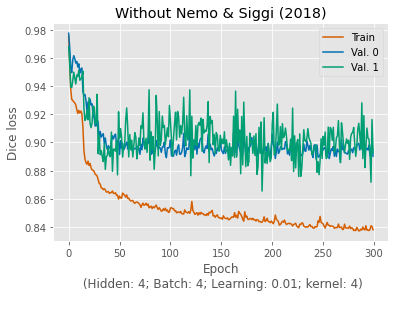

batch_size = 4 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.973601 -- Val. Loss 0: 0.980717 -- Val. Loss 1: 0.973477
Epoch 0025 -- Train Loss : 0.760630 -- Val. Loss 0: 0.806901 -- Val. Loss 1: 0.793776
Epoch 0050 -- Train Loss : 0.630983 -- Val. Loss 0: 0.695430 -- Val. Loss 1: 0.822221
Epoch 0075 -- Train Loss : 0.601686 -- Val. Loss 0: 0.675244 -- Val. Loss 1: 0.743738
Epoch 0100 -- Train Loss : 0.584990 -- Val. Loss 0: 0.669721 -- Val. Loss 1: 0.824822
Epoch 0125 -- Train Loss : 0.554567 -- Val. Loss 0: 0.677213 -- Val. Loss 1: 0.828108
Epoch 0150 -- Train Loss : 0.536323 -- Val. Loss 0: 0.687111 -- Val. Loss 1: 0.823040
Epoch 0175 -- Train Loss : 0.533996 -- Val. Loss 0: 0.685769 -- Val. Loss 1: 0.866388
Epoch 0200 -- Train Loss : 0.523018 -- Val. Loss 0: 0.668741 -- Val. Loss 1: 0.819930
Epoch 0225 -- Train Loss : 0.496047 -- Val. Loss 0: 0.714969 -- Val. Loss 1: 0.850668
Epoch 0250 -- Train Loss : 0.487058 -- Val. Loss 0: 0.746564 -- Val. Loss 1: 0.893902
Model isn't pro

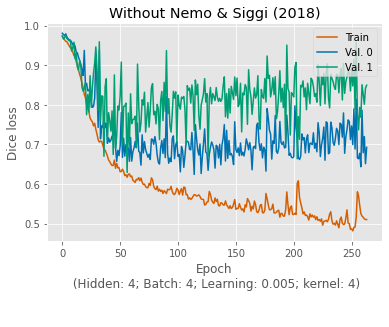

batch_size = 4 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.976555 -- Val. Loss 0: 0.982138 -- Val. Loss 1: 0.975067
Epoch 0025 -- Train Loss : 0.855317 -- Val. Loss 0: 0.900499 -- Val. Loss 1: 0.895007
Epoch 0050 -- Train Loss : 0.687810 -- Val. Loss 0: 0.744400 -- Val. Loss 1: 0.722915
Epoch 0075 -- Train Loss : 0.635786 -- Val. Loss 0: 0.729887 -- Val. Loss 1: 0.751905
Epoch 0100 -- Train Loss : 0.604271 -- Val. Loss 0: 0.722695 -- Val. Loss 1: 0.775962
Epoch 0125 -- Train Loss : 0.559023 -- Val. Loss 0: 0.711573 -- Val. Loss 1: 0.739121
Epoch 0150 -- Train Loss : 0.534107 -- Val. Loss 0: 0.716534 -- Val. Loss 1: 0.764699
Epoch 0175 -- Train Loss : 0.549703 -- Val. Loss 0: 0.708529 -- Val. Loss 1: 0.757508
Epoch 0200 -- Train Loss : 0.497748 -- Val. Loss 0: 0.721663 -- Val. Loss 1: 0.767760
Epoch 0225 -- Train Loss : 0.468832 -- Val. Loss 0: 0.738551 -- Val. Loss 1: 0.780211
Epoch 0250 -- Train Loss : 0.462716 -- Val. Loss 0: 0.724686 -- Val. Loss 1: 0.777553
Epoch 0275 -- T

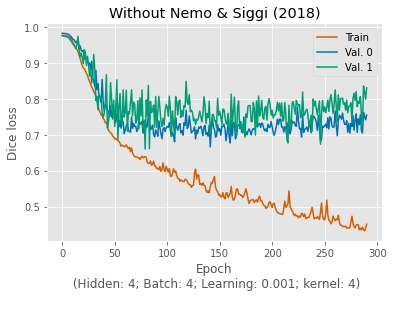

batch_size = 4 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.976515 -- Val. Loss 0: 0.982009 -- Val. Loss 1: 0.974743
Epoch 0025 -- Train Loss : 0.861880 -- Val. Loss 0: 0.913051 -- Val. Loss 1: 0.948993
Epoch 0050 -- Train Loss : 0.713581 -- Val. Loss 0: 0.857836 -- Val. Loss 1: 0.919398
Epoch 0075 -- Train Loss : 0.576930 -- Val. Loss 0: 0.827367 -- Val. Loss 1: 0.943660
Epoch 0100 -- Train Loss : 0.496131 -- Val. Loss 0: 0.871110 -- Val. Loss 1: 0.947142
Epoch 0125 -- Train Loss : 0.430997 -- Val. Loss 0: 0.821758 -- Val. Loss 1: 0.925537
Epoch 0150 -- Train Loss : 0.420831 -- Val. Loss 0: 0.793818 -- Val. Loss 1: 0.898553
Epoch 0175 -- Train Loss : 0.373858 -- Val. Loss 0: 0.816910 -- Val. Loss 1: 0.934624
Epoch 0200 -- Train Loss : 0.371887 -- Val. Loss 0: 0.807991 -- Val. Loss 1: 0.929551
Epoch 0225 -- Train Loss : 0.342531 -- Val. Loss 0: 0.825221 -- Val. Loss 1: 0.948423
Epoch 0250 -- Train Loss : 0.343843 -- Val. Loss 0: 0.796220 -- Val. Loss 1: 0.926659
Epoch 0275 -- 

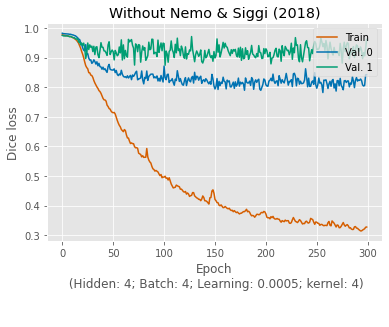

batch_size = 8 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.973637 -- Val. Loss 0: 0.981549 -- Val. Loss 1: 0.970327
Epoch 0025 -- Train Loss : 0.577958 -- Val. Loss 0: 0.618690 -- Val. Loss 1: 0.751112
Epoch 0050 -- Train Loss : 0.492246 -- Val. Loss 0: 0.660445 -- Val. Loss 1: 0.760543
Epoch 0075 -- Train Loss : 0.524698 -- Val. Loss 0: 0.706605 -- Val. Loss 1: 0.835924
Epoch 0100 -- Train Loss : 0.481148 -- Val. Loss 0: 0.635593 -- Val. Loss 1: 0.738627
Epoch 0125 -- Train Loss : 0.462189 -- Val. Loss 0: 0.647353 -- Val. Loss 1: 0.740614
Epoch 0150 -- Train Loss : 0.427844 -- Val. Loss 0: 0.642663 -- Val. Loss 1: 0.793352
Epoch 0175 -- Train Loss : 0.451344 -- Val. Loss 0: 0.628899 -- Val. Loss 1: 0.701671
Epoch 0200 -- Train Loss : 0.425381 -- Val. Loss 0: 0.639841 -- Val. Loss 1: 0.712385
Epoch 0225 -- Train Loss : 0.398079 -- Val. Loss 0: 0.715870 -- Val. Loss 1: 0.820892
Epoch 0250 -- Train Loss : 0.399157 -- Val. Loss 0: 0.657962 -- Val. Loss 1: 0.721555
Epoch 0275 -- Tr

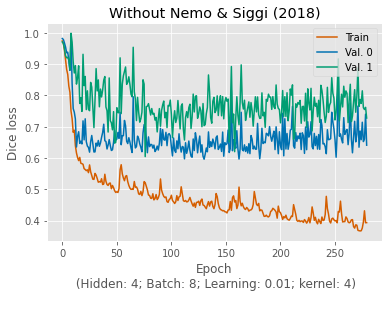

batch_size = 8 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.972645 -- Val. Loss 0: 0.983367 -- Val. Loss 1: 0.972629
Epoch 0025 -- Train Loss : 0.545400 -- Val. Loss 0: 0.640204 -- Val. Loss 1: 0.688499
Epoch 0050 -- Train Loss : 0.502909 -- Val. Loss 0: 0.654443 -- Val. Loss 1: 0.700983
Epoch 0075 -- Train Loss : 0.455675 -- Val. Loss 0: 0.602296 -- Val. Loss 1: 0.642537
Epoch 0100 -- Train Loss : 0.447184 -- Val. Loss 0: 0.641407 -- Val. Loss 1: 0.700880
Epoch 0125 -- Train Loss : 0.425251 -- Val. Loss 0: 0.602516 -- Val. Loss 1: 0.700799
Epoch 0150 -- Train Loss : 0.443784 -- Val. Loss 0: 0.590326 -- Val. Loss 1: 0.605821
Epoch 0175 -- Train Loss : 0.379847 -- Val. Loss 0: 0.590126 -- Val. Loss 1: 0.715653
Epoch 0200 -- Train Loss : 0.363007 -- Val. Loss 0: 0.642199 -- Val. Loss 1: 0.748491
Epoch 0225 -- Train Loss : 0.340368 -- Val. Loss 0: 0.684142 -- Val. Loss 1: 0.788810
Epoch 0250 -- Train Loss : 0.362808 -- Val. Loss 0: 0.651731 -- Val. Loss 1: 0.719606
Epoch 0275 -- T

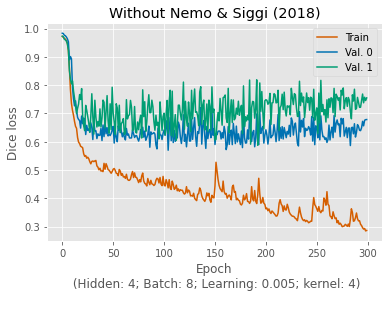

batch_size = 8 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.975715 -- Val. Loss 0: 0.983511 -- Val. Loss 1: 0.972898
Epoch 0025 -- Train Loss : 0.837981 -- Val. Loss 0: 0.879954 -- Val. Loss 1: 0.915846
Epoch 0050 -- Train Loss : 0.659851 -- Val. Loss 0: 0.765318 -- Val. Loss 1: 0.731837
Epoch 0075 -- Train Loss : 0.547955 -- Val. Loss 0: 0.695804 -- Val. Loss 1: 0.754377
Epoch 0100 -- Train Loss : 0.450918 -- Val. Loss 0: 0.684556 -- Val. Loss 1: 0.726208
Epoch 0125 -- Train Loss : 0.406101 -- Val. Loss 0: 0.662030 -- Val. Loss 1: 0.641483
Epoch 0150 -- Train Loss : 0.345939 -- Val. Loss 0: 0.749652 -- Val. Loss 1: 0.812259
Epoch 0175 -- Train Loss : 0.307052 -- Val. Loss 0: 0.695971 -- Val. Loss 1: 0.786831
Epoch 0200 -- Train Loss : 0.259734 -- Val. Loss 0: 0.688782 -- Val. Loss 1: 0.757432
Epoch 0225 -- Train Loss : 0.244272 -- Val. Loss 0: 0.756798 -- Val. Loss 1: 0.808355
Epoch 0250 -- Train Loss : 0.218958 -- Val. Loss 0: 0.673643 -- Val. Loss 1: 0.762811
Epoch 0275 -- T

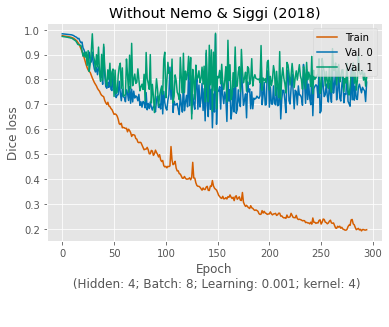

batch_size = 8 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.975331 -- Val. Loss 0: 0.983411 -- Val. Loss 1: 0.972761
Epoch 0025 -- Train Loss : 0.958057 -- Val. Loss 0: 0.976492 -- Val. Loss 1: 0.969071
Epoch 0050 -- Train Loss : 0.951681 -- Val. Loss 0: 0.974345 -- Val. Loss 1: 0.965230
Epoch 0075 -- Train Loss : 0.945866 -- Val. Loss 0: 0.972857 -- Val. Loss 1: 0.965331
Epoch 0100 -- Train Loss : 0.939934 -- Val. Loss 0: 0.974982 -- Val. Loss 1: 0.970994
Epoch 0125 -- Train Loss : 0.932647 -- Val. Loss 0: 0.972372 -- Val. Loss 1: 0.968593
Epoch 0150 -- Train Loss : 0.925933 -- Val. Loss 0: 0.971174 -- Val. Loss 1: 0.970639
Epoch 0175 -- Train Loss : 0.913523 -- Val. Loss 0: 0.970615 -- Val. Loss 1: 0.970095
Epoch 0200 -- Train Loss : 0.902311 -- Val. Loss 0: 0.966574 -- Val. Loss 1: 0.965404
Epoch 0225 -- Train Loss : 0.886781 -- Val. Loss 0: 0.964411 -- Val. Loss 1: 0.967055
Epoch 0250 -- Train Loss : 0.870301 -- Val. Loss 0: 0.959268 -- Val. Loss 1: 0.970627
Epoch 0275 -- 

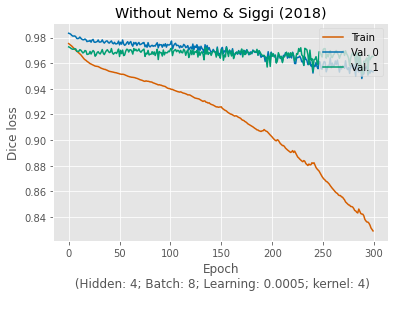

In [ ]:
import glob, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# saved_model = False
saved_model = True

no_improve_epoch = 150
# epochs = 7; epoch_print = 2
epoch_print = 25

trLoss = np.zeros(epochs)
vlLoss_0 = np.zeros(epochs)
vlLoss_1 = np.zeros(epochs)

# https://stackoverflow.com/a/31675177
res = ['hidden_unit', 'batch_size', 'learning_rate', 'min_val_0', 'min_val_1', 
        'min_index_0', 'min_index_1', 'n_part', 'epochs', 'e', 'n_kernel']

bs = 0
while bs < len(Batch_size) :

  batch_size = Batch_size[bs]
  lr = 0
  while lr < len(Learning_rate):

    min_val_0 = sys.float_info.max; min_index_0 = -1
    min_val_1 = sys.float_info.max; min_index_1 = -1

    learning_rate = Learning_rate[lr]
    print('batch_size = ' + str(batch_size) + ' ; learning_rate = ' + str(learning_rate))

    net = UTime(in_channels = C, out_channels = 1, n_fillter = hidden_unit, n_kernel=n_kernel)
    net.cuda()
    net.zero_grad() # Zero the network gradients

    # https://pytorch.org/docs/stable/optim.html#constructing-it
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Run model
    for epoch in range(epochs):
      
      batchLoss = 0
      nBatch = int(nTrain/batch_size)
      
      net.train()
      for i in range(nBatch+1): 
        if i == nBatch:
          X = x_train[-batch_size:]; Y = y_train[-batch_size:]
        else:
          X = x_train[i*batch_size:(i+1)*batch_size]
          Y = y_train[i*batch_size:(i+1)*batch_size]
            
        optimizer.zero_grad() # 1) clear previous gradient computation
        # https://stackoverflow.com/q/57237352
        Y_pred = net(X) # 2) forward propagation
        output = criterion(Y_pred, Y) # 3) calculate the loss
        output.backward() # 4) backpropagate to compute gradients
        batchLoss += output
        
        optimizer.step() # 5) update model weights
      # end for loop
      
      trLoss[epoch] = batchLoss/(nBatch+1)
      
      # Compute validation loss/Enter eval mode
      net.eval()
      
      # Validtion as 0th element
      x_val = x_w[0]; y_val = y_w[0]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_0[epoch] = batchLoss/(nBatch+1)

      # Validtion as 1st element
      x_val = x_w[1]; y_val = y_w[1]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_1[epoch] = batchLoss/(nBatch+1)


      if (epoch % epoch_print == 0.0):
        print( "Epoch {e:04d} -- Train Loss : {l:2.6f} -- Val. Loss 0: {v0:2.6f} -- Val. Loss 1: {v1:2.6f}".format
              (e=epoch,l=trLoss[epoch], v0=vlLoss_0[epoch], v1=vlLoss_1[epoch]) )
      
      # Validtion as 0th element
      if (min_val_0 > vlLoss_0[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_0 = vlLoss_0[epoch]
        min_index_0 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_0, 'min_index':min_index_0 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      
      # Validtion as 1st element
      if (min_val_1 > vlLoss_1[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_1 = vlLoss_1[epoch]
        min_index_1 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_1, 'min_index':min_index_1 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      else:
        if epoch >= ( max(min_index_0,min_index_1) + no_improve_epoch ) :
          print("Model isn't probably improved anymore, skip to next learning rate...\n")
          break

    torch.cuda.empty_cache() # https://stackoverflow.com/a/55340037

    # # Prediction
    del net, optimizer  # https://stackoverflow.com/a/53353203
    torch.cuda.empty_cache()

    plt.plot(trLoss[:epoch], color='#D55E00' )
    plt.plot(vlLoss_0[:epoch], color='#0072B2' )
    plt.plot(vlLoss_1[:epoch], color='#009E73' )
    plt.title('Without ' + extract_name(all_files[test_whale[0]]) + ' & ' + 
              extract_name(all_files[test_whale[1]]) +' (2018)')

    plt.ylabel('Dice loss')
    plt.xlabel('Epoch\n (Hidden: ' + str(hidden_unit) + '; Batch: ' + str(batch_size) + '; Learning: ' + 
               str(learning_rate) + '; kernel: ' + str(n_kernel) + ')\n\n' )
    plt.legend(['Train', 'Val. 0', 'Val. 1'], loc='upper right')
    if saved_model :
      plt.savefig('data/model/whale/U-Time_7/' + whale_name + '/plot/' + model_name + '_diceloss.svg', 
                  format="svg", figsize=(12, 8), bbox_inches='tight')
    plt.show()
    res = np.c_[res, np.r_[hidden_unit, batch_size, learning_rate, 
                           min_val_0,  min_val_1, min_index_0,min_index_1,
                           round(T/(60*e),2), epochs, e, n_kernel]]

    lr += 1

  bs += 1


In [ ]:
import pandas as pd
dt = pd.DataFrame(res.transpose()[1:,], columns=res.transpose()[0,:])
dt.sort_values(['min_val_0','min_val_1'])

hidden_unit batch_size learning_rate  ... epochs     e n_kernel
9          4.0        8.0         0.005  ...  301.0  10.0      4.0
8          4.0        8.0          0.01  ...  301.0  10.0      4.0
10         4.0        8.0         0.001  ...  301.0  10.0      4.0
5          4.0        4.0         0.005  ...  301.0  10.0      4.0
1          4.0        2.0         0.005  ...  301.0  10.0      4.0
2          4.0        2.0         0.001  ...  301.0  10.0      4.0
6          4.0        4.0         0.001  ...  301.0  10.0      4.0
0          4.0        2.0          0.01  ...  301.0  10.0      4.0
3          4.0        2.0        0.0005  ...  301.0  10.0      4.0
7          4.0        4.0        0.0005  ...  301.0  10.0      4.0
4          4.0        4.0          0.01  ...  301.0  10.0      4.0
11         4.0        8.0        0.0005  ...  301.0  10.0      4.0

[12 rows x 11 columns]

### Plot and prediction

In [79]:
# Load saved model using GPU/CPU
envr = 'cuda'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 8
learning_rate = 0.005
epoch = 104

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel) + \
                    '_' + str(test_whale[0]) + str(test_whale[1])

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [80]:
# Test on all whales combined

Ind = X_all[ :,-1].copy().astype(np.int64)

with torch.no_grad():
  y_a = model(x_all)
# y_a = concat_overlap(y_a, Ind-Ind.min())
y_a = y_a[0,:].numpy()

y_t_all = y_all
y_t_all = concat_overlap(y_t_all, Ind-Ind.min())
y_t_all = y_t_all.numpy()

In [81]:
from collections import Counter
C_t = consecutive(y_t_all)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,14) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y_a, y_t_all, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y_a, y_t_all, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t_all, y_a),2) )
L0.append( round(roc_auc_score(y_t_all, y_a),2) )
L0.append(sum([ accel[i].shape[0] for i in train_whale ]))
Res[0,:] = np.ravel(L0)

Res

array([[       0.22,        0.71,        0.77,        0.79,        0.8 ,        0.8 ,        0.81,        0.82,
               0.84,        0.85,        0.85,        0.37,        0.82, 37117200.  ]])

In [82]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + ''.join( str(v) for v in train_whale) + '.txt', 
                index=False )
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))

x_test = x_w[1]; y_test = y_w[1]

with torch.no_grad():
  y = model(x_test)

y = concat_overlap(y, accel[test_whale[1]].shape[0]%L).numpy()
y_t = concat_overlap(y_test, accel[test_whale[1]].shape[0]%L).numpy()

In [ ]:
from collections import Counter

print(y_t.sum()/y_t.shape[0]*100)
print(extract_name(all_files[test_whale[1]]))
print(Counter(y_t))

1.400558523555124
Siggi
Counter({0.0: 3248260, 1.0: 46140})


In [ ]:
from collections import Counter
C_t = consecutive(y_t)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,13) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y, y_t, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y, y_t, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t, y),2) )
L0.append( round(roc_auc_score(y_t, y),2) )
Res[0,:] = np.ravel(L0)

In [ ]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + whale_test + '.txt', 
                index=False )

# 4. Siggi

In [83]:
w = 4
test_whale = [ w, (w+1)%len(all_files) ]
print(test_whale)

whale_name = extract_name(all_files[test_whale[0]])
print(whale_name)

accel[w]

[4, 0]
Siggi


DateTime       AccX       AccY  ...  Dive_no  whale  buzz
0       2018-08-25 21:34:45 -292.96875  312.50000  ...       72  Siggi     0
1                       NaT -265.62500  289.06250  ...       72  Siggi     0
2                       NaT -273.43750  304.68750  ...       72  Siggi     0
3                       NaT -277.34375  292.96875  ...       72  Siggi     0
4                       NaT -308.59375  289.06250  ...       72  Siggi     0
...                     ...        ...        ...  ...      ...    ...   ...
3294395                 NaT  101.56250 -582.03125  ...     -100  Siggi     0
3294396                 NaT  101.56250 -585.93750  ...     -100  Siggi     0
3294397                 NaT   97.65625 -589.84375  ...     -100  Siggi     0
3294398                 NaT   85.93750 -593.75000  ...     -100  Siggi     0
3294399 2018-08-26 06:43:48   85.93750 -589.84375  ...     -100  Siggi     0

[3294400 rows x 13 columns]

In [84]:
train_whale = list(range(len(all_files)))
train_whale.remove(w)
train_whale.remove( (w+1)%len(all_files) )
print(train_whale)

[1, 2, 3]


In [85]:
# 2: validation & test
x_whale = [None]*2
y_whale = [None]*2
x_w = [None]*2
y_w = [None]*2

for i in range(2) :
    x_whale[i] = accel[test_whale[i]].iloc[:,1:(1+C)].to_numpy()
    y_whale[i] = accel[test_whale[i]].iloc[:,-1].to_numpy()
    x_w[i], y_w[i] = make_dataset(x_whale[i], y_whale[i], overlap=0, win_shape=(L,C) )
    x_w[i] = x_w[i].swapaxes(1,2)

# x_whale = accel[w].iloc[:,1:(1+C)].to_numpy()
# y_whale = accel[w].iloc[:,-1].to_numpy()
# x_w, y_w = make_dataset(x_whale, y_whale, overlap=0, win_shape=(L,C) )
# x_w = x_w.swapaxes(1,2)

In [86]:
# https://stackoverflow.com/a/42376244
X_train, Y_train = map(list, zip(*[split_dataset(accel[i], no_val=True) for i in train_whale ]))
# n_elem_test = np.ravel([x.shape[0] for x in X_test])
# n_elem_test = np.append(0, n_elem_test).cumsum()

In [87]:
X_train = np.concatenate( X_train )
Y_train = np.concatenate( Y_train )
# X_val = np.concatenate( X_val )
# Y_val = np.concatenate( Y_val )

In [88]:
# https://datascience.stackexchange.com/a/27616
# https://datascience.stackexchange.com/a/12346
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if (X_train.shape[1] == C+1):
    for i in range(C):
        X_train[:,i,:] = scaler.fit_transform( X_train[:,i,:] )
        # X_val[:,i,:]   = scaler.transform( X_val[:,i,:] )
        for k in range(2) :
            x_w[k][:,i,:] = scaler.transform( x_w[k][:,i,:] )
    print('Normalize column 1')
if (X_train.shape[2] == C+1):
    for i in range(C):
        X_train[:,:,i] = scaler.fit_transform( X_train[:,:,i] )
        # X_val[:,:,i]   = scaler.transform( X_val[:,:,i] )
        for k in range(2) :
            x_w[k][:,:,i] = scaler.transform( x_w[k][:,:,i] )
    print('Normalize column 2')

Normalize column 1


In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for i in range(2) :
    x_w[i] = torch.FloatTensor(x_w[i].astype(np.float32))
    y_w[i] = torch.FloatTensor(y_w[i].astype(np.float32))
    x_w[i] = x_w[i].to(device)
    y_w[i] = y_w[i].to(device)


# Importing gc module
import gc ; gc.collect()

nTrain = len(X_train)
# nVal = len(X_val)

cpu


In [90]:
print(test_whale[0])
print(test_whale[1])

print(len(x_w[0]))
print(len(x_w[1]))

4
0
10
32


In [91]:
x_train = X_train[:,0:C,:].astype(np.float32); y_train = Y_train
# x_val = X_val[:,0:C,:].astype(np.float32); y_val = Y_val
# x_test = X_test[:,0:C,:].astype(np.float32); y_test = Y_test

# Load training data as torch float tensors
x_train = torch.FloatTensor(x_train) # Input
y_train = torch.FloatTensor(y_train) # Target
x_train = x_train.to(device)
y_train = y_train.to(device)

# x_val = torch.FloatTensor(x_val) # Input
# y_val = torch.FloatTensor(y_val) # Target
# x_test = torch.FloatTensor(x_w) # Input
# y_test = torch.FloatTensor(y_w) # Target

# x_val = x_val.to(device)
# y_val = y_val.to(device)
# x_test = x_test.to(device)
# y_test = y_test.to(device)

### Train model

In [ ]:
import os
epochs = N_EPOCH

print(nTrain) # print(nVal)
print(x_train.shape) # print(x_val.shape)

91
torch.Size([91, 8, 360000])


In [ ]:
hidden_unit = 4 # Hidden units
n_kernel = 4

Batch_size = [2**x for x in range(1,11)] # https://datascience.stackexchange.com/a/20193
Batch_size = [x for x in Batch_size \
              if x <= min(nTrain, len(x_w[0]), len(x_w[1])) ]

Batch_size

[2, 4, 8]

batch_size = 2 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.973122 -- Val. Loss 0: 0.959318 -- Val. Loss 1: 0.966709
Epoch 0025 -- Train Loss : 0.730954 -- Val. Loss 0: 0.637056 -- Val. Loss 1: 0.668526
Epoch 0050 -- Train Loss : 0.714024 -- Val. Loss 0: 0.699229 -- Val. Loss 1: 0.702568
Epoch 0075 -- Train Loss : 0.694858 -- Val. Loss 0: 0.778366 -- Val. Loss 1: 0.701474
Epoch 0100 -- Train Loss : 0.767954 -- Val. Loss 0: 0.657432 -- Val. Loss 1: 0.656637
Epoch 0125 -- Train Loss : 0.682586 -- Val. Loss 0: 0.759291 -- Val. Loss 1: 0.698075
Epoch 0150 -- Train Loss : 0.692926 -- Val. Loss 0: 0.820028 -- Val. Loss 1: 0.716939
Epoch 0175 -- Train Loss : 0.688843 -- Val. Loss 0: 0.701777 -- Val. Loss 1: 0.646519
Epoch 0200 -- Train Loss : 0.671991 -- Val. Loss 0: 0.686032 -- Val. Loss 1: 0.641801
Epoch 0225 -- Train Loss : 0.665486 -- Val. Loss 0: 0.750931 -- Val. Loss 1: 0.672778
Epoch 0250 -- Train Loss : 0.653223 -- Val. Loss 0: 0.728635 -- Val. Loss 1: 0.665509
Epoch 0275 -- Tr

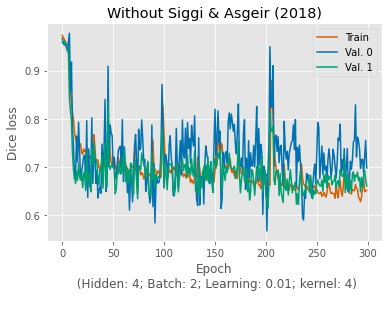

batch_size = 2 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.972941 -- Val. Loss 0: 0.960792 -- Val. Loss 1: 0.967732
Epoch 0025 -- Train Loss : 0.745263 -- Val. Loss 0: 0.654729 -- Val. Loss 1: 0.698960
Epoch 0050 -- Train Loss : 0.699291 -- Val. Loss 0: 0.600611 -- Val. Loss 1: 0.712539
Epoch 0075 -- Train Loss : 0.666659 -- Val. Loss 0: 0.624448 -- Val. Loss 1: 0.682468
Epoch 0100 -- Train Loss : 0.648158 -- Val. Loss 0: 0.649861 -- Val. Loss 1: 0.683232
Epoch 0125 -- Train Loss : 0.645760 -- Val. Loss 0: 0.747096 -- Val. Loss 1: 0.679342
Epoch 0150 -- Train Loss : 0.620904 -- Val. Loss 0: 0.634095 -- Val. Loss 1: 0.679492
Epoch 0175 -- Train Loss : 0.605488 -- Val. Loss 0: 0.619405 -- Val. Loss 1: 0.681985
Epoch 0200 -- Train Loss : 0.594748 -- Val. Loss 0: 0.552105 -- Val. Loss 1: 0.671055
Epoch 0225 -- Train Loss : 0.646572 -- Val. Loss 0: 0.625495 -- Val. Loss 1: 0.673412
Epoch 0250 -- Train Loss : 0.581405 -- Val. Loss 0: 0.626994 -- Val. Loss 1: 0.672255
Epoch 0275 -- T

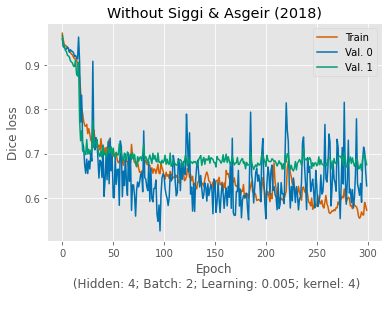

batch_size = 2 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.977693 -- Val. Loss 0: 0.968153 -- Val. Loss 1: 0.974079
Epoch 0025 -- Train Loss : 0.737060 -- Val. Loss 0: 0.747756 -- Val. Loss 1: 0.725792
Epoch 0050 -- Train Loss : 0.640724 -- Val. Loss 0: 0.673443 -- Val. Loss 1: 0.676658
Epoch 0075 -- Train Loss : 0.564751 -- Val. Loss 0: 0.674122 -- Val. Loss 1: 0.682078
Epoch 0100 -- Train Loss : 0.533196 -- Val. Loss 0: 0.749549 -- Val. Loss 1: 0.712404
Epoch 0125 -- Train Loss : 0.554280 -- Val. Loss 0: 0.625893 -- Val. Loss 1: 0.650652
Epoch 0150 -- Train Loss : 0.513402 -- Val. Loss 0: 0.700324 -- Val. Loss 1: 0.669073
Epoch 0175 -- Train Loss : 0.493436 -- Val. Loss 0: 0.694420 -- Val. Loss 1: 0.680721
Epoch 0200 -- Train Loss : 0.550134 -- Val. Loss 0: 0.709594 -- Val. Loss 1: 0.693721
Epoch 0225 -- Train Loss : 0.458255 -- Val. Loss 0: 0.738859 -- Val. Loss 1: 0.686688
Epoch 0250 -- Train Loss : 0.450059 -- Val. Loss 0: 0.699972 -- Val. Loss 1: 0.674277
Epoch 0275 -- T

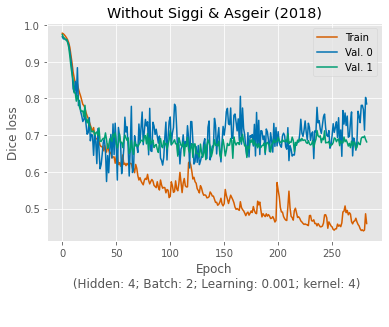

batch_size = 2 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.978329 -- Val. Loss 0: 0.969347 -- Val. Loss 1: 0.975448
Epoch 0025 -- Train Loss : 0.915846 -- Val. Loss 0: 0.905897 -- Val. Loss 1: 0.893541
Epoch 0050 -- Train Loss : 0.802384 -- Val. Loss 0: 0.849720 -- Val. Loss 1: 0.807605
Epoch 0075 -- Train Loss : 0.706564 -- Val. Loss 0: 0.784322 -- Val. Loss 1: 0.739478
Epoch 0100 -- Train Loss : 0.626631 -- Val. Loss 0: 0.795656 -- Val. Loss 1: 0.700338
Epoch 0125 -- Train Loss : 0.528104 -- Val. Loss 0: 0.853358 -- Val. Loss 1: 0.713761
Epoch 0150 -- Train Loss : 0.498586 -- Val. Loss 0: 0.869408 -- Val. Loss 1: 0.708896
Epoch 0175 -- Train Loss : 0.452356 -- Val. Loss 0: 0.856041 -- Val. Loss 1: 0.711609
Epoch 0200 -- Train Loss : 0.473613 -- Val. Loss 0: 0.903468 -- Val. Loss 1: 0.711172
Epoch 0225 -- Train Loss : 0.418807 -- Val. Loss 0: 0.885968 -- Val. Loss 1: 0.701238
Epoch 0250 -- Train Loss : 0.694796 -- Val. Loss 0: 0.891582 -- Val. Loss 1: 0.711117
Epoch 0275 -- 

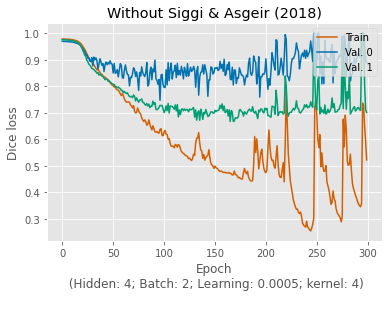

batch_size = 4 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.977923 -- Val. Loss 0: 0.974891 -- Val. Loss 1: 0.975806
Epoch 0025 -- Train Loss : 0.680969 -- Val. Loss 0: 0.743659 -- Val. Loss 1: 0.675081
Epoch 0050 -- Train Loss : 0.608888 -- Val. Loss 0: 0.752954 -- Val. Loss 1: 0.673827
Epoch 0075 -- Train Loss : 0.569692 -- Val. Loss 0: 0.726959 -- Val. Loss 1: 0.646751
Epoch 0100 -- Train Loss : 0.542273 -- Val. Loss 0: 0.661807 -- Val. Loss 1: 0.624717
Epoch 0125 -- Train Loss : 0.524104 -- Val. Loss 0: 0.677754 -- Val. Loss 1: 0.658130
Epoch 0150 -- Train Loss : 0.512997 -- Val. Loss 0: 0.719999 -- Val. Loss 1: 0.635863
Epoch 0175 -- Train Loss : 0.486923 -- Val. Loss 0: 0.717422 -- Val. Loss 1: 0.620188
Epoch 0200 -- Train Loss : 0.480118 -- Val. Loss 0: 0.709799 -- Val. Loss 1: 0.639156
Epoch 0225 -- Train Loss : 0.492786 -- Val. Loss 0: 0.662546 -- Val. Loss 1: 0.645394
Epoch 0250 -- Train Loss : 0.468023 -- Val. Loss 0: 0.719981 -- Val. Loss 1: 0.652425
Epoch 0275 -- Tr

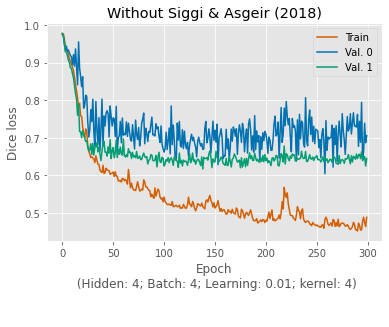

batch_size = 4 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.976558 -- Val. Loss 0: 0.973693 -- Val. Loss 1: 0.974504
Epoch 0025 -- Train Loss : 0.906008 -- Val. Loss 0: 0.917881 -- Val. Loss 1: 0.893843
Epoch 0050 -- Train Loss : 0.854498 -- Val. Loss 0: 0.915243 -- Val. Loss 1: 0.838738
Epoch 0075 -- Train Loss : 0.662509 -- Val. Loss 0: 0.833186 -- Val. Loss 1: 0.720009
Epoch 0100 -- Train Loss : 0.668222 -- Val. Loss 0: 0.815661 -- Val. Loss 1: 0.720566
Epoch 0125 -- Train Loss : 0.608354 -- Val. Loss 0: 0.799028 -- Val. Loss 1: 0.696516
Epoch 0150 -- Train Loss : 0.602101 -- Val. Loss 0: 0.812235 -- Val. Loss 1: 0.669410
Epoch 0175 -- Train Loss : 0.517188 -- Val. Loss 0: 0.777574 -- Val. Loss 1: 0.665545
Epoch 0200 -- Train Loss : 0.641946 -- Val. Loss 0: 0.890897 -- Val. Loss 1: 0.758324
Epoch 0225 -- Train Loss : 0.494895 -- Val. Loss 0: 0.834536 -- Val. Loss 1: 0.662132
Epoch 0250 -- Train Loss : 0.586730 -- Val. Loss 0: 0.991850 -- Val. Loss 1: 0.928290
Epoch 0275 -- T

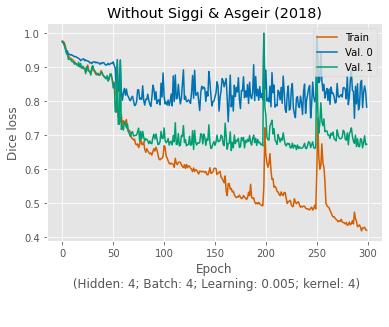

batch_size = 4 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.977180 -- Val. Loss 0: 0.975472 -- Val. Loss 1: 0.976357
Epoch 0025 -- Train Loss : 0.934810 -- Val. Loss 0: 0.955576 -- Val. Loss 1: 0.935420
Epoch 0050 -- Train Loss : 0.903261 -- Val. Loss 0: 0.933326 -- Val. Loss 1: 0.911381
Epoch 0075 -- Train Loss : 0.856299 -- Val. Loss 0: 0.901217 -- Val. Loss 1: 0.879703
Epoch 0100 -- Train Loss : 0.778606 -- Val. Loss 0: 0.893405 -- Val. Loss 1: 0.841261
Epoch 0125 -- Train Loss : 0.701773 -- Val. Loss 0: 0.860496 -- Val. Loss 1: 0.793454
Epoch 0150 -- Train Loss : 0.608865 -- Val. Loss 0: 0.824995 -- Val. Loss 1: 0.766610
Epoch 0175 -- Train Loss : 0.532852 -- Val. Loss 0: 0.804076 -- Val. Loss 1: 0.751478
Epoch 0200 -- Train Loss : 0.465075 -- Val. Loss 0: 0.822743 -- Val. Loss 1: 0.733292
Epoch 0225 -- Train Loss : 0.443843 -- Val. Loss 0: 0.823585 -- Val. Loss 1: 0.730342
Epoch 0250 -- Train Loss : 0.389561 -- Val. Loss 0: 0.818662 -- Val. Loss 1: 0.740457
Epoch 0275 -- T

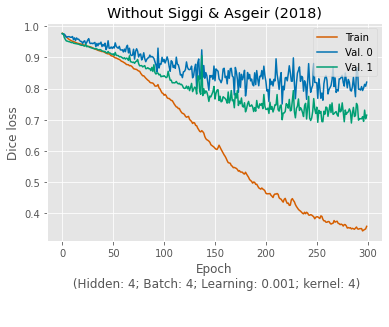

batch_size = 4 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.977906 -- Val. Loss 0: 0.975461 -- Val. Loss 1: 0.976322
Epoch 0025 -- Train Loss : 0.946396 -- Val. Loss 0: 0.944642 -- Val. Loss 1: 0.946942
Epoch 0050 -- Train Loss : 0.807222 -- Val. Loss 0: 0.878012 -- Val. Loss 1: 0.872128
Epoch 0075 -- Train Loss : 0.687774 -- Val. Loss 0: 0.871521 -- Val. Loss 1: 0.837044
Epoch 0100 -- Train Loss : 0.580412 -- Val. Loss 0: 0.859155 -- Val. Loss 1: 0.807468
Epoch 0125 -- Train Loss : 0.519585 -- Val. Loss 0: 0.892315 -- Val. Loss 1: 0.833858
Epoch 0150 -- Train Loss : 0.471503 -- Val. Loss 0: 0.911605 -- Val. Loss 1: 0.829046
Epoch 0175 -- Train Loss : 0.435785 -- Val. Loss 0: 0.927308 -- Val. Loss 1: 0.815900
Epoch 0200 -- Train Loss : 0.407594 -- Val. Loss 0: 0.910261 -- Val. Loss 1: 0.823185
Epoch 0225 -- Train Loss : 0.395143 -- Val. Loss 0: 0.854527 -- Val. Loss 1: 0.780456
Epoch 0250 -- Train Loss : 0.406539 -- Val. Loss 0: 0.855242 -- Val. Loss 1: 0.801427
Epoch 0275 -- 

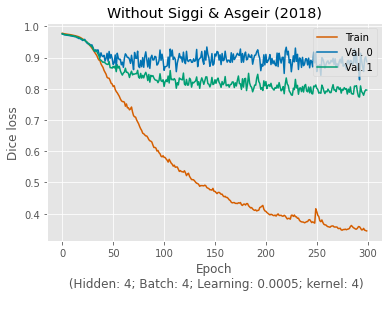

batch_size = 8 ; learning_rate = 0.01
Epoch 0000 -- Train Loss : 0.975744 -- Val. Loss 0: 0.970859 -- Val. Loss 1: 0.974872
Epoch 0025 -- Train Loss : 0.820925 -- Val. Loss 0: 0.917845 -- Val. Loss 1: 0.875507
Epoch 0050 -- Train Loss : 0.745149 -- Val. Loss 0: 0.894159 -- Val. Loss 1: 0.815397
Epoch 0075 -- Train Loss : 0.550325 -- Val. Loss 0: 0.878372 -- Val. Loss 1: 0.714280
Epoch 0100 -- Train Loss : 0.495327 -- Val. Loss 0: 0.820863 -- Val. Loss 1: 0.655191
Epoch 0125 -- Train Loss : 0.484348 -- Val. Loss 0: 0.801006 -- Val. Loss 1: 0.661985
Epoch 0150 -- Train Loss : 0.510659 -- Val. Loss 0: 0.765541 -- Val. Loss 1: 0.643822
Epoch 0175 -- Train Loss : 0.421034 -- Val. Loss 0: 0.858874 -- Val. Loss 1: 0.675254
Epoch 0200 -- Train Loss : 0.412856 -- Val. Loss 0: 0.765088 -- Val. Loss 1: 0.656258
Epoch 0225 -- Train Loss : 0.385148 -- Val. Loss 0: 0.880508 -- Val. Loss 1: 0.688029
Epoch 0250 -- Train Loss : 0.366351 -- Val. Loss 0: 0.837391 -- Val. Loss 1: 0.687671
Epoch 0275 -- Tr

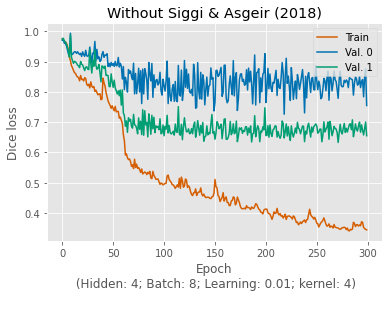

batch_size = 8 ; learning_rate = 0.005
Epoch 0000 -- Train Loss : 0.976873 -- Val. Loss 0: 0.973067 -- Val. Loss 1: 0.977151
Epoch 0025 -- Train Loss : 0.597124 -- Val. Loss 0: 0.768258 -- Val. Loss 1: 0.693105
Epoch 0050 -- Train Loss : 0.453835 -- Val. Loss 0: 0.797463 -- Val. Loss 1: 0.649662
Epoch 0075 -- Train Loss : 0.432537 -- Val. Loss 0: 0.752668 -- Val. Loss 1: 0.645988
Epoch 0100 -- Train Loss : 0.408978 -- Val. Loss 0: 0.691198 -- Val. Loss 1: 0.625102
Epoch 0125 -- Train Loss : 0.379200 -- Val. Loss 0: 0.779152 -- Val. Loss 1: 0.662415
Epoch 0150 -- Train Loss : 0.380340 -- Val. Loss 0: 0.837222 -- Val. Loss 1: 0.649291
Epoch 0175 -- Train Loss : 0.396940 -- Val. Loss 0: 0.891321 -- Val. Loss 1: 0.723101
Epoch 0200 -- Train Loss : 0.330584 -- Val. Loss 0: 0.871180 -- Val. Loss 1: 0.718552
Epoch 0225 -- Train Loss : 0.312338 -- Val. Loss 0: 0.827443 -- Val. Loss 1: 0.685828
Epoch 0250 -- Train Loss : 0.309316 -- Val. Loss 0: 0.866972 -- Val. Loss 1: 0.737456
Epoch 0275 -- T

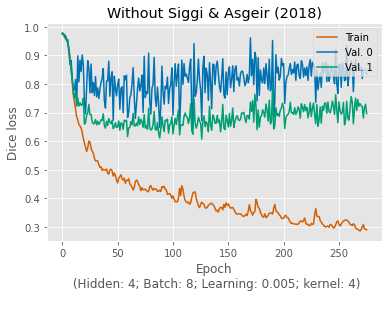

batch_size = 8 ; learning_rate = 0.001
Epoch 0000 -- Train Loss : 0.977163 -- Val. Loss 0: 0.972758 -- Val. Loss 1: 0.976878
Epoch 0025 -- Train Loss : 0.962350 -- Val. Loss 0: 0.968052 -- Val. Loss 1: 0.965940
Epoch 0050 -- Train Loss : 0.955622 -- Val. Loss 0: 0.968666 -- Val. Loss 1: 0.961871
Epoch 0075 -- Train Loss : 0.947117 -- Val. Loss 0: 0.962833 -- Val. Loss 1: 0.954349
Epoch 0100 -- Train Loss : 0.935256 -- Val. Loss 0: 0.965521 -- Val. Loss 1: 0.950902
Epoch 0125 -- Train Loss : 0.919817 -- Val. Loss 0: 0.959962 -- Val. Loss 1: 0.939499
Epoch 0150 -- Train Loss : 0.898734 -- Val. Loss 0: 0.951268 -- Val. Loss 1: 0.927325
Epoch 0175 -- Train Loss : 0.872846 -- Val. Loss 0: 0.953796 -- Val. Loss 1: 0.910771
Epoch 0200 -- Train Loss : 0.831393 -- Val. Loss 0: 0.959572 -- Val. Loss 1: 0.905231
Epoch 0225 -- Train Loss : 0.788878 -- Val. Loss 0: 0.943041 -- Val. Loss 1: 0.875150
Epoch 0250 -- Train Loss : 0.742992 -- Val. Loss 0: 0.958595 -- Val. Loss 1: 0.873698
Epoch 0275 -- T

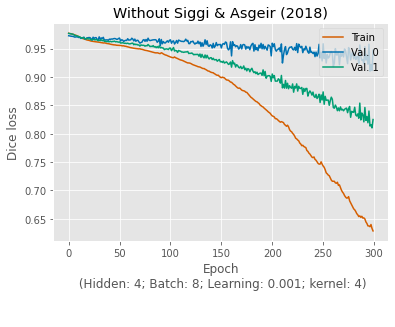

batch_size = 8 ; learning_rate = 0.0005
Epoch 0000 -- Train Loss : 0.977563 -- Val. Loss 0: 0.973056 -- Val. Loss 1: 0.977158
Epoch 0025 -- Train Loss : 0.952630 -- Val. Loss 0: 0.965525 -- Val. Loss 1: 0.964384
Epoch 0050 -- Train Loss : 0.888741 -- Val. Loss 0: 0.951676 -- Val. Loss 1: 0.933625
Epoch 0075 -- Train Loss : 0.707185 -- Val. Loss 0: 0.943493 -- Val. Loss 1: 0.915130
Epoch 0100 -- Train Loss : 0.597981 -- Val. Loss 0: 0.961477 -- Val. Loss 1: 0.894622
Epoch 0125 -- Train Loss : 0.513652 -- Val. Loss 0: 0.961439 -- Val. Loss 1: 0.906347
Epoch 0150 -- Train Loss : 0.443983 -- Val. Loss 0: 0.928373 -- Val. Loss 1: 0.874279
Epoch 0175 -- Train Loss : 0.370931 -- Val. Loss 0: 0.953148 -- Val. Loss 1: 0.896525
Epoch 0200 -- Train Loss : 0.312360 -- Val. Loss 0: 0.949991 -- Val. Loss 1: 0.877021
Epoch 0225 -- Train Loss : 0.276914 -- Val. Loss 0: 0.968111 -- Val. Loss 1: 0.871552
Epoch 0250 -- Train Loss : 0.247566 -- Val. Loss 0: 0.969770 -- Val. Loss 1: 0.884256
Epoch 0275 -- 

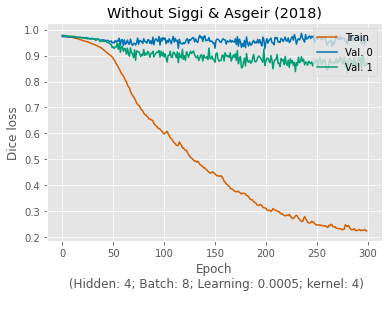

In [ ]:
import glob, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# saved_model = False
saved_model = True

no_improve_epoch = 150
# epochs = 7; epoch_print = 2
epoch_print = 25

trLoss = np.zeros(epochs)
vlLoss_0 = np.zeros(epochs)
vlLoss_1 = np.zeros(epochs)

# https://stackoverflow.com/a/31675177
res = ['hidden_unit', 'batch_size', 'learning_rate', 'min_val_0', 'min_val_1', 
        'min_index_0', 'min_index_1', 'n_part', 'epochs', 'e', 'n_kernel']

bs = 0
while bs < len(Batch_size) :

  batch_size = Batch_size[bs]
  lr = 0
  while lr < len(Learning_rate):

    min_val_0 = sys.float_info.max; min_index_0 = -1
    min_val_1 = sys.float_info.max; min_index_1 = -1

    learning_rate = Learning_rate[lr]
    print('batch_size = ' + str(batch_size) + ' ; learning_rate = ' + str(learning_rate))

    net = UTime(in_channels = C, out_channels = 1, n_fillter = hidden_unit, n_kernel=n_kernel)
    net.cuda()
    net.zero_grad() # Zero the network gradients

    # https://pytorch.org/docs/stable/optim.html#constructing-it
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Run model
    for epoch in range(epochs):
      
      batchLoss = 0
      nBatch = int(nTrain/batch_size)
      
      net.train()
      for i in range(nBatch+1): 
        if i == nBatch:
          X = x_train[-batch_size:]; Y = y_train[-batch_size:]
        else:
          X = x_train[i*batch_size:(i+1)*batch_size]
          Y = y_train[i*batch_size:(i+1)*batch_size]
            
        optimizer.zero_grad() # 1) clear previous gradient computation
        # https://stackoverflow.com/q/57237352
        Y_pred = net(X) # 2) forward propagation
        output = criterion(Y_pred, Y) # 3) calculate the loss
        output.backward() # 4) backpropagate to compute gradients
        batchLoss += output
        
        optimizer.step() # 5) update model weights
      # end for loop
      
      trLoss[epoch] = batchLoss/(nBatch+1)
      
      # Compute validation loss/Enter eval mode
      net.eval()
      
      # Validtion as 0th element
      x_val = x_w[0]; y_val = y_w[0]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_0[epoch] = batchLoss/(nBatch+1)

      # Validtion as 1st element
      x_val = x_w[1]; y_val = y_w[1]
      nVal = len(x_val)
      nBatch = int(nVal/batch_size)
      batchLoss = 0
      with torch.no_grad():
        for i in range(nBatch+1):
          if i == nBatch:
            X = x_val[-batch_size:]
            Y = y_val[-batch_size:]
          else:
            X = x_val[i*batch_size:(i+1)*batch_size]
            Y = y_val[i*batch_size:(i+1)*batch_size]
     
          Y_pred = net(X)
          output = criterion(Y_pred,Y) # calculate the loss
          batchLoss += output # update running loss value
      vlLoss_1[epoch] = batchLoss/(nBatch+1)


      if (epoch % epoch_print == 0.0):
        print( "Epoch {e:04d} -- Train Loss : {l:2.6f} -- Val. Loss 0: {v0:2.6f} -- Val. Loss 1: {v1:2.6f}".format
              (e=epoch,l=trLoss[epoch], v0=vlLoss_0[epoch], v1=vlLoss_1[epoch]) )
      
      # Validtion as 0th element
      if (min_val_0 > vlLoss_0[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_0 = vlLoss_0[epoch]
        min_index_0 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' +
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) +
                      '_epoch-' + str(min_index_0) + '_kernel-' + str(n_kernel) +
                      '_' + str(test_whale[0]) + str(test_whale[1]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_0, 'min_index':min_index_0 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      
      # Validtion as 1st element
      if (min_val_1 > vlLoss_1[epoch]):
        model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
        if (epoch > 0):
          if saved_model :
            try:
              os.remove('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
            except OSError as err:  ## if failed, report it back to the user ##
              print ("Error: %s - %s." % (err.filename, err.strerror))
        min_val_1 = vlLoss_1[epoch]
        min_index_1 = epoch
        # Save model
        if saved_model :
          model_name = ('whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + 
                      str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2 )) + 
                      '_epoch-' + str(min_index_1) + '_kernel-' + str(n_kernel) + 
                      '_' + str(test_whale[1]) + str(test_whale[0]))
          torch.save({'state_dict': net.state_dict(), 'min_val':min_val_1, 'min_index':min_index_1 }, 
                     'data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt')
      else:
        if epoch >= ( max(min_index_0,min_index_1) + no_improve_epoch ) :
          print("Model isn't probably improved anymore, skip to next learning rate...\n")
          break

    torch.cuda.empty_cache() # https://stackoverflow.com/a/55340037

    # # Prediction
    del net, optimizer  # https://stackoverflow.com/a/53353203
    torch.cuda.empty_cache()

    plt.plot(trLoss[:epoch], color='#D55E00' )
    plt.plot(vlLoss_0[:epoch], color='#0072B2' )
    plt.plot(vlLoss_1[:epoch], color='#009E73' )
    plt.title('Without ' + extract_name(all_files[test_whale[0]]) + ' & ' + 
              extract_name(all_files[test_whale[1]]) +' (2018)')

    plt.ylabel('Dice loss')
    plt.xlabel('Epoch\n (Hidden: ' + str(hidden_unit) + '; Batch: ' + str(batch_size) + '; Learning: ' + 
               str(learning_rate) + '; kernel: ' + str(n_kernel) + ')\n\n' )
    plt.legend(['Train', 'Val. 0', 'Val. 1'], loc='upper right')
    if saved_model :
      plt.savefig('data/model/whale/U-Time_7/' + whale_name + '/plot/' + model_name + '_diceloss.svg', 
                  format="svg", figsize=(12, 8), bbox_inches='tight')
    plt.show()
    res = np.c_[res, np.r_[hidden_unit, batch_size, learning_rate, 
                           min_val_0,  min_val_1, min_index_0,min_index_1,
                           round(T/(60*e),2), epochs, e, n_kernel]]

    lr += 1

  bs += 1


In [ ]:
import pandas as pd
dt = pd.DataFrame(res.transpose()[1:,], columns=res.transpose()[0,:])
dt.sort_values(['min_val_0','min_val_1'])

hidden_unit batch_size learning_rate  ... epochs     e n_kernel
1          4.0        2.0         0.005  ...  301.0  10.0      4.0
0          4.0        2.0          0.01  ...  301.0  10.0      4.0
2          4.0        2.0         0.001  ...  301.0  10.0      4.0
4          4.0        4.0          0.01  ...  301.0  10.0      4.0
9          4.0        8.0         0.005  ...  301.0  10.0      4.0
8          4.0        8.0          0.01  ...  301.0  10.0      4.0
5          4.0        4.0         0.005  ...  301.0  10.0      4.0
3          4.0        2.0        0.0005  ...  301.0  10.0      4.0
6          4.0        4.0         0.001  ...  301.0  10.0      4.0
7          4.0        4.0        0.0005  ...  301.0  10.0      4.0
10         4.0        8.0         0.001  ...  301.0  10.0      4.0
11         4.0        8.0        0.0005  ...  301.0  10.0      4.0

[12 rows x 11 columns]

### Plot and prediction

In [92]:
# Load saved model using GPU/CPU
envr = 'cuda'
envr = 'cpu'

hidden_unit = 4
n_kernel = 4

batch_size = 2
learning_rate = 0.005
epoch = 96

model_name = 'whale_' + str(hidden_unit) + '_' + str(batch_size) + '_' + \
                    str(learning_rate) + '_' + str(e) + '_' + str(round(T/(60*e),2)) + \
                    '_epoch-' + str(epoch) + '_kernel-' + str(n_kernel) + \
                    '_' + str(test_whale[0]) + str(test_whale[1])

model = UTime(in_channels=C, out_channels=1, n_fillter=hidden_unit, n_kernel=n_kernel)
state_dict = torch.load('data/model/whale/U-Time_7/' + whale_name + '/' + model_name + '.pt',
                        map_location=torch.device(envr) )['state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
# Test on all whales combined

Ind = X_all[ :,-1].copy().astype(np.int64)

with torch.no_grad():
  y_a = model(x_all)
# y_a = concat_overlap(y_a, Ind-Ind.min())
y_a = y_a[0,:].numpy()

y_t_all = y_all
y_t_all = concat_overlap(y_t_all, Ind-Ind.min())
y_t_all = y_t_all.numpy()

In [94]:
from collections import Counter
C_t = consecutive(y_t_all)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,14) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y_a, y_t_all, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y_a, y_t_all, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t_all, y_a),2) )
L0.append( round(roc_auc_score(y_t_all, y_a),2) )
L0.append(sum([ accel[i].shape[0] for i in train_whale ]))
Res[0,:] = np.ravel(L0)

Res

array([[       0.23,        0.62,        0.68,        0.74,        0.74,        0.75,        0.76,        0.78,
               0.79,        0.81,        0.82,        0.3 ,        0.84, 29067800.  ]])

In [95]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()

whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + ''.join( str(v) for v in train_whale) + '.txt', 
                index=False )
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
def concat_overlap(y, ovl):
  if len(y.shape) <= 1 :
    return y
  if y.shape[0] <= 1 :
    return y
  return torch.cat(( y[:-2,:].view(-1), y[-2,:ovl], 
                    (y[-2,ovl:] + y[-1,:-ovl])/2, y[-1,-ovl:] ))

x_test = x_w[1]; y_test = y_w[1]

with torch.no_grad():
  y = model(x_test)

y = concat_overlap(y, accel[test_whale[1]].shape[0]%L).numpy()
y_t = concat_overlap(y_test, accel[test_whale[1]].shape[0]%L).numpy()

In [ ]:
from collections import Counter

print(y_t.sum()/y_t.shape[0]*100)
print(extract_name(all_files[test_whale[1]]))
print(Counter(y_t))

1.37530599621915
Asgeir
Counter({0.0: 11321030, 1.0: 157870})


In [ ]:
from collections import Counter
C_t = consecutive(y_t)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

Res = np.zeros( (1,13) )

L0 = []
for p in [99, 50, 25, 0] :
  _, ptg, _, _ = hit_rate(y, y_t, ovl_ptg=p)
  L0.append( round(ptg, 2) )
for t in [10, 50, 100, 200, 300, 400, 500] :
  R, _, hit, missed = hit_rate(y, y_t, t)
  L0.append( round(R, 2) )

  # missed_1st_indx = np.ravel( [C_t[i][0] for i in missed] )
  # print( Counter(accel[w].iloc[missed_1st_indx, 9 ].to_numpy()) ) 
  # print( Counter(accel[w].iloc[missed_1st_indx, 10 ].to_numpy()) ) 

L0.append( round(average_precision_score(y_t, y),2) )
L0.append( round(roc_auc_score(y_t, y),2) )
Res[0,:] = np.ravel(L0)

In [ ]:
%load_ext google.colab.data_table

# https://stackoverflow.com/a/20763459
# https://stackoverflow.com/a/57649212
res = pd.DataFrame(data=Res.T, columns = [extract_name(all_files[test_whale[1]])] ,
             index=None ).style.format({extract_name(all_files[test_whale[1]]): '{:.2}'}).hide_index()
res

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
whale_test = extract_name(all_files[test_whale[1]])
res.data.to_csv( 'data/whale/2018/res_U-Net_' + whale_test + '.txt', 
                index=False )

# Join files together

In [ ]:
all_files

['data/whale/2018/accel-Asgeir.csv.parquet',
 'data/whale/2018/accel-Helge18.csv.parquet',
 'data/whale/2018/accel-Kyrri.csv.parquet',
 'data/whale/2018/accel-Nemo.csv.parquet',
 'data/whale/2018/accel-Siggi.csv.parquet']

In [ ]:
df = [None] * len(all_files)

In [ ]:
i = 0
for x in all_files:
  wn = 'data/whale/2018/res_U-Net_' + extract_name(x) + '.txt'
  df[i] = pd.read_csv(wn)
  i += 1

dt = pd.concat(df, axis=1)

dt['index'] = pd.Series(["> 99%","> 50%","> 25%","> 0%","0.1 s","0.5 s",
                         "1 s","2 s","3 s","4 s","5 s",'Precision','Recall' ]).values
dt = dt.set_index('index')
dat = pd.melt(dt.reset_index(), id_vars='index', value_vars=dt.columns)
dat.rename(columns={"variable": "whale", "value": "val"}, inplace=True)
dat['method'] = 'U-Net (cross validation)'

In [ ]:
dat.to_csv( 'data/whale/2018/res_U-Net_CV.csv', index=False )

In [96]:
unet_files = glob.glob("data/whale/2018/*.txt.csv")
unet_files = sorted(unet_files, reverse=False)
unet_files

['data/whale/2018/res_U-Net_012.txt.csv',
 'data/whale/2018/res_U-Net_014.txt.csv',
 'data/whale/2018/res_U-Net_034.txt.csv',
 'data/whale/2018/res_U-Net_123.txt.csv',
 'data/whale/2018/res_U-Net_234.txt.csv']

In [97]:
df = [None] * len(unet_files)

i = 0
for x in unet_files:
  df[i] = pd.read_csv(x)
  i += 1

dt = pd.concat(df, axis=1)

In [98]:
dt['index'] = pd.Series(["> 99%","> 50%","> 25%","> 0%","0.1 s","0.5 s",
                         "1 s","2 s","3 s","4 s","5 s",'Precision','Recall','len_train' ]).values
dt = dt.set_index('index')
dat = pd.melt(dt.reset_index(), id_vars='index', value_vars=dt.columns)
dat.rename(columns={"variable": "whale", "value": "val"}, inplace=True)
dat['method'] = 'U-Net (cross validation)'

In [100]:
dat.to_csv( 'data/whale/2018/res_U-Net_CV_all.csv', index=False )

dat

index    whale          val                    method
0       > 99%    Siggi         0.22  U-Net (cross validation)
1       > 50%    Siggi         0.71  U-Net (cross validation)
2       > 25%    Siggi         0.77  U-Net (cross validation)
3        > 0%    Siggi         0.79  U-Net (cross validation)
4       0.1 s    Siggi         0.80  U-Net (cross validation)
..        ...      ...          ...                       ...
65        4 s  Helge18         0.70  U-Net (cross validation)
66        5 s  Helge18         0.71  U-Net (cross validation)
67  Precision  Helge18         0.28  U-Net (cross validation)
68     Recall  Helge18         0.92  U-Net (cross validation)
69  len_train  Helge18  20642200.00  U-Net (cross validation)

[70 rows x 4 columns]